In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import re

import logging as logger
import logging
import wordcloud
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import time
import scikitplot as skplt 
import torch.nn.functional as F

In [2]:
# Set logger
import logging, time, sys
loggers = {}

def set_logger(name, level):
    global loggers

    if loggers.get(name):
        return loggers.get(name)
    else:
        logger = logging.getLogger(name)
        if (logger.hasHandlers()):
            logger.handlers.clear()
            
        logger.setLevel(level)

        timestamp = time.strftime("%Y.%m.%d_%H.%M.%S", time.localtime())
        formatter = logging.Formatter('[%(asctime)s][%(levelname)s] ## %(message)s')

        fh = logging.FileHandler(name + '.log')
        # fh.setLevel(logging.DEBUG)
        fh.setFormatter(formatter)
        logger.addHandler(fh)

        ch = logging.StreamHandler(sys.stdout)
        # ch.setLevel(level)
        ch.setFormatter(formatter)
        logger.addHandler(ch)
        
        loggers[name] = logger
        return logger

logger = set_logger('sa_tweet_inperf', logging.DEBUG)

In [15]:
data1 = pd.read_csv('training_data.csv')
output_dir = '/content/output'
#data = data1[:1700]

In [3]:
from collections import Counter
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

def tokenize_text(text, option):
  '''
  Tokenize the input text as per specified option
    1: Use python split() function
    2: Use regex to extract alphabets plus 's and 't
    3: Use NLTK word_tokenize()
    4: Use NLTK word_tokenize(), remove stop words and apply lemmatization
  '''
  if option == 1:
    return text.split()
  elif option == 2:
    return re.findall(r'\b([a-zA-Z]+n\'t|[a-zA-Z]+\'s|[a-zA-Z]+)\b', text)
  elif option == 3:
    return [word for word in word_tokenize(text) if (word.isalpha()==1)]
  elif option == 4:
    words = [word for word in word_tokenize(text) if (word.isalpha()==1)]
    # Remove stop words
    stop = set(stopwords.words('english'))
    words = [word for word in words if (word not in stop)]
    # Lemmatize words (first noun, then verb)
    wnl = nltk.stem.WordNetLemmatizer()
    lemmatized = [wnl.lemmatize(wnl.lemmatize(word, 'n'), 'v') for word in words]
    return lemmatized
  else:
    logger.warn("Please specify option value between 1 and 4")
    return []

[nltk_data] Downloading package punkt to C:\Users\Ihtisham
[nltk_data]     Ahmad\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Ihtisham
[nltk_data]     Ahmad\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Ihtisham
[nltk_data]     Ahmad\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [28]:
pos = data1[data1['Sentiment']==1]

In [37]:
data1

Unnamed: 0  Unnamed: 0.1  Unnamed: 0.1.1                   Datetime  \
97            97            97           81448  2022-01-01 07:22:03+00:00   
532          532           532          112054  2021-11-10 15:25:26+00:00   
765          765           765          191384  2021-07-03 16:44:02+00:00   
1766        1770           838          116670  2021-11-03 14:48:26+00:00   
167          167           167          129403  2021-10-15 06:49:47+00:00   
...          ...           ...             ...                        ...   
1855        1859           927          296279  2021-01-22 01:54:12+00:00   
51            51            51          187212  2021-07-13 22:47:14+00:00   
1133        1136           204          144444  2021-09-20 12:05:31+00:00   
1617        1621           689           17905  2022-04-23 15:31:56+00:00   
806          806           806          164526  2021-08-21 11:43:51+00:00   

          Tweet Id                                               Text  \
97    1.477178e+18            ethereum eth current price eth ethereum   
532   1.458456e+18  can guarantee if click on the tag it will be b...   
765   1.411365e+18  the current price of eth ethereum is airdrop c...   
1766  1.455910e+18         ethereum mi yok art yaaa bu nas sa mal yaa   
167   1.448904e+18  cryptocurrencynews crypto blockchain alts dex ...   
...            ...                                                ...   
1855  1.352434e+18  imagine bitcoin whales only dumped to gain bet...   
51    1.415080e+18  ethereum trying to catch the pullback for bina...   
1133  1.439924e+18  the cryptomarket is seeing some red today does...   
1617  1.517889e+18                   closed longs eth ethereum crypto   
806   1.429047e+18  new ethereum addresses reach monthly high ethe...   

             Username  Sentiment  
97       aWebAnalysis        1.0  
532         0xNemissa        3.0  
765    CryptoRendered        3.0  
1766        mertk8915        3.0  
167          mikirede        3.0  
...               ...        ...  
1855  TheBeardedTrade        1.0  
51       bitcoinagile        2.0  
1133    coinclubelite        0.0  
1617       scalper432        0.0  
806            pnxgrp        1.0  

[2733 rows x 8 columns]

In [32]:
data1[data1['Sentiment']==1].count()

Unnamed: 0        636
Unnamed: 0.1      636
Unnamed: 0.1.1    636
Datetime          636
Tweet Id          636
Text              636
Username          636
Sentiment         636
dtype: int64

In [31]:
data1 = pd.concat([data1, pos])

In [33]:
from sklearn.utils import shuffle
data1 = shuffle(data1)

In [38]:
data = data1[:2600]

In [36]:
data1.to_csv('/content/drive/MyDrive/dataset/eth_train.csv')

In [110]:
# Balancing the data
import random
train_df = data
n_neutral = sum(1 for each in train_df['Sentiment'] if each == 0)
n_positive = sum(1 for each in train_df['Sentiment'] if each == 1)
n_negative = sum(1 for each in train_df['Sentiment'] if each == 2)
n_irrelevant = sum(1 for each in train_df['Sentiment'] if each == 3)
N_examples = train_df.shape[0]

print('Negative:', n_negative/N_examples)
print('Neutral: ', n_neutral/N_examples)
print('Positive:', n_positive/N_examples)
print('Irrelevant:', n_irrelevant/N_examples)
print('Total records: ', N_examples)

balanced = {'org message': [], 'Text': [], 'Sentiment': []}

# Keep probability
# As the negative has the least number of data, trim neutral and positive
keep_prob_neutral = n_negative/n_neutral
keep_prob_positive = n_negative/n_positive
keep_prob = 0.25

for i, row in tqdm(train_df.iterrows(), total=train_df.shape[0]):
    if row['Text'].strip() == "":
        continue
    elif (row['Sentiment'] == 0) or ((row['Sentiment'] == 3) and (random.random() < keep_prob)) or ((row['Sentiment'] == 2) and (random.random() < keep_prob) or (row['Sentiment'] == 1)):
        balanced['org message'].append(row['Text'])
        balanced['Text'].append(row['Text'])
        balanced['Sentiment'].append(row['Sentiment'])

train_df = pd.DataFrame(balanced)
n_neutral = sum(1 for each in train_df['Sentiment'] if each == 0)
n_positive = sum(1 for each in train_df['Sentiment'] if each == 1)
n_negative = sum(1 for each in train_df['Sentiment'] if each == 2)
n_irrelevant = sum(1 for each in train_df['Sentiment'] if each == 3)
N_examples = train_df.shape[0]

print('Negative:', n_negative/N_examples)
print('Neutral: ', n_neutral/N_examples)
print('Positive:', n_positive/N_examples)
print('Irrelevant:', n_irrelevant/N_examples)
print('Total records: ', N_examples)

Negative: 0.06470588235294118
Neutral:  0.3788235294117647
Positive: 0.17823529411764705
Irrelevant: 0.37823529411764706
Total records:  1700


100%|██████████| 1700/1700 [00:00<00:00, 15283.96it/s]

Negative: 0.025416301489921123
Neutral:  0.5644171779141104
Positive: 0.26555652936021035
Irrelevant: 0.1446099912357581
Total records:  1141


Tokenizaing: 100%|███████████████████████████████████████████████████████████| 310645/310645 [00:55<00:00, 5551.56it/s]

[2022-08-25 18:17:43,275][INFO] ## The number of all words: 5855965


[2022-08-25 18:17:43,967][INFO] ## The number of unique words: 86053
[2022-08-25 18:17:43,996][INFO] ## Top 40 frequent words: ['ethereum', 'the', 'eth', 'bitcoin', 'to', 'is', 'price', 'crypto', 'in', 'of', 'mxn', 'and', 'on', 'has', 'by', 'for', 'btc', 'cryptocurrency', 'last', 'at', 'this', 'it', 'nft', 'now', 'ripple', 'defi', 'you', 'binance', 'social', 'will', 'blockchain', 'be', 'with', 'hours', 'right', 'trading', 'just', 'we', 'tweet', 'dropped']


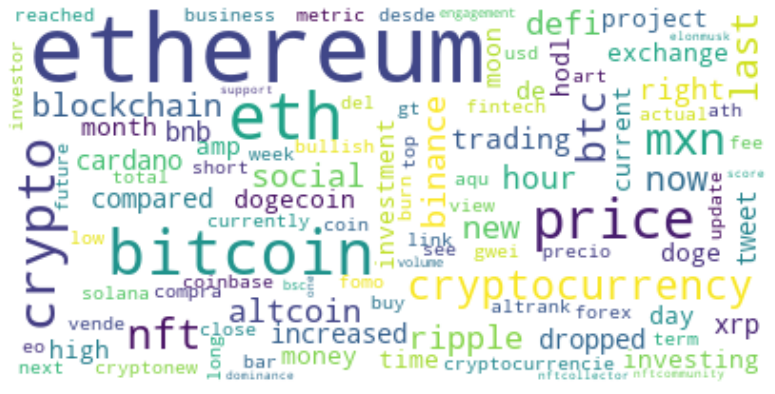

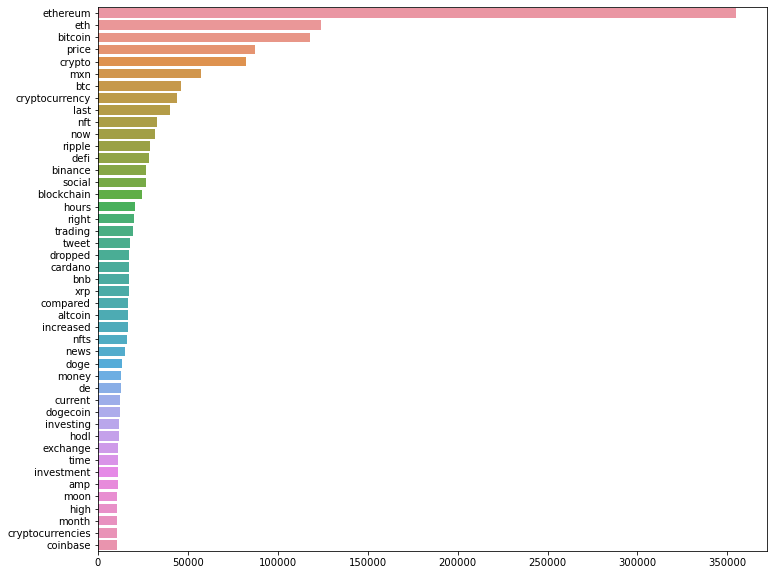

In [7]:
# Create vocab
def create_vocab(messages, show_graph=False):
    corpus = []
    for message in tqdm(messages, desc="Tokenizaing"):
        tokens = tokenize_text(message, 3) # Use option 3
        corpus.extend(tokens)
    logger.info("The number of all words: {}".format(len(corpus)))

    # Create Counter
    counts = Counter(corpus)
    logger.info("The number of unique words: {}".format(len(counts)))

    # Create BoW
    bow = sorted(counts, key=counts.get, reverse=True)
    logger.info("Top 40 frequent words: {}".format(bow[:40]))

    # Indexing vocabrary, starting from 1.
    vocab = {word: ii for ii, word in enumerate(counts, 1)}
    id2vocab = {v: k for k, v in vocab.items()}

    if show_graph:
        from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
        # Generate Word Cloud image
        text = " ".join(corpus)
        stopwords = set(STOPWORDS)
        stopwords.update(["will", "report", "reporting", "market", "stock", "share"])

        wordcloud = WordCloud(stopwords=stopwords, max_font_size=50, max_words=100, background_color="white", collocations=False).generate(text)
        plt.figure(figsize=(15,7))
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.axis("off")
        plt.show()

        # Show most frequent words in a bar graph
        most = counts.most_common()[:80]
        x, y = [], []
        for word, count in most:
            if word not in stopwords:
                x.append(word)
                y.append(count)
        plt.figure(figsize=(12,10))
        sns.barplot(x=y, y=x)
        plt.show()

    return vocab

vocab= create_vocab(eth['Text'], True)

In [12]:
from torch import nn

# Define LSTM Model
class LstmTextClassifier(nn.Module):
  def __init__(self, vocab_size, embed_size, lstm_size, dense_size, output_size, lstm_layers=2, dropout=0.1):
    """
    Initialize the model
    """
    super().__init__()
    self.vocab_size = vocab_size
    self.embed_size = embed_size
    self.lstm_size = lstm_size
    self.dense_size = dense_size
    self.output_size = output_size
    self.lstm_layers = lstm_layers
    self.dropout = dropout

    self.embedding = nn.Embedding(vocab_size, embed_size)
    self.lstm = nn.LSTM(embed_size, lstm_size, lstm_layers, dropout=dropout, batch_first=False)
    self.dropout = nn.Dropout(dropout)
    # Insert an additional fully connected when combining with other inputs
    if dense_size == 0:
        self.fc = nn.Linear(lstm_size, output_size)
    else:
        self.fc1 = nn.Linear(lstm_size, dense_size)
        self.fc2 = nn.Linear(dense_size, output_size)

    self.softmax = nn.LogSoftmax(dim=1)

  def init_hidden(self, batch_size):
    """
    Initialize the hidden state
    """
    weight = next(self.parameters()).data
    hidden = (weight.new(self.lstm_layers, batch_size, self.lstm_size).zero_(),
              weight.new(self.lstm_layers, batch_size, self.lstm_size).zero_())

    return hidden

  def forward(self, nn_input_text, hidden_state):
    """
    Perform a forward pass of the model on nn_input
    """
    batch_size = nn_input_text.size(0)
    nn_input_text = nn_input_text.long()
    embeds = self.embedding(nn_input_text)
    lstm_out, hidden_state = self.lstm(embeds, hidden_state)
    # Stack up LSTM outputs, apply dropout
    lstm_out = lstm_out[-1,:,:]
    lstm_out = self.dropout(lstm_out)
    # Insert an additional fully connected when combining with other inputs
    if self.dense_size == 0:
        out = self.fc(lstm_out)
    else:
        dense_out = self.fc1(lstm_out)
        out = self.fc2(dense_out)
    # Softmax
    logps = self.softmax(out)

    return logps, hidden_state
      
     
# Define LSTM Tokenizer
def tokenizer_lstm(X, vocab, seq_len, padding):
  '''
  Returns tokenized tensor with left/right padding at the specified sequence length
  '''
  X_tmp = np.zeros((len(X), seq_len), dtype=np.int64)
  for i, text in enumerate(X):
    tokens = tokenize_text(text, 3) 
    token_ids = [vocab[word] for word in tokens]
    end_idx = min(len(token_ids), seq_len)
    if padding == 'right':
      X_tmp[i,:end_idx] = token_ids[:end_idx]
    elif padding == 'left':
      start_idx = max(seq_len - len(token_ids), 0)
      X_tmp[i,start_idx:] = token_ids[:end_idx]

  return torch.tensor(X_tmp, dtype=torch.int64)

In [10]:
from torch.utils.data import DataLoader, Dataset

# Define a DataSet Class which simply return (x, y) pair
class SimpleDataset(Dataset):
  def __init__(self, x, y):
    self.datalist=[(x[i], y[i]) for i in range(len(y))]
  def __len__(self):
    return len(self.datalist)
  def __getitem__(self,idx):
    return self.datalist[idx]
      
# Data Loader
def create_data_loader(X, y, indices, batch_size, shuffle):
  X_sampled = np.array(X, dtype=object)[indices]
  y_sampled = np.array(y)[indices].astype(int)
  dataset = SimpleDataset(X_sampled, y_sampled)
  loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
  return loader

In [11]:
from sklearn.model_selection import StratifiedShuffleSplit
import torch.nn.functional as F
from torch.autograd import Variable

def train_cycles(X_all, y_all, vocab, num_samples, model_type, epochs, patience, batch_size, seq_len, lr, clip, log_level):
  result = pd.DataFrame(columns=['Accuracy', 'F1(macro)', 'Total_Time', 'ms/text'], index=num_samples)

  for n in num_samples:
    print("")
    logger.info("############### Start training for %d samples ###############" %n)

    # Stratified sampling
    #train_size = 1300
    #n / len(y_all)
    rand_seed = 42
    sss = StratifiedShuffleSplit(n_splits=1, train_size=0.7, test_size=0.3 , random_state=rand_seed)
    train_indices, valid_indices = next(sss.split(X_all, y_all))


    # Sample input data
    train_loader = create_data_loader(X_all, y_all, train_indices, batch_size, True)
    valid_loader = create_data_loader(X_all, y_all, valid_indices, batch_size, False)

    if model_type == 'LSTM':
      model = LstmTextClassifier(len(vocab)+1, embed_size=512, lstm_size=1024, dense_size=0, output_size=4, lstm_layers=4, dropout=0.2)
      model.embedding.weight.data.uniform_(-1, 1)
      model.load_state_dict(torch.load('/content/drive/MyDrive/dataset/eth_model2.dict'))
    elif model_type == 'BERT':
      model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=4)

    start_time = time.perf_counter() # use time.process_time() for CPU time
    acc, f1, model_trained = train_nn_model(model, model_type, train_loader, valid_loader, vocab, epochs, patience, batch_size, seq_len, lr, clip, log_level)
    end_time = time.perf_counter() # use time.process_time() for CPU time
    duration = end_time - start_time
    logger.info("Process Time (sec): {}".format(duration))
    result.loc[n] = (round(acc,4), round(f1,4), duration, duration/n*1000)

  return result, model_trained

# Define metrics
from sklearn.metrics import accuracy_score, f1_score

def metric(y_true, y_pred):
  acc = accuracy_score(y_true, y_pred)
  f1 = f1_score(y_true, y_pred, average='macro')
  return acc, f1

In [8]:
from transformers import AdamW as AdamW_HF, get_linear_schedule_with_warmup

def train_nn_model(model, model_type, train_loader, valid_loader, vocab, epochs, patience, batch_size, seq_len, lr, clip, log_level):
    # Set variables
    logger = set_logger('sa_tweet_inperf', log_level)
    num_total_opt_steps = int(len(train_loader) * epochs)
    eval_every = len(train_loader) // 5
    warm_up_proportion = 0.1
    logger.info('Total Training Steps: {} ({} batches x {} epochs)'.format(num_total_opt_steps, len(train_loader), epochs))

    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    optimizer = AdamW_HF(model.parameters(), lr=lr, correct_bias=False) 
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=num_total_opt_steps*warm_up_proportion, num_training_steps=num_total_opt_steps)  # PyTorch scheduler
    criterion = nn.NLLLoss()

    # Set Train Mode
    model.train()

    # Initialise
    acc_train, f1_train, loss_train, acc_valid, f1_valid, loss_valid = [], [], [], [], [], []
    best_f1, early_stop, steps = 0, 0, 0
    class_names = ['0:Neutral','1:Positive', '2:Negative', '3:Irrelevant']

    for epoch in tqdm(range(epochs), desc="Epoch"):
        logger.info('================     epoch {}     ==============='.format(epoch+1))

        #################### Training ####################
        # Initialise
        loss_tmp, loss_cnt = 0, 0
        y_pred_tmp, y_truth_tmp = [], []
        hidden = model.init_hidden(batch_size) if model_type == "LSTM" else None

        for i, batch in enumerate(train_loader):
            text_batch, labels = batch
            # Skip the last batch of which size is not equal to batch_size
            if labels.size(0) != batch_size:
                break
            steps += 1
           
            # Reset gradient
            model.zero_grad()
            optimizer.zero_grad()

            # Initialise after the previous training
            if steps % eval_every == 1:
                y_pred_tmp, y_truth_tmp = [], []

            if model_type == "LSTM":
                # Tokenize the input and move to device
                text_batch = tokenizer_lstm(text_batch, vocab, seq_len, padding='left').transpose(1,0).to(device)
                labels = torch.tensor(labels, dtype=torch.int64).to(device)

                # Creating new variables for the hidden state to avoid backprop entire training history
                hidden = tuple([each.data for each in hidden])
                for each in hidden:
                    each.to(device)

                # Get output and hidden state from the model, calculate the loss
                logits, hidden = model(text_batch, hidden)
                loss = criterion(logits, labels)
                
            elif model_type == 'BERT':
                # Tokenize the input and move to device
                # Tokenizer Parameter
                param_tk = {
                    'return_tensors': "pt",
                    'padding': 'max_length',
                    'max_length': seq_len,
                    'add_special_tokens': True,
                    'truncation': True
                }
                text_batch = tokenizer_bert(text_batch, **param_tk).to(device)
                labels = torch.tensor(labels, dtype=torch.int64).to(device)

                # Feedforward prediction
                loss, logits = model(**text_batch, labels=labels)

            y_pred_tmp.extend(np.argmax(F.softmax(logits, dim=1).cpu().detach().numpy(), axis=1))
            y_truth_tmp.extend(labels.cpu().numpy())

            # Back prop
            loss.backward()

            # Training Loss
            loss_tmp += loss.item()
            loss_cnt += 1

            # Clip the gradient to prevent the exploading gradient problem in RNN/LSTM
            nn.utils.clip_grad_norm_(model.parameters(), clip)

            # Update Weights and Learning Rate
            optimizer.step()
            scheduler.step()


            #################### Evaluation ####################
            if (steps % eval_every == 0) or ((steps % eval_every != 0) and (steps == len(train_loader))):
                # Evaluate Training
                acc, f1 = metric(y_truth_tmp, y_pred_tmp)
                acc_train.append(acc)
                f1_train.append(f1)
                loss_train.append(loss_tmp/loss_cnt)
                loss_tmp, loss_cnt = 0, 0

                # y_pred_tmp = np.zeros((len(y_valid), 5))
                y_truth_tmp, y_pred_tmp = [], []

                # Move to Evaluation Mode
                model.eval()

                with torch.no_grad():
                    for i, batch in enumerate(valid_loader):
                        text_batch, labels = batch
                        # Skip the last batch of which size is not equal to batch_size
                        if labels.size(0) != batch_size:
                            break

                        if model_type == "LSTM":
                            # Tokenize the input and move to device
                            text_batch = tokenizer_lstm(text_batch, vocab, seq_len, padding='left').transpose(1,0).to(device)
                            labels = torch.tensor(labels, dtype=torch.int64).to(device)

                            # Creating new variables for the hidden state to avoid backprop entire training history
                            hidden = tuple([each.data for each in hidden])
                            for each in hidden:
                                each.to(device)

                            # Get output and hidden state from the model, calculate the loss
                            logits, hidden = model(text_batch, hidden)
                            loss = criterion(logits, labels)
                
                        elif model_type == 'BERT':
                            # Tokenize the input and move to device
                            text_batch = tokenizer_bert(text_batch, **param_tk).to(device)
                            labels = torch.tensor(labels, dtype=torch.int64).to(device)
                            # Feedforward prediction
                            loss, logits = model(**text_batch, labels=labels)
                    
                        loss_tmp += loss.item()
                        loss_cnt += 1

                        y_pred_tmp.extend(np.argmax(F.softmax(logits, dim=1).cpu().detach().numpy(), axis=1))
                        y_truth_tmp.extend(labels.cpu().numpy())
                        # logger.debug('validation batch: {}, val_loss: {}'.format(i, loss.item() / len(valid_loader)))

                acc, f1 = metric(y_truth_tmp, y_pred_tmp)
                logger.debug("Epoch: {}/{}, Step: {}, Loss: {:.4f}, Acc: {:.4f}, F1: {:.4f}".format(epoch+1, epochs, steps, loss_tmp, acc, f1))
                acc_valid.append(acc)
                f1_valid.append(f1)
                loss_valid.append(loss_tmp/loss_cnt)
                loss_tmp, loss_cnt = 0, 0

                # Back to train mode
                model.train()

        #################### End of each epoch ####################

        # Show the last evaluation metrics
        logger.info('Epoch: %d, Loss: %.4f, Acc: %.4f, F1: %.4f, LR: %.2e' % (epoch+1, loss_valid[-1], acc_valid[-1], f1_valid[-1], scheduler.get_last_lr()[0]))

        # Plot Confusion Matrix
        y_truth_class = [class_names[int(idx)] for idx in y_truth_tmp]
        y_predicted_class = [class_names[int(idx)] for idx in y_pred_tmp]
        
        titles_options = [("Actual Count", None), ("Normalised", 'true')]
        for title, normalize in titles_options:
            disp = skplt.metrics.plot_confusion_matrix(y_truth_class, y_predicted_class, normalize=normalize, title=title, x_tick_rotation=75)
        plt.show()

        # plot training performance
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,6))
        ax1.set_title("Losses")
        ax1.set_xlabel("Validation Cycle")
        ax1.set_ylabel("Loss")
        ax1.plot(loss_train, 'b-o', label='Train Loss')
        ax1.plot(loss_valid, 'r-o', label='Valid Loss')
        ax1.legend(loc="upper right")
        
        ax2.set_title("Evaluation")
        ax2.set_xlabel("Validation Cycle")
        ax2.set_ylabel("Score")
        ax2.set_ylim(0,1)
        ax2.plot(acc_train, 'y-o', label='Accuracy (train)')
        ax2.plot(f1_train, 'y--', label='F1 Score (train)')
        ax2.plot(acc_valid, 'g-o', label='Accuracy (valid)')
        ax2.plot(f1_valid, 'g--', label='F1 Score (valid)')
        ax2.legend(loc="upper left")

        plt.show()

        # If improving, save the number. If not, count up for early stopping
        if best_f1 < f1_valid[-1]:
            early_stop = 0
            best_f1 = f1_valid[-1]
        else:
            early_stop += 1

        # Early stop if it reaches patience number
        #if early_stop >= patience:
         #   break

        # Prepare for the next epoch
        if device == 'cuda:0':
            torch.cuda.empty_cache()
        model.train()

    return acc, f1, model


[2022-08-25 15:44:44,398][INFO] ## ############### Start training for 2600 samples ###############


INFO:sa_tweet_inperf:############### Start training for 2600 samples ###############


[2022-08-25 15:44:45,676][INFO] ## Total Training Steps: 3990 (57 batches x 70 epochs)


INFO:sa_tweet_inperf:Total Training Steps: 3990 (57 batches x 70 epochs)
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
Epoch:   0%|          | 0/70 [00:00<?, ?it/s]

[2022-08-25 15:44:45,769][INFO] ## ================     epoch 1     ===============


INFO:sa_tweet_inperf:================     epoch 1     ===============
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:44:47,322][DEBUG] ## Epoch: 1/70, Step: 11, Loss: 34.7327, Acc: 0.6784, F1: 0.6683


DEBUG:sa_tweet_inperf:Epoch: 1/70, Step: 11, Loss: 34.7327, Acc: 0.6784, F1: 0.6683
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:44:48,808][DEBUG] ## Epoch: 1/70, Step: 22, Loss: 34.9955, Acc: 0.6849, F1: 0.6736


DEBUG:sa_tweet_inperf:Epoch: 1/70, Step: 22, Loss: 34.9955, Acc: 0.6849, F1: 0.6736
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:44:50,301][DEBUG] ## Epoch: 1/70, Step: 33, Loss: 34.5653, Acc: 0.6849, F1: 0.6719


DEBUG:sa_tweet_inperf:Epoch: 1/70, Step: 33, Loss: 34.5653, Acc: 0.6849, F1: 0.6719
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:44:51,811][DEBUG] ## Epoch: 1/70, Step: 44, Loss: 34.5648, Acc: 0.6797, F1: 0.6696


DEBUG:sa_tweet_inperf:Epoch: 1/70, Step: 44, Loss: 34.5648, Acc: 0.6797, F1: 0.6696
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:44:53,548][DEBUG] ## Epoch: 1/70, Step: 55, Loss: 32.7872, Acc: 0.6823, F1: 0.6688


DEBUG:sa_tweet_inperf:Epoch: 1/70, Step: 55, Loss: 32.7872, Acc: 0.6823, F1: 0.6688


[2022-08-25 15:44:53,619][INFO] ## Epoch: 1, Loss: 1.3661, Acc: 0.6823, F1: 0.6688, LR: 4.21e-05


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
INFO:sa_tweet_inperf:Epoch: 1, Loss: 1.3661, Acc: 0.6823, F1: 0.6688, LR: 4.21e-05


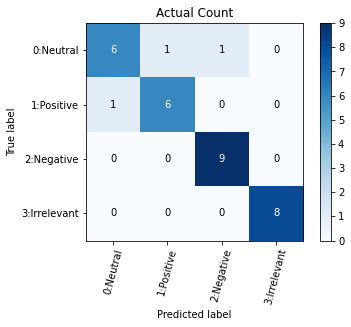

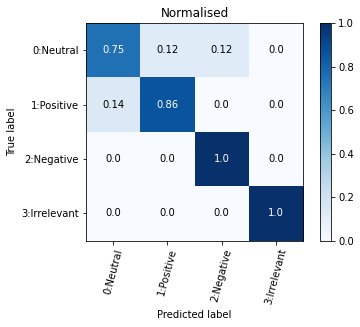

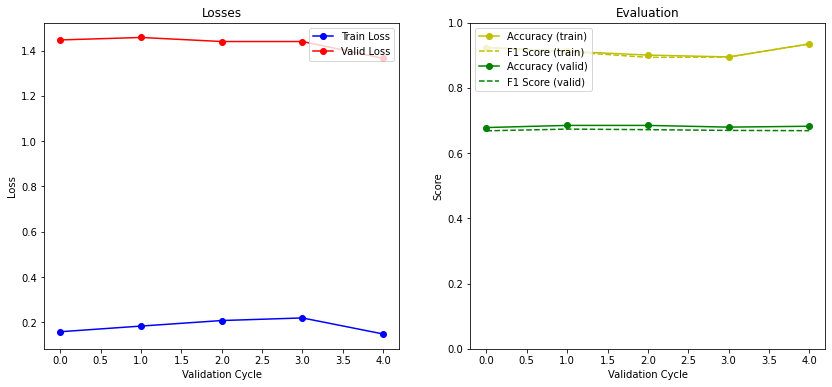

Epoch:   1%|▏         | 1/70 [00:08<09:45,  8.49s/it]

[2022-08-25 15:44:54,255][INFO] ## ================     epoch 2     ===============


INFO:sa_tweet_inperf:================     epoch 2     ===============
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:44:54,930][DEBUG] ## Epoch: 2/70, Step: 57, Loss: 32.3541, Acc: 0.6797, F1: 0.6649


DEBUG:sa_tweet_inperf:Epoch: 2/70, Step: 57, Loss: 32.3541, Acc: 0.6797, F1: 0.6649
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:44:56,260][DEBUG] ## Epoch: 2/70, Step: 66, Loss: 32.6571, Acc: 0.6901, F1: 0.6773


DEBUG:sa_tweet_inperf:Epoch: 2/70, Step: 66, Loss: 32.6571, Acc: 0.6901, F1: 0.6773
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:44:57,759][DEBUG] ## Epoch: 2/70, Step: 77, Loss: 34.9570, Acc: 0.6875, F1: 0.6780


DEBUG:sa_tweet_inperf:Epoch: 2/70, Step: 77, Loss: 34.9570, Acc: 0.6875, F1: 0.6780
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:44:59,275][DEBUG] ## Epoch: 2/70, Step: 88, Loss: 33.6242, Acc: 0.6497, F1: 0.6406


DEBUG:sa_tweet_inperf:Epoch: 2/70, Step: 88, Loss: 33.6242, Acc: 0.6497, F1: 0.6406
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:45:00,783][DEBUG] ## Epoch: 2/70, Step: 99, Loss: 33.2154, Acc: 0.6615, F1: 0.6484


DEBUG:sa_tweet_inperf:Epoch: 2/70, Step: 99, Loss: 33.2154, Acc: 0.6615, F1: 0.6484
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:45:02,288][DEBUG] ## Epoch: 2/70, Step: 110, Loss: 29.0875, Acc: 0.6758, F1: 0.6671


DEBUG:sa_tweet_inperf:Epoch: 2/70, Step: 110, Loss: 29.0875, Acc: 0.6758, F1: 0.6671


[2022-08-25 15:45:02,444][INFO] ## Epoch: 2, Loss: 1.2120, Acc: 0.6758, F1: 0.6671, LR: 8.42e-05


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
INFO:sa_tweet_inperf:Epoch: 2, Loss: 1.2120, Acc: 0.6758, F1: 0.6671, LR: 8.42e-05


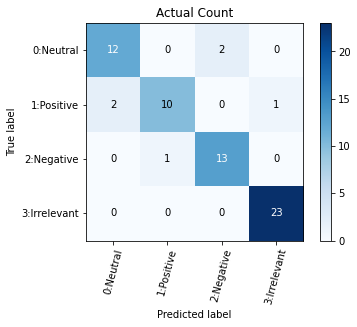

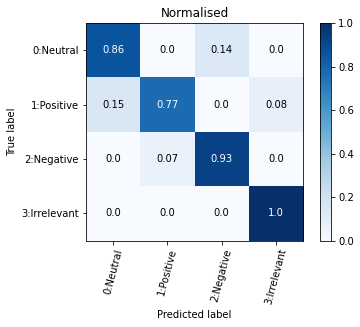

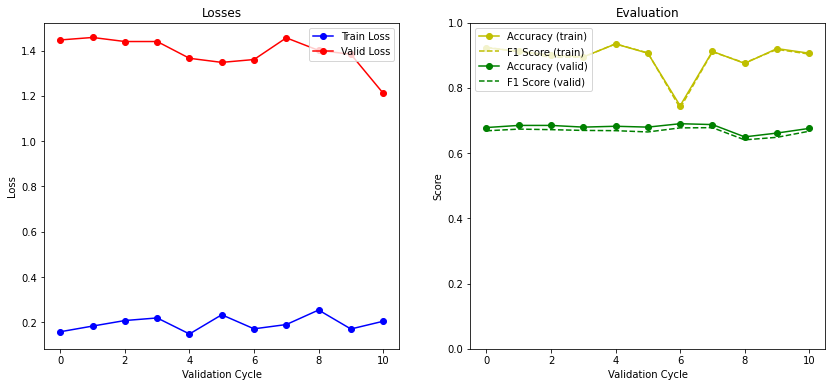

Epoch:   3%|▎         | 2/70 [00:17<09:59,  8.82s/it]

[2022-08-25 15:45:03,304][INFO] ## ================     epoch 3     ===============


INFO:sa_tweet_inperf:================     epoch 3     ===============
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:45:04,653][DEBUG] ## Epoch: 3/70, Step: 121, Loss: 31.3184, Acc: 0.6641, F1: 0.6547


DEBUG:sa_tweet_inperf:Epoch: 3/70, Step: 121, Loss: 31.3184, Acc: 0.6641, F1: 0.6547
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:45:06,169][DEBUG] ## Epoch: 3/70, Step: 132, Loss: 32.2427, Acc: 0.6706, F1: 0.6619


DEBUG:sa_tweet_inperf:Epoch: 3/70, Step: 132, Loss: 32.2427, Acc: 0.6706, F1: 0.6619
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:45:07,701][DEBUG] ## Epoch: 3/70, Step: 143, Loss: 31.1205, Acc: 0.6706, F1: 0.6603


DEBUG:sa_tweet_inperf:Epoch: 3/70, Step: 143, Loss: 31.1205, Acc: 0.6706, F1: 0.6603
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:45:09,223][DEBUG] ## Epoch: 3/70, Step: 154, Loss: 32.1061, Acc: 0.6758, F1: 0.6675


DEBUG:sa_tweet_inperf:Epoch: 3/70, Step: 154, Loss: 32.1061, Acc: 0.6758, F1: 0.6675
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:45:11,107][DEBUG] ## Epoch: 3/70, Step: 165, Loss: 27.8999, Acc: 0.6771, F1: 0.6683


DEBUG:sa_tweet_inperf:Epoch: 3/70, Step: 165, Loss: 27.8999, Acc: 0.6771, F1: 0.6683
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:45:11,358][INFO] ## Epoch: 3, Loss: 1.1625, Acc: 0.6771, F1: 0.6683, LR: 1.26e-04


INFO:sa_tweet_inperf:Epoch: 3, Loss: 1.1625, Acc: 0.6771, F1: 0.6683, LR: 1.26e-04


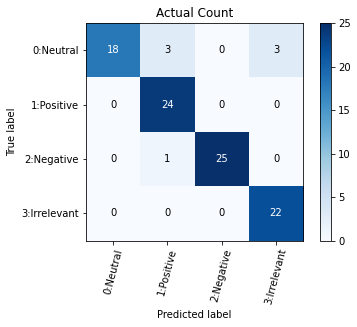

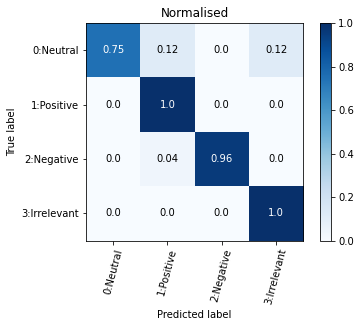

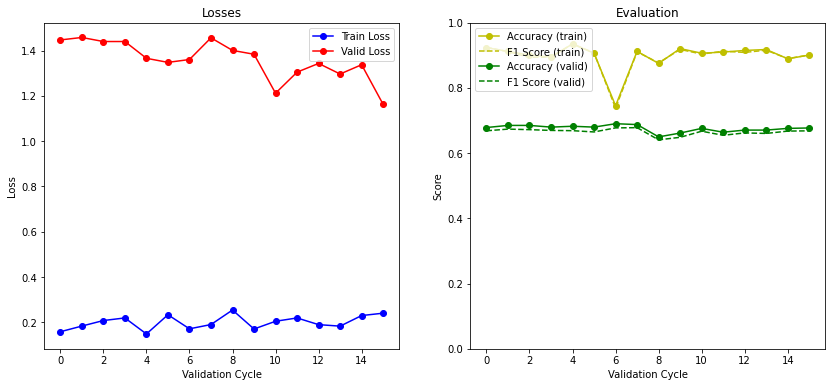

Epoch:   4%|▍         | 3/70 [00:27<10:12,  9.15s/it]

[2022-08-25 15:45:12,858][INFO] ## ================     epoch 4     ===============


INFO:sa_tweet_inperf:================     epoch 4     ===============
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:45:14,124][DEBUG] ## Epoch: 4/70, Step: 176, Loss: 27.7000, Acc: 0.6589, F1: 0.6467


DEBUG:sa_tweet_inperf:Epoch: 4/70, Step: 176, Loss: 27.7000, Acc: 0.6589, F1: 0.6467
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:45:15,648][DEBUG] ## Epoch: 4/70, Step: 187, Loss: 27.3424, Acc: 0.6823, F1: 0.6711


DEBUG:sa_tweet_inperf:Epoch: 4/70, Step: 187, Loss: 27.3424, Acc: 0.6823, F1: 0.6711
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:45:17,173][DEBUG] ## Epoch: 4/70, Step: 198, Loss: 29.0144, Acc: 0.6823, F1: 0.6807


DEBUG:sa_tweet_inperf:Epoch: 4/70, Step: 198, Loss: 29.0144, Acc: 0.6823, F1: 0.6807
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:45:18,702][DEBUG] ## Epoch: 4/70, Step: 209, Loss: 28.9807, Acc: 0.6797, F1: 0.6670


DEBUG:sa_tweet_inperf:Epoch: 4/70, Step: 209, Loss: 28.9807, Acc: 0.6797, F1: 0.6670
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:45:20,225][DEBUG] ## Epoch: 4/70, Step: 220, Loss: 30.3178, Acc: 0.6680, F1: 0.6568


DEBUG:sa_tweet_inperf:Epoch: 4/70, Step: 220, Loss: 30.3178, Acc: 0.6680, F1: 0.6568
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:45:20,548][INFO] ## Epoch: 4, Loss: 1.2632, Acc: 0.6680, F1: 0.6568, LR: 1.68e-04


INFO:sa_tweet_inperf:Epoch: 4, Loss: 1.2632, Acc: 0.6680, F1: 0.6568, LR: 1.68e-04


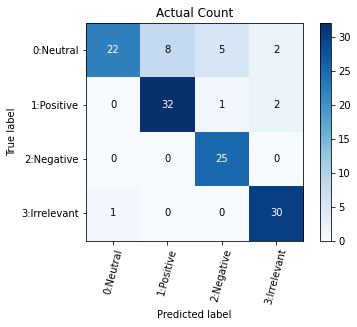

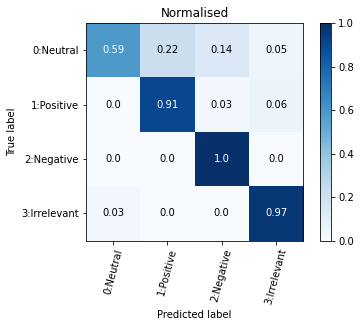

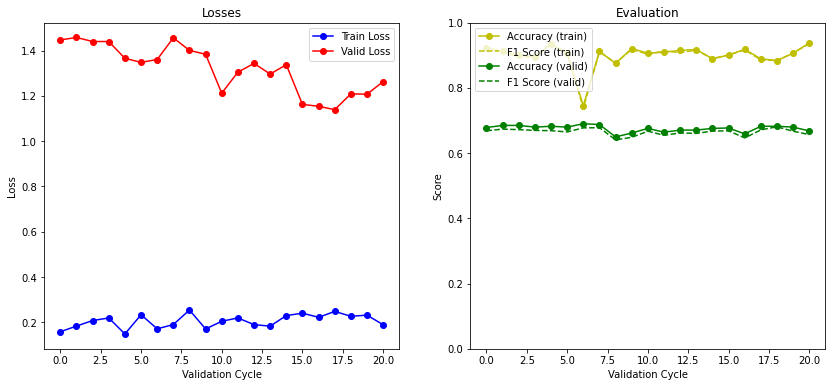

Epoch:   6%|▌         | 4/70 [00:35<09:42,  8.83s/it]

[2022-08-25 15:45:21,181][INFO] ## ================     epoch 5     ===============


INFO:sa_tweet_inperf:================     epoch 5     ===============
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:45:22,387][DEBUG] ## Epoch: 5/70, Step: 231, Loss: 29.4264, Acc: 0.6875, F1: 0.6809


DEBUG:sa_tweet_inperf:Epoch: 5/70, Step: 231, Loss: 29.4264, Acc: 0.6875, F1: 0.6809
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:45:23,924][DEBUG] ## Epoch: 5/70, Step: 242, Loss: 33.2901, Acc: 0.6667, F1: 0.6569


DEBUG:sa_tweet_inperf:Epoch: 5/70, Step: 242, Loss: 33.2901, Acc: 0.6667, F1: 0.6569
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:45:25,455][DEBUG] ## Epoch: 5/70, Step: 253, Loss: 28.1697, Acc: 0.6458, F1: 0.6342


DEBUG:sa_tweet_inperf:Epoch: 5/70, Step: 253, Loss: 28.1697, Acc: 0.6458, F1: 0.6342
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:45:26,992][DEBUG] ## Epoch: 5/70, Step: 264, Loss: 27.1634, Acc: 0.6549, F1: 0.6423


DEBUG:sa_tweet_inperf:Epoch: 5/70, Step: 264, Loss: 27.1634, Acc: 0.6549, F1: 0.6423
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:45:28,527][DEBUG] ## Epoch: 5/70, Step: 275, Loss: 27.1021, Acc: 0.6654, F1: 0.6497


DEBUG:sa_tweet_inperf:Epoch: 5/70, Step: 275, Loss: 27.1021, Acc: 0.6654, F1: 0.6497
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:45:28,940][INFO] ## Epoch: 5, Loss: 1.1293, Acc: 0.6654, F1: 0.6497, LR: 2.11e-04


INFO:sa_tweet_inperf:Epoch: 5, Loss: 1.1293, Acc: 0.6654, F1: 0.6497, LR: 2.11e-04


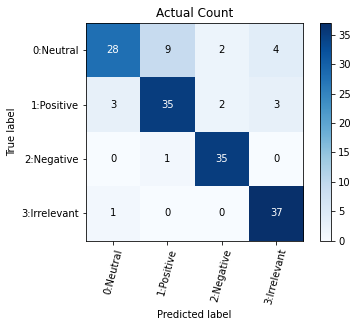

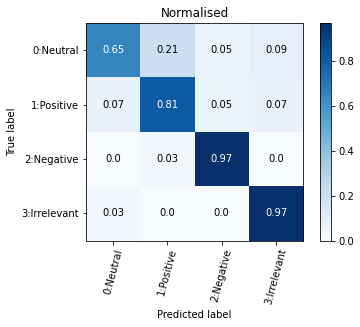

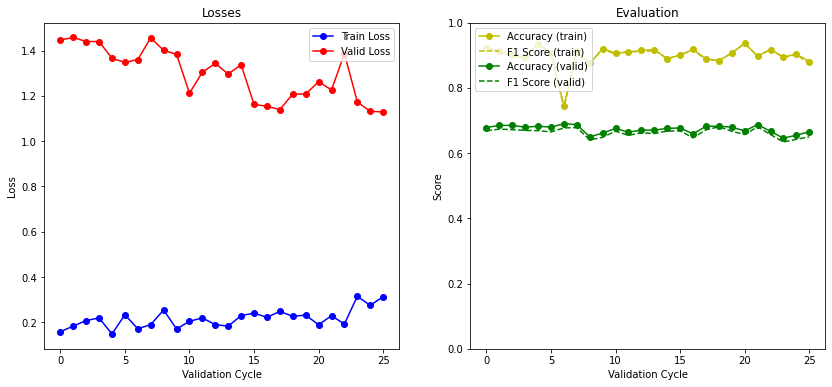

Epoch:   7%|▋         | 5/70 [00:43<09:22,  8.65s/it]

[2022-08-25 15:45:29,530][INFO] ## ================     epoch 6     ===============


INFO:sa_tweet_inperf:================     epoch 6     ===============
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:45:30,655][DEBUG] ## Epoch: 6/70, Step: 286, Loss: 28.5499, Acc: 0.6654, F1: 0.6556


DEBUG:sa_tweet_inperf:Epoch: 6/70, Step: 286, Loss: 28.5499, Acc: 0.6654, F1: 0.6556
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:45:32,208][DEBUG] ## Epoch: 6/70, Step: 297, Loss: 29.5990, Acc: 0.6836, F1: 0.6802


DEBUG:sa_tweet_inperf:Epoch: 6/70, Step: 297, Loss: 29.5990, Acc: 0.6836, F1: 0.6802
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:45:33,752][DEBUG] ## Epoch: 6/70, Step: 308, Loss: 36.4638, Acc: 0.6615, F1: 0.6457


DEBUG:sa_tweet_inperf:Epoch: 6/70, Step: 308, Loss: 36.4638, Acc: 0.6615, F1: 0.6457
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:45:35,301][DEBUG] ## Epoch: 6/70, Step: 319, Loss: 29.9070, Acc: 0.6745, F1: 0.6680


DEBUG:sa_tweet_inperf:Epoch: 6/70, Step: 319, Loss: 29.9070, Acc: 0.6745, F1: 0.6680
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:45:36,860][DEBUG] ## Epoch: 6/70, Step: 330, Loss: 27.4764, Acc: 0.6784, F1: 0.6708


DEBUG:sa_tweet_inperf:Epoch: 6/70, Step: 330, Loss: 27.4764, Acc: 0.6784, F1: 0.6708
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:45:37,361][INFO] ## Epoch: 6, Loss: 1.1448, Acc: 0.6784, F1: 0.6708, LR: 2.53e-04


INFO:sa_tweet_inperf:Epoch: 6, Loss: 1.1448, Acc: 0.6784, F1: 0.6708, LR: 2.53e-04


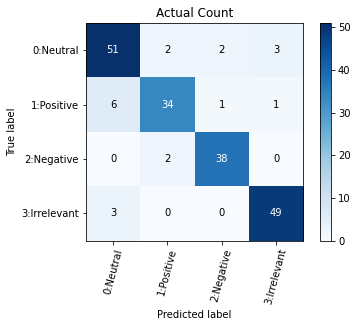

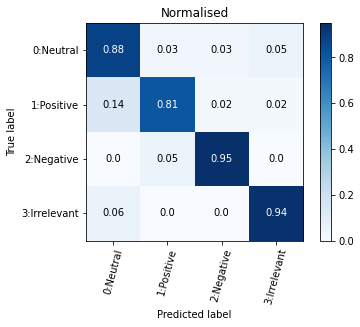

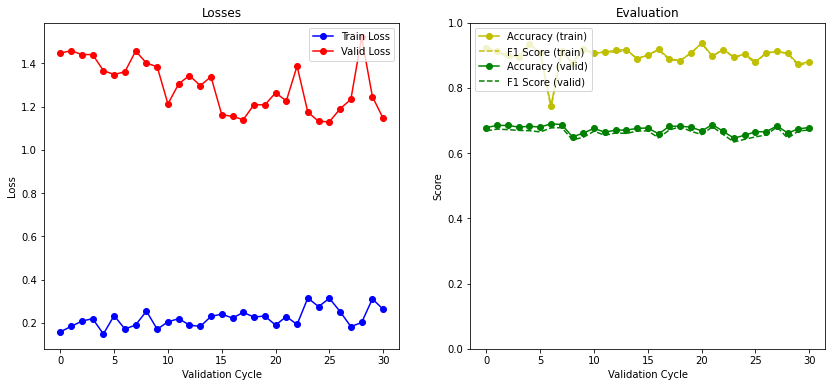

Epoch:   9%|▊         | 6/70 [00:52<09:11,  8.62s/it]

[2022-08-25 15:45:38,091][INFO] ## ================     epoch 7     ===============


INFO:sa_tweet_inperf:================     epoch 7     ===============
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:45:39,129][DEBUG] ## Epoch: 7/70, Step: 341, Loss: 30.3478, Acc: 0.6654, F1: 0.6568


DEBUG:sa_tweet_inperf:Epoch: 7/70, Step: 341, Loss: 30.3478, Acc: 0.6654, F1: 0.6568
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:45:40,688][DEBUG] ## Epoch: 7/70, Step: 352, Loss: 30.3191, Acc: 0.6771, F1: 0.6674


DEBUG:sa_tweet_inperf:Epoch: 7/70, Step: 352, Loss: 30.3191, Acc: 0.6771, F1: 0.6674
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:45:42,239][DEBUG] ## Epoch: 7/70, Step: 363, Loss: 35.8594, Acc: 0.6328, F1: 0.6167


DEBUG:sa_tweet_inperf:Epoch: 7/70, Step: 363, Loss: 35.8594, Acc: 0.6328, F1: 0.6167
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:45:43,790][DEBUG] ## Epoch: 7/70, Step: 374, Loss: 32.3383, Acc: 0.6693, F1: 0.6539


DEBUG:sa_tweet_inperf:Epoch: 7/70, Step: 374, Loss: 32.3383, Acc: 0.6693, F1: 0.6539
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:45:45,347][DEBUG] ## Epoch: 7/70, Step: 385, Loss: 31.0649, Acc: 0.6576, F1: 0.6406


DEBUG:sa_tweet_inperf:Epoch: 7/70, Step: 385, Loss: 31.0649, Acc: 0.6576, F1: 0.6406
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:45:45,936][INFO] ## Epoch: 7, Loss: 1.2944, Acc: 0.6576, F1: 0.6406, LR: 2.95e-04


INFO:sa_tweet_inperf:Epoch: 7, Loss: 1.2944, Acc: 0.6576, F1: 0.6406, LR: 2.95e-04


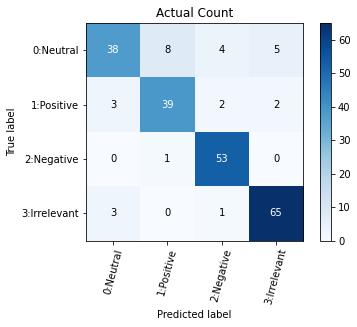

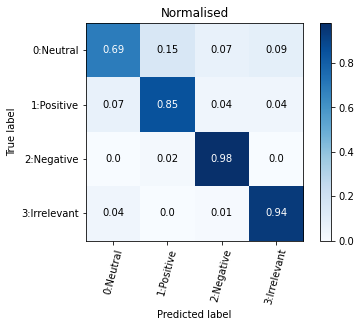

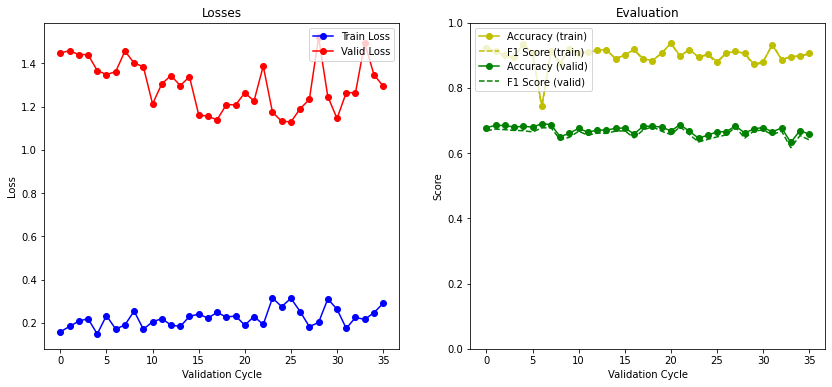

Epoch:  10%|█         | 7/70 [01:00<08:59,  8.57s/it]

[2022-08-25 15:45:46,549][INFO] ## ================     epoch 8     ===============


INFO:sa_tweet_inperf:================     epoch 8     ===============
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:45:47,509][DEBUG] ## Epoch: 8/70, Step: 396, Loss: 26.2069, Acc: 0.6771, F1: 0.6616


DEBUG:sa_tweet_inperf:Epoch: 8/70, Step: 396, Loss: 26.2069, Acc: 0.6771, F1: 0.6616
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:45:49,063][DEBUG] ## Epoch: 8/70, Step: 407, Loss: 29.3346, Acc: 0.6836, F1: 0.6721


DEBUG:sa_tweet_inperf:Epoch: 8/70, Step: 407, Loss: 29.3346, Acc: 0.6836, F1: 0.6721
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:45:50,627][DEBUG] ## Epoch: 8/70, Step: 418, Loss: 24.5085, Acc: 0.6875, F1: 0.6787


DEBUG:sa_tweet_inperf:Epoch: 8/70, Step: 418, Loss: 24.5085, Acc: 0.6875, F1: 0.6787
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:45:52,189][DEBUG] ## Epoch: 8/70, Step: 429, Loss: 27.7842, Acc: 0.6797, F1: 0.6669


DEBUG:sa_tweet_inperf:Epoch: 8/70, Step: 429, Loss: 27.7842, Acc: 0.6797, F1: 0.6669
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:45:53,752][DEBUG] ## Epoch: 8/70, Step: 440, Loss: 29.0838, Acc: 0.6810, F1: 0.6756


DEBUG:sa_tweet_inperf:Epoch: 8/70, Step: 440, Loss: 29.0838, Acc: 0.6810, F1: 0.6756
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:45:54,427][INFO] ## Epoch: 8, Loss: 1.2118, Acc: 0.6810, F1: 0.6756, LR: 2.96e-04


INFO:sa_tweet_inperf:Epoch: 8, Loss: 1.2118, Acc: 0.6810, F1: 0.6756, LR: 2.96e-04


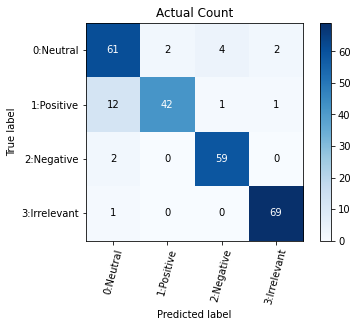

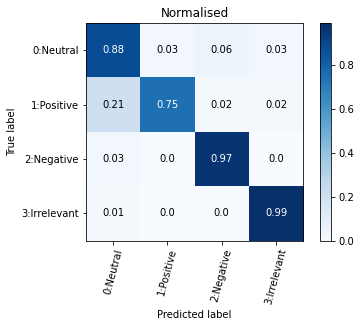

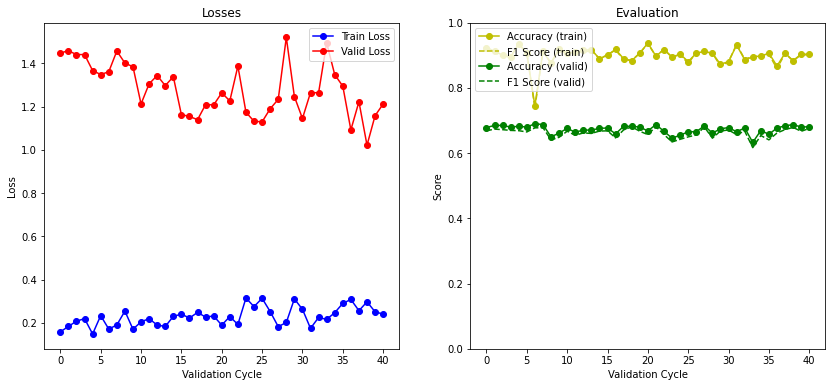

Epoch:  11%|█▏        | 8/70 [01:09<08:49,  8.54s/it]

[2022-08-25 15:45:55,039][INFO] ## ================     epoch 9     ===============


INFO:sa_tweet_inperf:================     epoch 9     ===============
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:45:55,914][DEBUG] ## Epoch: 9/70, Step: 451, Loss: 28.8441, Acc: 0.6849, F1: 0.6725


DEBUG:sa_tweet_inperf:Epoch: 9/70, Step: 451, Loss: 28.8441, Acc: 0.6849, F1: 0.6725
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:45:57,474][DEBUG] ## Epoch: 9/70, Step: 462, Loss: 27.0407, Acc: 0.6849, F1: 0.6721


DEBUG:sa_tweet_inperf:Epoch: 9/70, Step: 462, Loss: 27.0407, Acc: 0.6849, F1: 0.6721
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:45:59,049][DEBUG] ## Epoch: 9/70, Step: 473, Loss: 25.8637, Acc: 0.6823, F1: 0.6710


DEBUG:sa_tweet_inperf:Epoch: 9/70, Step: 473, Loss: 25.8637, Acc: 0.6823, F1: 0.6710
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:46:00,619][DEBUG] ## Epoch: 9/70, Step: 484, Loss: 26.1269, Acc: 0.6927, F1: 0.6812


DEBUG:sa_tweet_inperf:Epoch: 9/70, Step: 484, Loss: 26.1269, Acc: 0.6927, F1: 0.6812
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:46:02,197][DEBUG] ## Epoch: 9/70, Step: 495, Loss: 27.4340, Acc: 0.6810, F1: 0.6709


DEBUG:sa_tweet_inperf:Epoch: 9/70, Step: 495, Loss: 27.4340, Acc: 0.6810, F1: 0.6709
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:46:02,966][INFO] ## Epoch: 9, Loss: 1.1431, Acc: 0.6810, F1: 0.6709, LR: 2.91e-04


INFO:sa_tweet_inperf:Epoch: 9, Loss: 1.1431, Acc: 0.6810, F1: 0.6709, LR: 2.91e-04


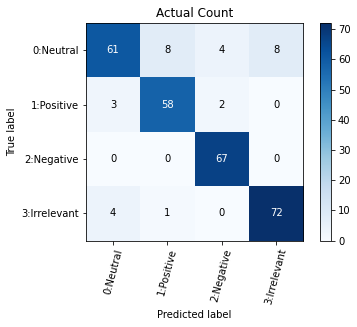

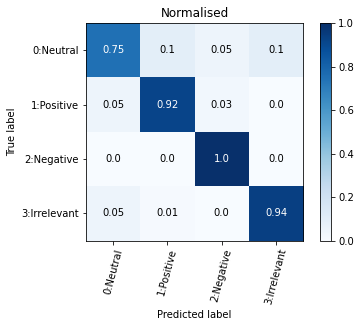

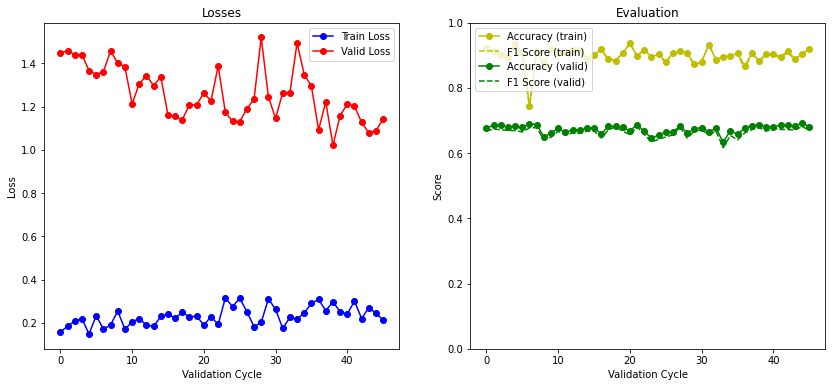

Epoch:  13%|█▎        | 9/70 [01:18<08:45,  8.62s/it]

[2022-08-25 15:46:03,817][INFO] ## ================     epoch 10     ===============


INFO:sa_tweet_inperf:================     epoch 10     ===============
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:46:04,605][DEBUG] ## Epoch: 10/70, Step: 506, Loss: 29.2795, Acc: 0.6745, F1: 0.6690


DEBUG:sa_tweet_inperf:Epoch: 10/70, Step: 506, Loss: 29.2795, Acc: 0.6745, F1: 0.6690
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:46:06,182][DEBUG] ## Epoch: 10/70, Step: 517, Loss: 30.1730, Acc: 0.7031, F1: 0.6928


DEBUG:sa_tweet_inperf:Epoch: 10/70, Step: 517, Loss: 30.1730, Acc: 0.7031, F1: 0.6928
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:46:07,771][DEBUG] ## Epoch: 10/70, Step: 528, Loss: 29.1268, Acc: 0.6927, F1: 0.6865


DEBUG:sa_tweet_inperf:Epoch: 10/70, Step: 528, Loss: 29.1268, Acc: 0.6927, F1: 0.6865
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:46:09,357][DEBUG] ## Epoch: 10/70, Step: 539, Loss: 29.4311, Acc: 0.6862, F1: 0.6777


DEBUG:sa_tweet_inperf:Epoch: 10/70, Step: 539, Loss: 29.4311, Acc: 0.6862, F1: 0.6777
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:46:10,939][DEBUG] ## Epoch: 10/70, Step: 550, Loss: 30.5768, Acc: 0.6823, F1: 0.6736


DEBUG:sa_tweet_inperf:Epoch: 10/70, Step: 550, Loss: 30.5768, Acc: 0.6823, F1: 0.6736
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:46:11,795][INFO] ## Epoch: 10, Loss: 1.2740, Acc: 0.6823, F1: 0.6736, LR: 2.87e-04


INFO:sa_tweet_inperf:Epoch: 10, Loss: 1.2740, Acc: 0.6823, F1: 0.6736, LR: 2.87e-04


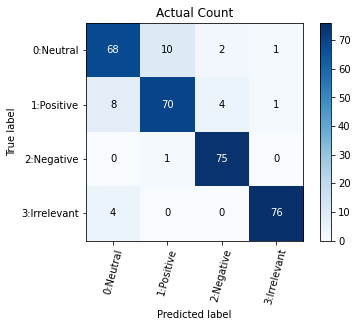

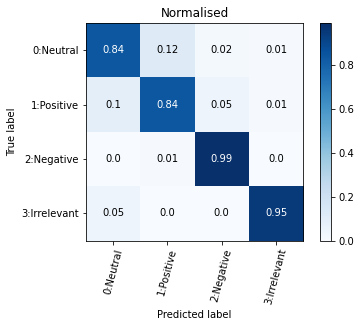

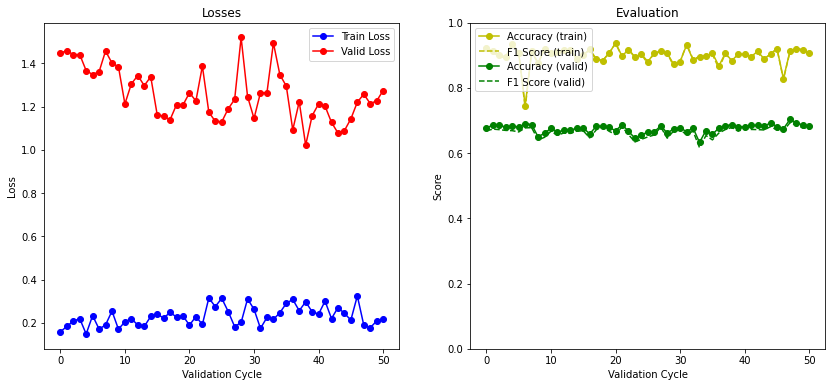

Epoch:  14%|█▍        | 10/70 [01:26<08:36,  8.61s/it]

[2022-08-25 15:46:12,404][INFO] ## ================     epoch 11     ===============


INFO:sa_tweet_inperf:================     epoch 11     ===============
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:46:13,117][DEBUG] ## Epoch: 11/70, Step: 561, Loss: 29.3388, Acc: 0.6797, F1: 0.6709


DEBUG:sa_tweet_inperf:Epoch: 11/70, Step: 561, Loss: 29.3388, Acc: 0.6797, F1: 0.6709
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:46:14,718][DEBUG] ## Epoch: 11/70, Step: 572, Loss: 29.3034, Acc: 0.6888, F1: 0.6790


DEBUG:sa_tweet_inperf:Epoch: 11/70, Step: 572, Loss: 29.3034, Acc: 0.6888, F1: 0.6790
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:46:16,306][DEBUG] ## Epoch: 11/70, Step: 583, Loss: 30.4001, Acc: 0.6836, F1: 0.6723


DEBUG:sa_tweet_inperf:Epoch: 11/70, Step: 583, Loss: 30.4001, Acc: 0.6836, F1: 0.6723
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:46:17,895][DEBUG] ## Epoch: 11/70, Step: 594, Loss: 29.4738, Acc: 0.6979, F1: 0.6870


DEBUG:sa_tweet_inperf:Epoch: 11/70, Step: 594, Loss: 29.4738, Acc: 0.6979, F1: 0.6870
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:46:19,489][DEBUG] ## Epoch: 11/70, Step: 605, Loss: 29.1631, Acc: 0.6888, F1: 0.6822


DEBUG:sa_tweet_inperf:Epoch: 11/70, Step: 605, Loss: 29.1631, Acc: 0.6888, F1: 0.6822
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:46:21,094][DEBUG] ## Epoch: 11/70, Step: 616, Loss: 30.6211, Acc: 0.6875, F1: 0.6792


DEBUG:sa_tweet_inperf:Epoch: 11/70, Step: 616, Loss: 30.6211, Acc: 0.6875, F1: 0.6792


[2022-08-25 15:46:21,104][INFO] ## Epoch: 11, Loss: 1.2759, Acc: 0.6875, F1: 0.6792, LR: 2.82e-04


INFO:sa_tweet_inperf:Epoch: 11, Loss: 1.2759, Acc: 0.6875, F1: 0.6792, LR: 2.82e-04


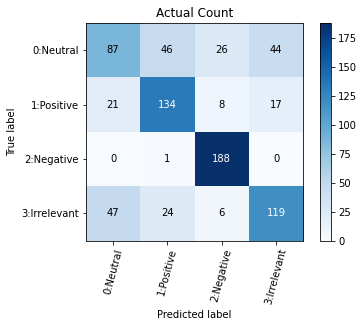

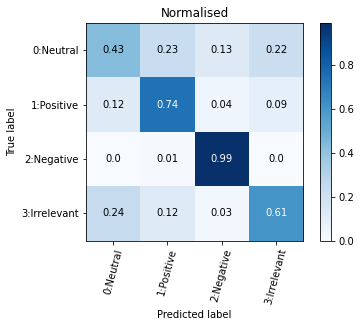

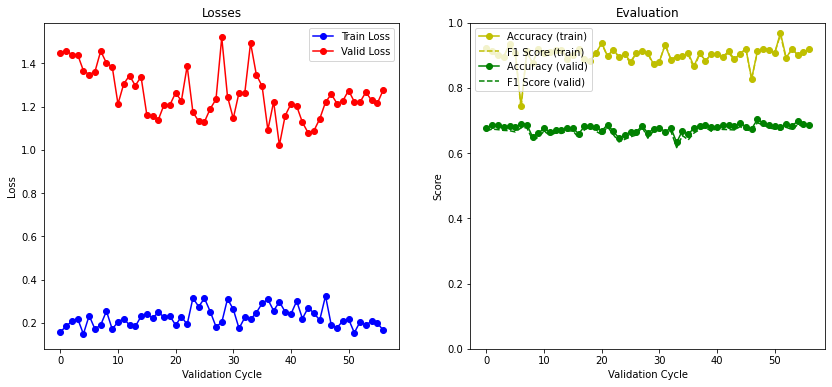

Epoch:  16%|█▌        | 11/70 [01:35<08:40,  8.83s/it]

[2022-08-25 15:46:21,741][INFO] ## ================     epoch 12     ===============


INFO:sa_tweet_inperf:================     epoch 12     ===============
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:46:23,337][DEBUG] ## Epoch: 12/70, Step: 627, Loss: 32.9934, Acc: 0.6784, F1: 0.6704


DEBUG:sa_tweet_inperf:Epoch: 12/70, Step: 627, Loss: 32.9934, Acc: 0.6784, F1: 0.6704
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:46:24,938][DEBUG] ## Epoch: 12/70, Step: 638, Loss: 33.7573, Acc: 0.6836, F1: 0.6753


DEBUG:sa_tweet_inperf:Epoch: 12/70, Step: 638, Loss: 33.7573, Acc: 0.6836, F1: 0.6753
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:46:26,537][DEBUG] ## Epoch: 12/70, Step: 649, Loss: 33.2859, Acc: 0.6823, F1: 0.6735


DEBUG:sa_tweet_inperf:Epoch: 12/70, Step: 649, Loss: 33.2859, Acc: 0.6823, F1: 0.6735
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:46:28,138][DEBUG] ## Epoch: 12/70, Step: 660, Loss: 32.1926, Acc: 0.6901, F1: 0.6797


DEBUG:sa_tweet_inperf:Epoch: 12/70, Step: 660, Loss: 32.1926, Acc: 0.6901, F1: 0.6797
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:46:29,747][DEBUG] ## Epoch: 12/70, Step: 671, Loss: 32.1230, Acc: 0.6901, F1: 0.6798


DEBUG:sa_tweet_inperf:Epoch: 12/70, Step: 671, Loss: 32.1230, Acc: 0.6901, F1: 0.6798


[2022-08-25 15:46:29,823][INFO] ## Epoch: 12, Loss: 1.3385, Acc: 0.6901, F1: 0.6798, LR: 2.77e-04


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
INFO:sa_tweet_inperf:Epoch: 12, Loss: 1.3385, Acc: 0.6901, F1: 0.6798, LR: 2.77e-04


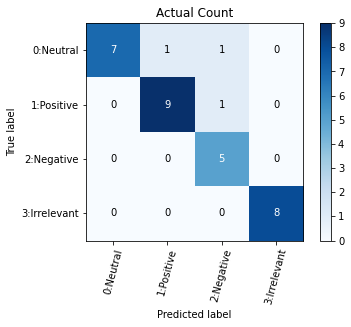

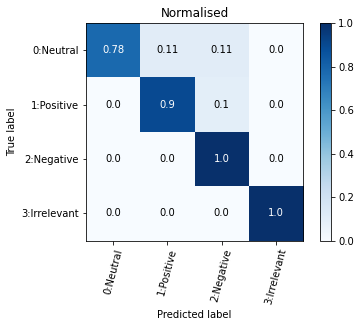

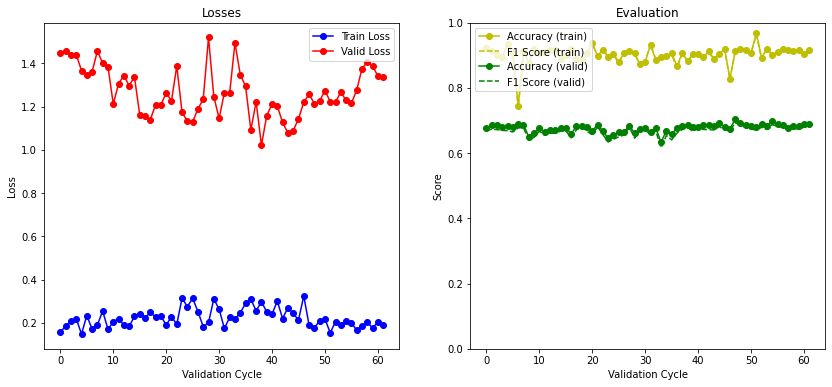

Epoch:  17%|█▋        | 12/70 [01:44<08:30,  8.80s/it]

[2022-08-25 15:46:30,453][INFO] ## ================     epoch 13     ===============


INFO:sa_tweet_inperf:================     epoch 13     ===============
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:46:31,970][DEBUG] ## Epoch: 13/70, Step: 682, Loss: 32.1184, Acc: 0.6992, F1: 0.6903


DEBUG:sa_tweet_inperf:Epoch: 13/70, Step: 682, Loss: 32.1184, Acc: 0.6992, F1: 0.6903
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:46:33,580][DEBUG] ## Epoch: 13/70, Step: 693, Loss: 32.2179, Acc: 0.7005, F1: 0.6935


DEBUG:sa_tweet_inperf:Epoch: 13/70, Step: 693, Loss: 32.2179, Acc: 0.7005, F1: 0.6935
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:46:35,198][DEBUG] ## Epoch: 13/70, Step: 704, Loss: 32.3236, Acc: 0.6966, F1: 0.6869


DEBUG:sa_tweet_inperf:Epoch: 13/70, Step: 704, Loss: 32.3236, Acc: 0.6966, F1: 0.6869
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:46:36,816][DEBUG] ## Epoch: 13/70, Step: 715, Loss: 32.8473, Acc: 0.6953, F1: 0.6879


DEBUG:sa_tweet_inperf:Epoch: 13/70, Step: 715, Loss: 32.8473, Acc: 0.6953, F1: 0.6879
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:46:38,431][DEBUG] ## Epoch: 13/70, Step: 726, Loss: 33.4818, Acc: 0.6966, F1: 0.6899


DEBUG:sa_tweet_inperf:Epoch: 13/70, Step: 726, Loss: 33.4818, Acc: 0.6966, F1: 0.6899


[2022-08-25 15:46:38,601][INFO] ## Epoch: 13, Loss: 1.3951, Acc: 0.6966, F1: 0.6899, LR: 2.73e-04


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
INFO:sa_tweet_inperf:Epoch: 13, Loss: 1.3951, Acc: 0.6966, F1: 0.6899, LR: 2.73e-04


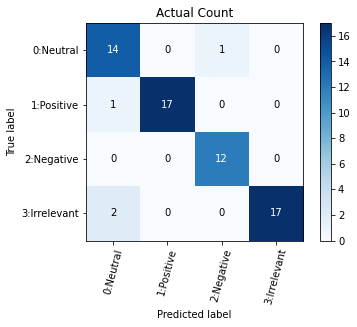

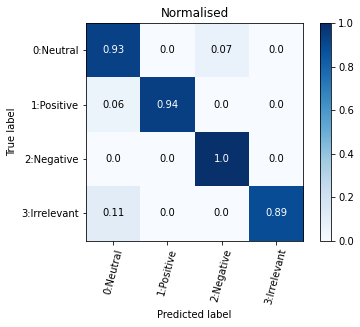

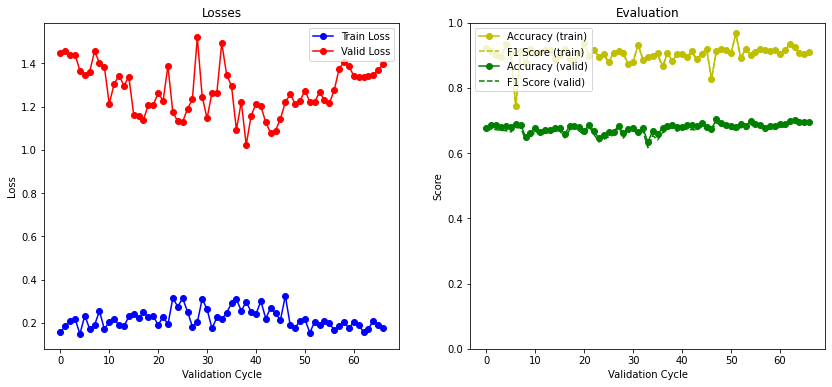

Epoch:  19%|█▊        | 13/70 [01:53<08:21,  8.79s/it]

[2022-08-25 15:46:39,231][INFO] ## ================     epoch 14     ===============


INFO:sa_tweet_inperf:================     epoch 14     ===============
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:46:40,673][DEBUG] ## Epoch: 14/70, Step: 737, Loss: 31.5153, Acc: 0.7018, F1: 0.6914


DEBUG:sa_tweet_inperf:Epoch: 14/70, Step: 737, Loss: 31.5153, Acc: 0.7018, F1: 0.6914
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:46:42,287][DEBUG] ## Epoch: 14/70, Step: 748, Loss: 32.4604, Acc: 0.6979, F1: 0.6916


DEBUG:sa_tweet_inperf:Epoch: 14/70, Step: 748, Loss: 32.4604, Acc: 0.6979, F1: 0.6916
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:46:43,907][DEBUG] ## Epoch: 14/70, Step: 759, Loss: 32.9312, Acc: 0.6914, F1: 0.6861


DEBUG:sa_tweet_inperf:Epoch: 14/70, Step: 759, Loss: 32.9312, Acc: 0.6914, F1: 0.6861
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:46:45,518][DEBUG] ## Epoch: 14/70, Step: 770, Loss: 32.2689, Acc: 0.6953, F1: 0.6870


DEBUG:sa_tweet_inperf:Epoch: 14/70, Step: 770, Loss: 32.2689, Acc: 0.6953, F1: 0.6870
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:46:47,141][DEBUG] ## Epoch: 14/70, Step: 781, Loss: 31.8518, Acc: 0.6979, F1: 0.6851


DEBUG:sa_tweet_inperf:Epoch: 14/70, Step: 781, Loss: 31.8518, Acc: 0.6979, F1: 0.6851
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:46:47,394][INFO] ## Epoch: 14, Loss: 1.3272, Acc: 0.6979, F1: 0.6851, LR: 2.68e-04


INFO:sa_tweet_inperf:Epoch: 14, Loss: 1.3272, Acc: 0.6979, F1: 0.6851, LR: 2.68e-04


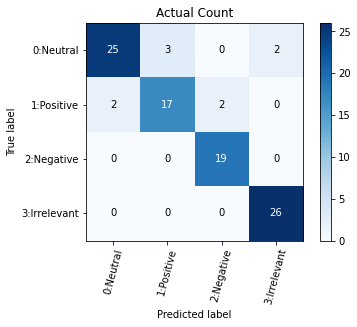

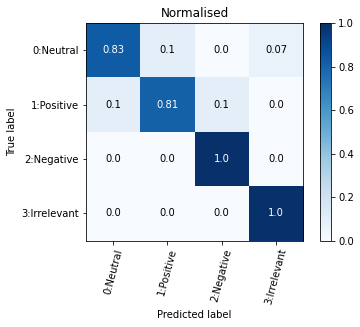

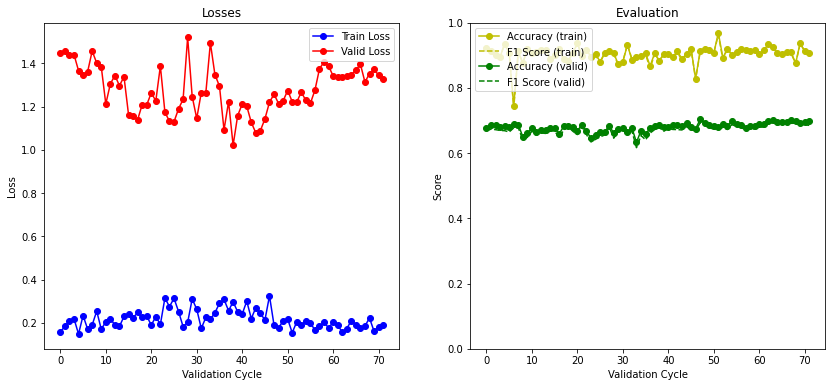

Epoch:  20%|██        | 14/70 [02:02<08:11,  8.79s/it]

[2022-08-25 15:46:48,005][INFO] ## ================     epoch 15     ===============


INFO:sa_tweet_inperf:================     epoch 15     ===============
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:46:49,374][DEBUG] ## Epoch: 15/70, Step: 792, Loss: 32.1169, Acc: 0.6940, F1: 0.6827


DEBUG:sa_tweet_inperf:Epoch: 15/70, Step: 792, Loss: 32.1169, Acc: 0.6940, F1: 0.6827
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:46:51,001][DEBUG] ## Epoch: 15/70, Step: 803, Loss: 32.7571, Acc: 0.6953, F1: 0.6865


DEBUG:sa_tweet_inperf:Epoch: 15/70, Step: 803, Loss: 32.7571, Acc: 0.6953, F1: 0.6865
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:46:52,617][DEBUG] ## Epoch: 15/70, Step: 814, Loss: 33.1042, Acc: 0.6914, F1: 0.6809


DEBUG:sa_tweet_inperf:Epoch: 15/70, Step: 814, Loss: 33.1042, Acc: 0.6914, F1: 0.6809
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:46:54,233][DEBUG] ## Epoch: 15/70, Step: 825, Loss: 32.7129, Acc: 0.7070, F1: 0.6944


DEBUG:sa_tweet_inperf:Epoch: 15/70, Step: 825, Loss: 32.7129, Acc: 0.7070, F1: 0.6944
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:46:55,860][DEBUG] ## Epoch: 15/70, Step: 836, Loss: 32.5098, Acc: 0.6940, F1: 0.6832


DEBUG:sa_tweet_inperf:Epoch: 15/70, Step: 836, Loss: 32.5098, Acc: 0.6940, F1: 0.6832
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:46:56,210][INFO] ## Epoch: 15, Loss: 1.3546, Acc: 0.6940, F1: 0.6832, LR: 2.63e-04


INFO:sa_tweet_inperf:Epoch: 15, Loss: 1.3546, Acc: 0.6940, F1: 0.6832, LR: 2.63e-04


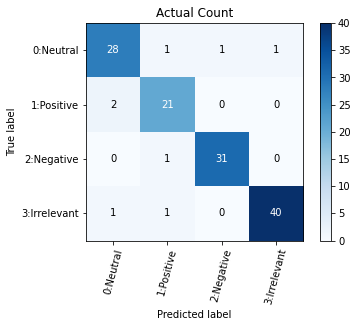

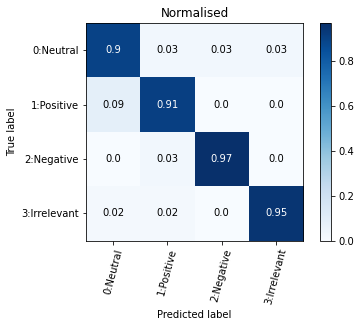

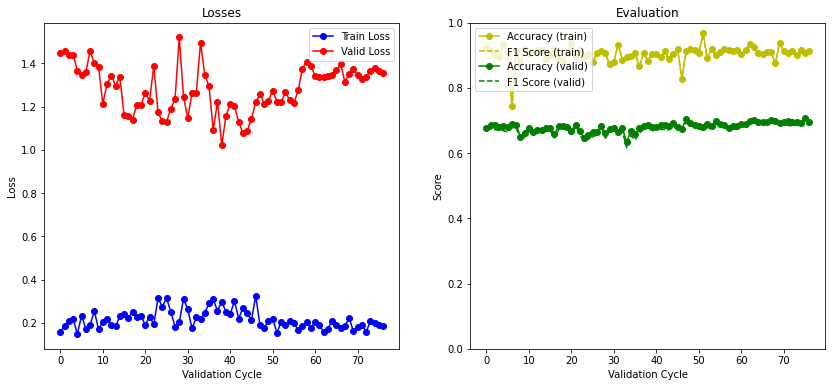

Epoch:  21%|██▏       | 15/70 [02:11<08:04,  8.81s/it]

[2022-08-25 15:46:56,865][INFO] ## ================     epoch 16     ===============


INFO:sa_tweet_inperf:================     epoch 16     ===============
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:46:58,136][DEBUG] ## Epoch: 16/70, Step: 847, Loss: 33.0722, Acc: 0.6927, F1: 0.6793


DEBUG:sa_tweet_inperf:Epoch: 16/70, Step: 847, Loss: 33.0722, Acc: 0.6927, F1: 0.6793
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:46:59,765][DEBUG] ## Epoch: 16/70, Step: 858, Loss: 34.1388, Acc: 0.6914, F1: 0.6783


DEBUG:sa_tweet_inperf:Epoch: 16/70, Step: 858, Loss: 34.1388, Acc: 0.6914, F1: 0.6783
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:47:01,394][DEBUG] ## Epoch: 16/70, Step: 869, Loss: 35.1093, Acc: 0.6862, F1: 0.6771


DEBUG:sa_tweet_inperf:Epoch: 16/70, Step: 869, Loss: 35.1093, Acc: 0.6862, F1: 0.6771
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:47:03,025][DEBUG] ## Epoch: 16/70, Step: 880, Loss: 34.5662, Acc: 0.6875, F1: 0.6796


DEBUG:sa_tweet_inperf:Epoch: 16/70, Step: 880, Loss: 34.5662, Acc: 0.6875, F1: 0.6796
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:47:04,664][DEBUG] ## Epoch: 16/70, Step: 891, Loss: 34.4601, Acc: 0.6901, F1: 0.6816


DEBUG:sa_tweet_inperf:Epoch: 16/70, Step: 891, Loss: 34.4601, Acc: 0.6901, F1: 0.6816
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:47:05,101][INFO] ## Epoch: 16, Loss: 1.4358, Acc: 0.6901, F1: 0.6816, LR: 2.58e-04


INFO:sa_tweet_inperf:Epoch: 16, Loss: 1.4358, Acc: 0.6901, F1: 0.6816, LR: 2.58e-04


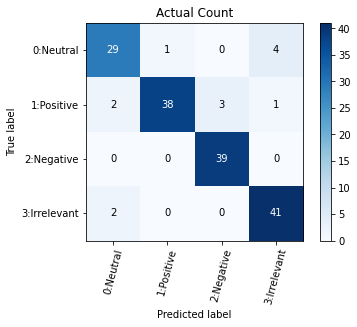

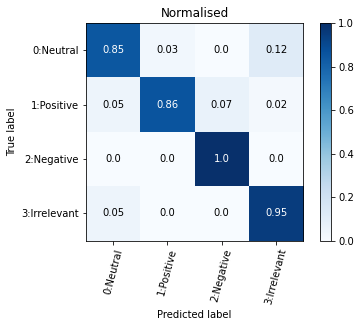

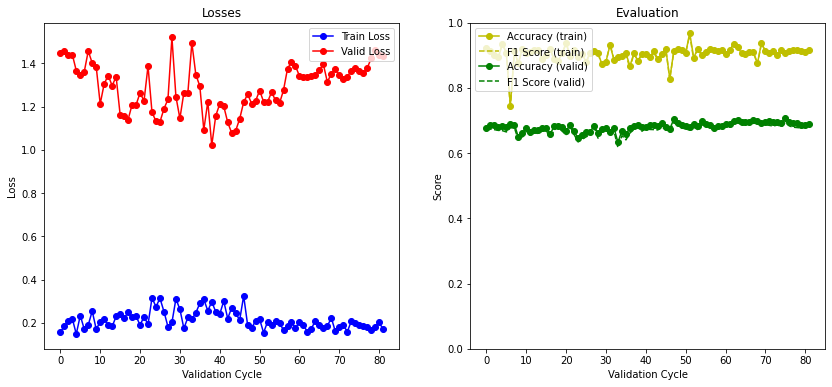

Epoch:  23%|██▎       | 16/70 [02:20<08:00,  8.89s/it]

[2022-08-25 15:47:05,964][INFO] ## ================     epoch 17     ===============


INFO:sa_tweet_inperf:================     epoch 17     ===============
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:47:07,146][DEBUG] ## Epoch: 17/70, Step: 902, Loss: 34.0237, Acc: 0.6901, F1: 0.6809


DEBUG:sa_tweet_inperf:Epoch: 17/70, Step: 902, Loss: 34.0237, Acc: 0.6901, F1: 0.6809
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:47:08,788][DEBUG] ## Epoch: 17/70, Step: 913, Loss: 34.6465, Acc: 0.6927, F1: 0.6827


DEBUG:sa_tweet_inperf:Epoch: 17/70, Step: 913, Loss: 34.6465, Acc: 0.6927, F1: 0.6827
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:47:10,418][DEBUG] ## Epoch: 17/70, Step: 924, Loss: 35.6067, Acc: 0.6979, F1: 0.6881


DEBUG:sa_tweet_inperf:Epoch: 17/70, Step: 924, Loss: 35.6067, Acc: 0.6979, F1: 0.6881
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:47:12,067][DEBUG] ## Epoch: 17/70, Step: 935, Loss: 36.2443, Acc: 0.6953, F1: 0.6858


DEBUG:sa_tweet_inperf:Epoch: 17/70, Step: 935, Loss: 36.2443, Acc: 0.6953, F1: 0.6858
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:47:13,714][DEBUG] ## Epoch: 17/70, Step: 946, Loss: 36.7667, Acc: 0.6901, F1: 0.6851


DEBUG:sa_tweet_inperf:Epoch: 17/70, Step: 946, Loss: 36.7667, Acc: 0.6901, F1: 0.6851
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:47:14,242][INFO] ## Epoch: 17, Loss: 1.5319, Acc: 0.6901, F1: 0.6851, LR: 2.54e-04


INFO:sa_tweet_inperf:Epoch: 17, Loss: 1.5319, Acc: 0.6901, F1: 0.6851, LR: 2.54e-04


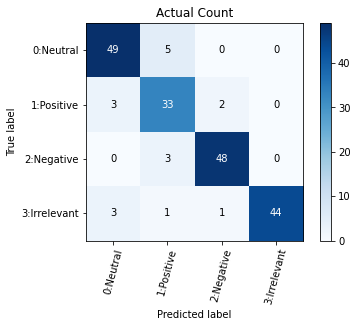

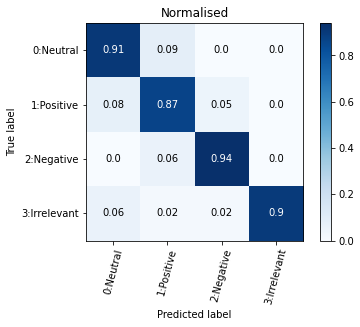

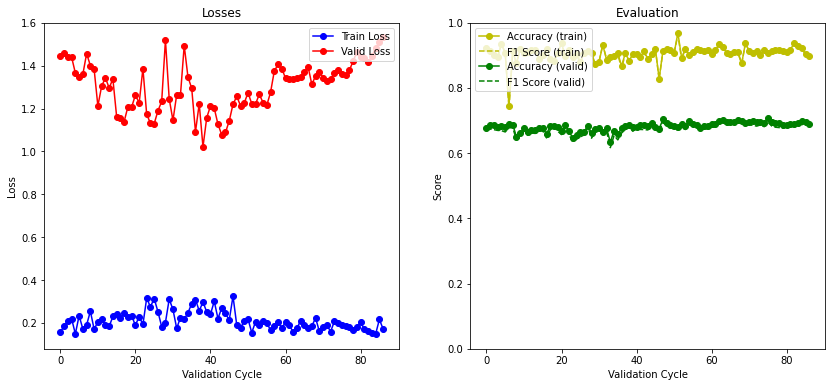

Epoch:  24%|██▍       | 17/70 [02:29<07:51,  8.90s/it]

[2022-08-25 15:47:14,873][INFO] ## ================     epoch 18     ===============


INFO:sa_tweet_inperf:================     epoch 18     ===============
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:47:15,977][DEBUG] ## Epoch: 18/70, Step: 957, Loss: 37.4479, Acc: 0.6875, F1: 0.6813


DEBUG:sa_tweet_inperf:Epoch: 18/70, Step: 957, Loss: 37.4479, Acc: 0.6875, F1: 0.6813
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:47:17,622][DEBUG] ## Epoch: 18/70, Step: 968, Loss: 37.3561, Acc: 0.6914, F1: 0.6836


DEBUG:sa_tweet_inperf:Epoch: 18/70, Step: 968, Loss: 37.3561, Acc: 0.6914, F1: 0.6836
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:47:19,271][DEBUG] ## Epoch: 18/70, Step: 979, Loss: 37.6179, Acc: 0.6953, F1: 0.6854


DEBUG:sa_tweet_inperf:Epoch: 18/70, Step: 979, Loss: 37.6179, Acc: 0.6953, F1: 0.6854
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:47:20,921][DEBUG] ## Epoch: 18/70, Step: 990, Loss: 37.6417, Acc: 0.6940, F1: 0.6844


DEBUG:sa_tweet_inperf:Epoch: 18/70, Step: 990, Loss: 37.6417, Acc: 0.6940, F1: 0.6844
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:47:22,570][DEBUG] ## Epoch: 18/70, Step: 1001, Loss: 35.1110, Acc: 0.6888, F1: 0.6797


DEBUG:sa_tweet_inperf:Epoch: 18/70, Step: 1001, Loss: 35.1110, Acc: 0.6888, F1: 0.6797
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:47:23,194][INFO] ## Epoch: 18, Loss: 1.4630, Acc: 0.6888, F1: 0.6797, LR: 2.49e-04


INFO:sa_tweet_inperf:Epoch: 18, Loss: 1.4630, Acc: 0.6888, F1: 0.6797, LR: 2.49e-04


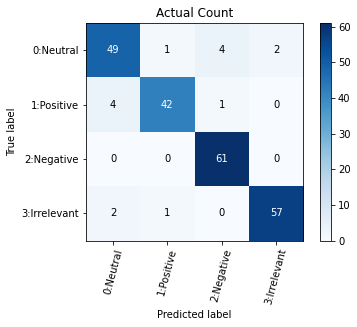

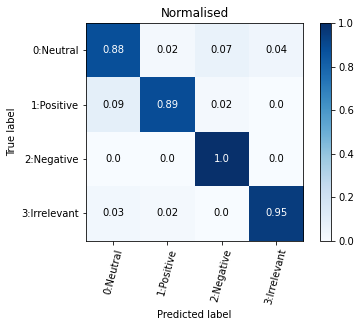

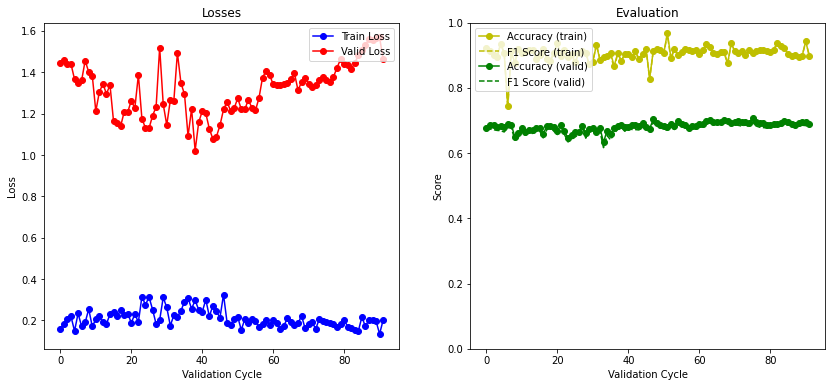

Epoch:  26%|██▌       | 18/70 [02:38<07:43,  8.91s/it]

[2022-08-25 15:47:23,823][INFO] ## ================     epoch 19     ===============


INFO:sa_tweet_inperf:================     epoch 19     ===============
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:47:24,858][DEBUG] ## Epoch: 19/70, Step: 1012, Loss: 33.8354, Acc: 0.6849, F1: 0.6782


DEBUG:sa_tweet_inperf:Epoch: 19/70, Step: 1012, Loss: 33.8354, Acc: 0.6849, F1: 0.6782
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:47:26,510][DEBUG] ## Epoch: 19/70, Step: 1023, Loss: 34.4790, Acc: 0.6849, F1: 0.6763


DEBUG:sa_tweet_inperf:Epoch: 19/70, Step: 1023, Loss: 34.4790, Acc: 0.6849, F1: 0.6763
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:47:28,169][DEBUG] ## Epoch: 19/70, Step: 1034, Loss: 35.6707, Acc: 0.6914, F1: 0.6829


DEBUG:sa_tweet_inperf:Epoch: 19/70, Step: 1034, Loss: 35.6707, Acc: 0.6914, F1: 0.6829
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:47:29,830][DEBUG] ## Epoch: 19/70, Step: 1045, Loss: 36.7837, Acc: 0.6953, F1: 0.6834


DEBUG:sa_tweet_inperf:Epoch: 19/70, Step: 1045, Loss: 36.7837, Acc: 0.6953, F1: 0.6834
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:47:31,481][DEBUG] ## Epoch: 19/70, Step: 1056, Loss: 36.9049, Acc: 0.6927, F1: 0.6802


DEBUG:sa_tweet_inperf:Epoch: 19/70, Step: 1056, Loss: 36.9049, Acc: 0.6927, F1: 0.6802
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:47:32,191][INFO] ## Epoch: 19, Loss: 1.5377, Acc: 0.6927, F1: 0.6802, LR: 2.44e-04


INFO:sa_tweet_inperf:Epoch: 19, Loss: 1.5377, Acc: 0.6927, F1: 0.6802, LR: 2.44e-04


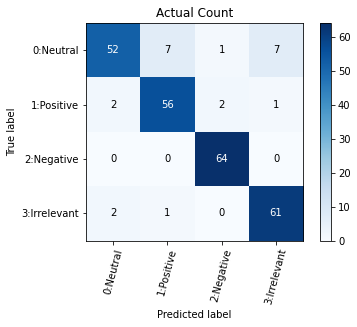

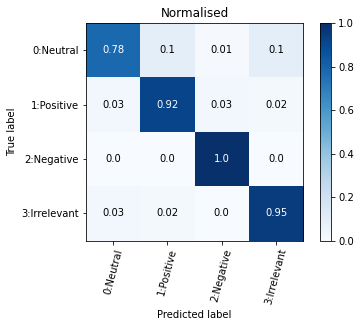

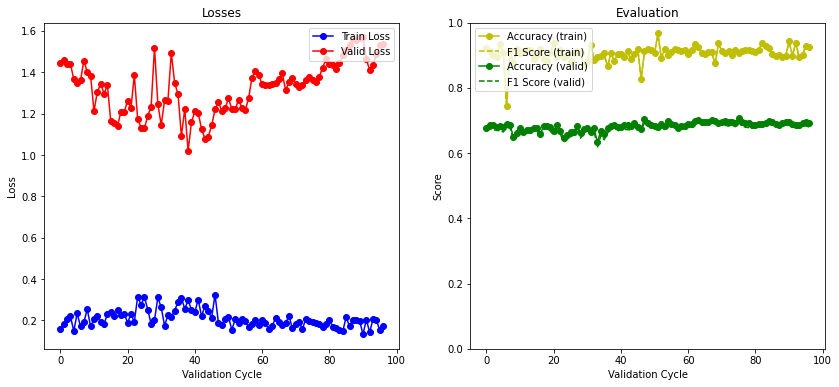

Epoch:  27%|██▋       | 19/70 [02:47<07:36,  8.94s/it]

[2022-08-25 15:47:32,825][INFO] ## ================     epoch 20     ===============


INFO:sa_tweet_inperf:================     epoch 20     ===============
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:47:33,766][DEBUG] ## Epoch: 20/70, Step: 1067, Loss: 36.6120, Acc: 0.6875, F1: 0.6773


DEBUG:sa_tweet_inperf:Epoch: 20/70, Step: 1067, Loss: 36.6120, Acc: 0.6875, F1: 0.6773
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:47:35,417][DEBUG] ## Epoch: 20/70, Step: 1078, Loss: 36.7024, Acc: 0.6862, F1: 0.6759


DEBUG:sa_tweet_inperf:Epoch: 20/70, Step: 1078, Loss: 36.7024, Acc: 0.6862, F1: 0.6759
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:47:37,076][DEBUG] ## Epoch: 20/70, Step: 1089, Loss: 36.5801, Acc: 0.6888, F1: 0.6793


DEBUG:sa_tweet_inperf:Epoch: 20/70, Step: 1089, Loss: 36.5801, Acc: 0.6888, F1: 0.6793
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:47:38,749][DEBUG] ## Epoch: 20/70, Step: 1100, Loss: 36.4679, Acc: 0.6901, F1: 0.6808


DEBUG:sa_tweet_inperf:Epoch: 20/70, Step: 1100, Loss: 36.4679, Acc: 0.6901, F1: 0.6808
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:47:40,416][DEBUG] ## Epoch: 20/70, Step: 1111, Loss: 36.4955, Acc: 0.6901, F1: 0.6806


DEBUG:sa_tweet_inperf:Epoch: 20/70, Step: 1111, Loss: 36.4955, Acc: 0.6901, F1: 0.6806
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:47:41,217][INFO] ## Epoch: 20, Loss: 1.5206, Acc: 0.6901, F1: 0.6806, LR: 2.40e-04


INFO:sa_tweet_inperf:Epoch: 20, Loss: 1.5206, Acc: 0.6901, F1: 0.6806, LR: 2.40e-04


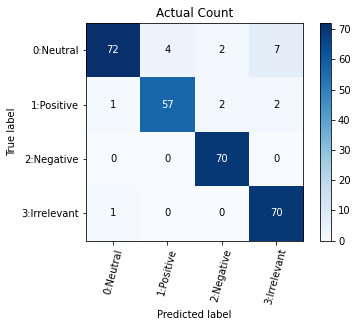

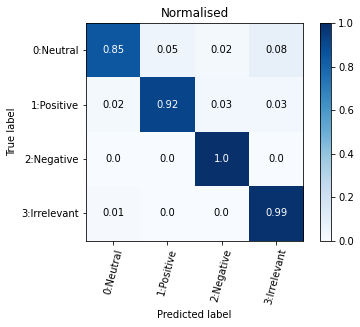

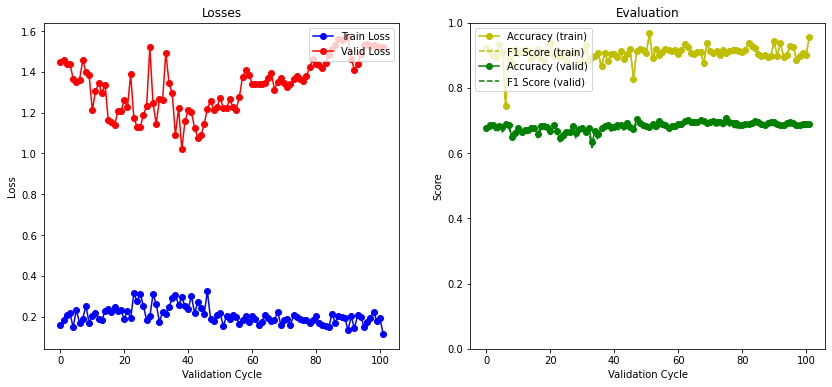

Epoch:  29%|██▊       | 20/70 [02:56<07:28,  8.97s/it]

[2022-08-25 15:47:41,857][INFO] ## ================     epoch 21     ===============


INFO:sa_tweet_inperf:================     epoch 21     ===============
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:47:42,691][DEBUG] ## Epoch: 21/70, Step: 1122, Loss: 37.1101, Acc: 0.6927, F1: 0.6819


DEBUG:sa_tweet_inperf:Epoch: 21/70, Step: 1122, Loss: 37.1101, Acc: 0.6927, F1: 0.6819
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:47:44,363][DEBUG] ## Epoch: 21/70, Step: 1133, Loss: 38.0353, Acc: 0.6888, F1: 0.6789


DEBUG:sa_tweet_inperf:Epoch: 21/70, Step: 1133, Loss: 38.0353, Acc: 0.6888, F1: 0.6789
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:47:46,021][DEBUG] ## Epoch: 21/70, Step: 1144, Loss: 38.6350, Acc: 0.6914, F1: 0.6828


DEBUG:sa_tweet_inperf:Epoch: 21/70, Step: 1144, Loss: 38.6350, Acc: 0.6914, F1: 0.6828
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:47:47,694][DEBUG] ## Epoch: 21/70, Step: 1155, Loss: 38.0273, Acc: 0.6901, F1: 0.6812


DEBUG:sa_tweet_inperf:Epoch: 21/70, Step: 1155, Loss: 38.0273, Acc: 0.6901, F1: 0.6812
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:47:49,358][DEBUG] ## Epoch: 21/70, Step: 1166, Loss: 37.1000, Acc: 0.6927, F1: 0.6827


DEBUG:sa_tweet_inperf:Epoch: 21/70, Step: 1166, Loss: 37.1000, Acc: 0.6927, F1: 0.6827
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:47:50,252][INFO] ## Epoch: 21, Loss: 1.5458, Acc: 0.6927, F1: 0.6827, LR: 2.35e-04


INFO:sa_tweet_inperf:Epoch: 21, Loss: 1.5458, Acc: 0.6927, F1: 0.6827, LR: 2.35e-04


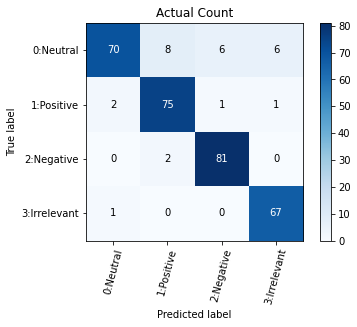

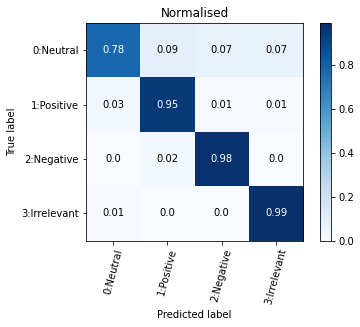

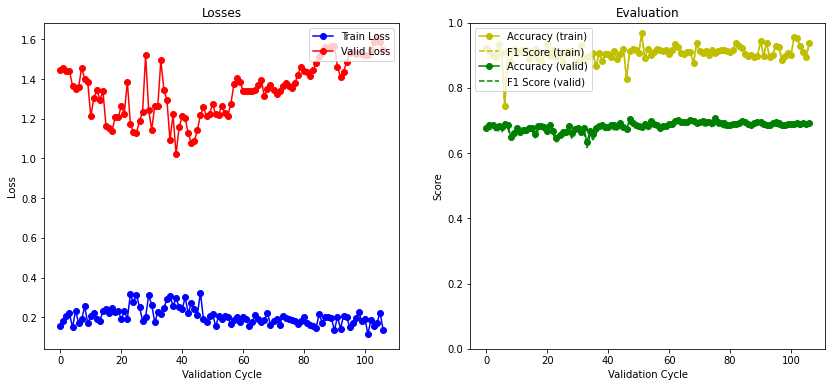

Epoch:  30%|███       | 21/70 [03:05<07:20,  8.99s/it]

[2022-08-25 15:47:50,907][INFO] ## ================     epoch 22     ===============


INFO:sa_tweet_inperf:================     epoch 22     ===============
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:47:51,644][DEBUG] ## Epoch: 22/70, Step: 1177, Loss: 36.9434, Acc: 0.6927, F1: 0.6828


DEBUG:sa_tweet_inperf:Epoch: 22/70, Step: 1177, Loss: 36.9434, Acc: 0.6927, F1: 0.6828
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:47:53,324][DEBUG] ## Epoch: 22/70, Step: 1188, Loss: 37.6044, Acc: 0.6914, F1: 0.6818


DEBUG:sa_tweet_inperf:Epoch: 22/70, Step: 1188, Loss: 37.6044, Acc: 0.6914, F1: 0.6818
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:47:54,984][DEBUG] ## Epoch: 22/70, Step: 1199, Loss: 38.4205, Acc: 0.6914, F1: 0.6819


DEBUG:sa_tweet_inperf:Epoch: 22/70, Step: 1199, Loss: 38.4205, Acc: 0.6914, F1: 0.6819
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:47:56,648][DEBUG] ## Epoch: 22/70, Step: 1210, Loss: 38.8232, Acc: 0.6901, F1: 0.6835


DEBUG:sa_tweet_inperf:Epoch: 22/70, Step: 1210, Loss: 38.8232, Acc: 0.6901, F1: 0.6835
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:47:58,314][DEBUG] ## Epoch: 22/70, Step: 1221, Loss: 39.3286, Acc: 0.6888, F1: 0.6787


DEBUG:sa_tweet_inperf:Epoch: 22/70, Step: 1221, Loss: 39.3286, Acc: 0.6888, F1: 0.6787
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:47:59,977][DEBUG] ## Epoch: 22/70, Step: 1232, Loss: 37.7349, Acc: 0.6875, F1: 0.6776


DEBUG:sa_tweet_inperf:Epoch: 22/70, Step: 1232, Loss: 37.7349, Acc: 0.6875, F1: 0.6776


[2022-08-25 15:47:59,986][INFO] ## Epoch: 22, Loss: 1.5723, Acc: 0.6875, F1: 0.6776, LR: 2.30e-04


INFO:sa_tweet_inperf:Epoch: 22, Loss: 1.5723, Acc: 0.6875, F1: 0.6776, LR: 2.30e-04


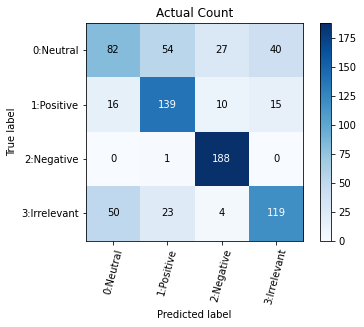

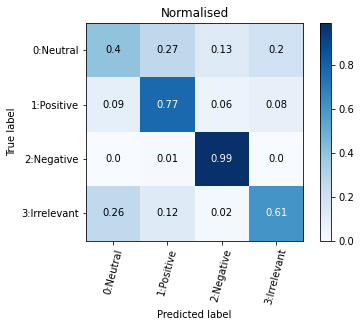

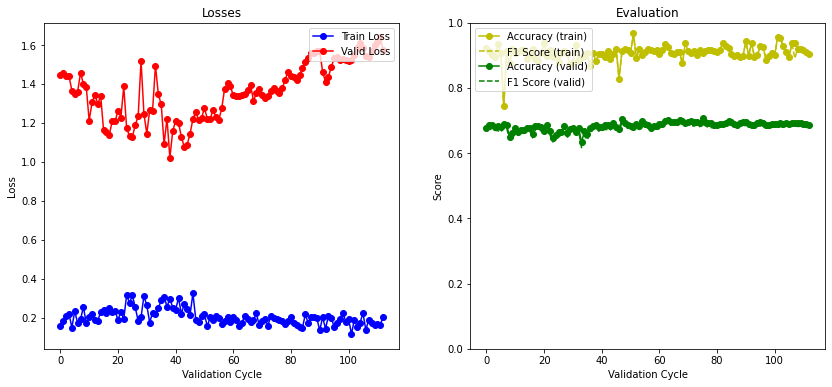

Epoch:  31%|███▏      | 22/70 [03:14<07:22,  9.22s/it]

[2022-08-25 15:48:00,662][INFO] ## ================     epoch 23     ===============


INFO:sa_tweet_inperf:================     epoch 23     ===============
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:48:02,327][DEBUG] ## Epoch: 23/70, Step: 1243, Loss: 36.3509, Acc: 0.6901, F1: 0.6812


DEBUG:sa_tweet_inperf:Epoch: 23/70, Step: 1243, Loss: 36.3509, Acc: 0.6901, F1: 0.6812
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:48:04,000][DEBUG] ## Epoch: 23/70, Step: 1254, Loss: 36.2384, Acc: 0.6901, F1: 0.6819


DEBUG:sa_tweet_inperf:Epoch: 23/70, Step: 1254, Loss: 36.2384, Acc: 0.6901, F1: 0.6819
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:48:05,672][DEBUG] ## Epoch: 23/70, Step: 1265, Loss: 36.4981, Acc: 0.6862, F1: 0.6766


DEBUG:sa_tweet_inperf:Epoch: 23/70, Step: 1265, Loss: 36.4981, Acc: 0.6862, F1: 0.6766
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:48:07,344][DEBUG] ## Epoch: 23/70, Step: 1276, Loss: 36.9810, Acc: 0.6888, F1: 0.6766


DEBUG:sa_tweet_inperf:Epoch: 23/70, Step: 1276, Loss: 36.9810, Acc: 0.6888, F1: 0.6766
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:48:09,014][DEBUG] ## Epoch: 23/70, Step: 1287, Loss: 37.1000, Acc: 0.6862, F1: 0.6753


DEBUG:sa_tweet_inperf:Epoch: 23/70, Step: 1287, Loss: 37.1000, Acc: 0.6862, F1: 0.6753


[2022-08-25 15:48:09,094][INFO] ## Epoch: 23, Loss: 1.5458, Acc: 0.6862, F1: 0.6753, LR: 2.26e-04


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
INFO:sa_tweet_inperf:Epoch: 23, Loss: 1.5458, Acc: 0.6862, F1: 0.6753, LR: 2.26e-04


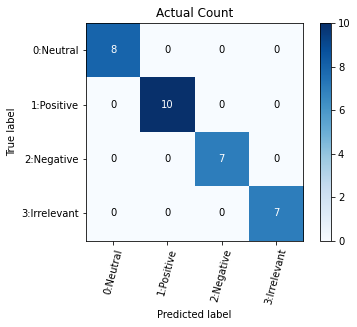

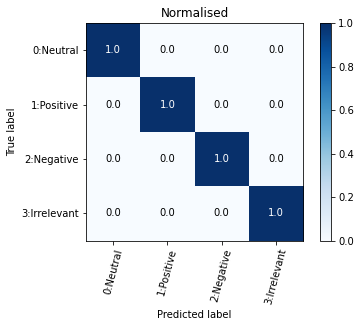

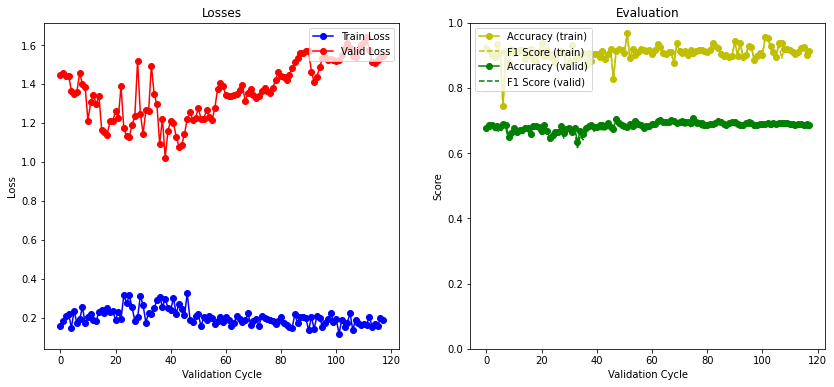

Epoch:  33%|███▎      | 23/70 [03:24<07:14,  9.25s/it]

[2022-08-25 15:48:09,973][INFO] ## ================     epoch 24     ===============


INFO:sa_tweet_inperf:================     epoch 24     ===============
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:48:11,549][DEBUG] ## Epoch: 24/70, Step: 1298, Loss: 37.1766, Acc: 0.6966, F1: 0.6860


DEBUG:sa_tweet_inperf:Epoch: 24/70, Step: 1298, Loss: 37.1766, Acc: 0.6966, F1: 0.6860
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:48:13,216][DEBUG] ## Epoch: 24/70, Step: 1309, Loss: 37.1283, Acc: 0.6940, F1: 0.6839


DEBUG:sa_tweet_inperf:Epoch: 24/70, Step: 1309, Loss: 37.1283, Acc: 0.6940, F1: 0.6839
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:48:14,889][DEBUG] ## Epoch: 24/70, Step: 1320, Loss: 37.2276, Acc: 0.6901, F1: 0.6792


DEBUG:sa_tweet_inperf:Epoch: 24/70, Step: 1320, Loss: 37.2276, Acc: 0.6901, F1: 0.6792
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:48:16,556][DEBUG] ## Epoch: 24/70, Step: 1331, Loss: 37.4935, Acc: 0.6888, F1: 0.6791


DEBUG:sa_tweet_inperf:Epoch: 24/70, Step: 1331, Loss: 37.4935, Acc: 0.6888, F1: 0.6791
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:48:18,223][DEBUG] ## Epoch: 24/70, Step: 1342, Loss: 38.7311, Acc: 0.6888, F1: 0.6821


DEBUG:sa_tweet_inperf:Epoch: 24/70, Step: 1342, Loss: 38.7311, Acc: 0.6888, F1: 0.6821


[2022-08-25 15:48:18,389][INFO] ## Epoch: 24, Loss: 1.6138, Acc: 0.6888, F1: 0.6821, LR: 2.21e-04


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
INFO:sa_tweet_inperf:Epoch: 24, Loss: 1.6138, Acc: 0.6888, F1: 0.6821, LR: 2.21e-04


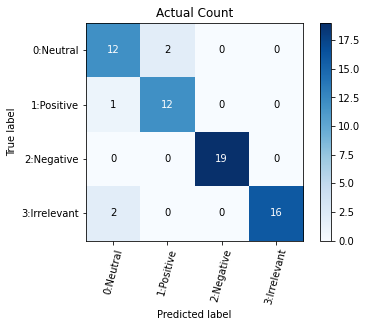

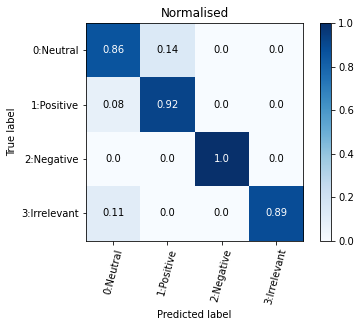

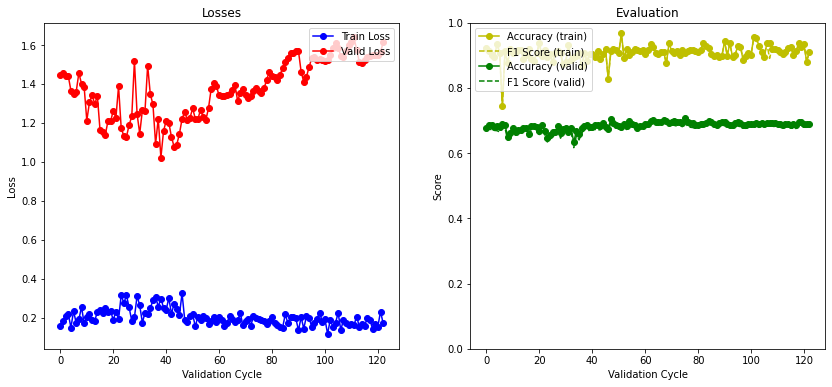

Epoch:  34%|███▍      | 24/70 [03:33<07:02,  9.19s/it]

[2022-08-25 15:48:19,037][INFO] ## ================     epoch 25     ===============


INFO:sa_tweet_inperf:================     epoch 25     ===============
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:48:20,523][DEBUG] ## Epoch: 25/70, Step: 1353, Loss: 36.3812, Acc: 0.6927, F1: 0.6797


DEBUG:sa_tweet_inperf:Epoch: 25/70, Step: 1353, Loss: 36.3812, Acc: 0.6927, F1: 0.6797
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:48:22,210][DEBUG] ## Epoch: 25/70, Step: 1364, Loss: 36.2715, Acc: 0.7018, F1: 0.6884


DEBUG:sa_tweet_inperf:Epoch: 25/70, Step: 1364, Loss: 36.2715, Acc: 0.7018, F1: 0.6884
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:48:23,891][DEBUG] ## Epoch: 25/70, Step: 1375, Loss: 36.7814, Acc: 0.6992, F1: 0.6869


DEBUG:sa_tweet_inperf:Epoch: 25/70, Step: 1375, Loss: 36.7814, Acc: 0.6992, F1: 0.6869
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:48:25,564][DEBUG] ## Epoch: 25/70, Step: 1386, Loss: 37.5535, Acc: 0.6888, F1: 0.6788


DEBUG:sa_tweet_inperf:Epoch: 25/70, Step: 1386, Loss: 37.5535, Acc: 0.6888, F1: 0.6788
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:48:27,246][DEBUG] ## Epoch: 25/70, Step: 1397, Loss: 36.7954, Acc: 0.6927, F1: 0.6841


DEBUG:sa_tweet_inperf:Epoch: 25/70, Step: 1397, Loss: 36.7954, Acc: 0.6927, F1: 0.6841
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:48:27,507][INFO] ## Epoch: 25, Loss: 1.5331, Acc: 0.6927, F1: 0.6841, LR: 2.16e-04


INFO:sa_tweet_inperf:Epoch: 25, Loss: 1.5331, Acc: 0.6927, F1: 0.6841, LR: 2.16e-04


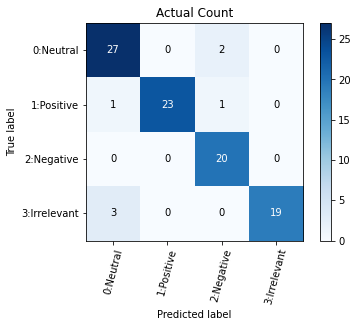

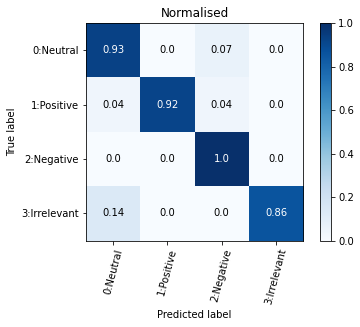

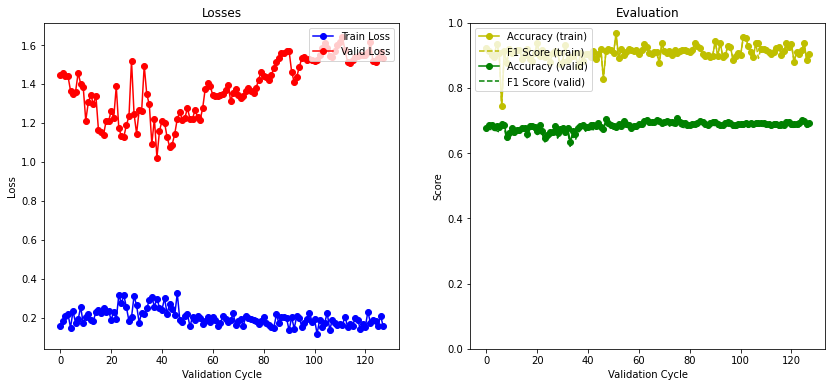

Epoch:  36%|███▌      | 25/70 [03:42<06:52,  9.17s/it]

[2022-08-25 15:48:28,145][INFO] ## ================     epoch 26     ===============


INFO:sa_tweet_inperf:================     epoch 26     ===============
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:48:29,546][DEBUG] ## Epoch: 26/70, Step: 1408, Loss: 36.4659, Acc: 0.6914, F1: 0.6830


DEBUG:sa_tweet_inperf:Epoch: 26/70, Step: 1408, Loss: 36.4659, Acc: 0.6914, F1: 0.6830
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:48:31,227][DEBUG] ## Epoch: 26/70, Step: 1419, Loss: 36.8269, Acc: 0.6927, F1: 0.6851


DEBUG:sa_tweet_inperf:Epoch: 26/70, Step: 1419, Loss: 36.8269, Acc: 0.6927, F1: 0.6851
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:48:32,901][DEBUG] ## Epoch: 26/70, Step: 1430, Loss: 36.9305, Acc: 0.7005, F1: 0.6908


DEBUG:sa_tweet_inperf:Epoch: 26/70, Step: 1430, Loss: 36.9305, Acc: 0.7005, F1: 0.6908
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:48:34,587][DEBUG] ## Epoch: 26/70, Step: 1441, Loss: 37.2624, Acc: 0.7031, F1: 0.6918


DEBUG:sa_tweet_inperf:Epoch: 26/70, Step: 1441, Loss: 37.2624, Acc: 0.7031, F1: 0.6918
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:48:36,266][DEBUG] ## Epoch: 26/70, Step: 1452, Loss: 37.3406, Acc: 0.6979, F1: 0.6896


DEBUG:sa_tweet_inperf:Epoch: 26/70, Step: 1452, Loss: 37.3406, Acc: 0.6979, F1: 0.6896
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:48:36,616][INFO] ## Epoch: 26, Loss: 1.5559, Acc: 0.6979, F1: 0.6896, LR: 2.12e-04


INFO:sa_tweet_inperf:Epoch: 26, Loss: 1.5559, Acc: 0.6979, F1: 0.6896, LR: 2.12e-04


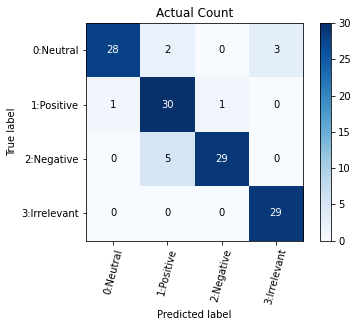

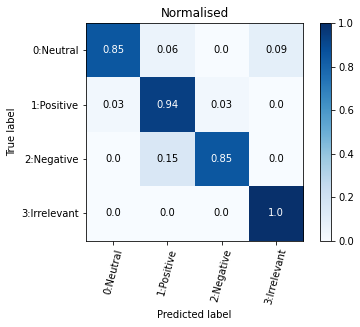

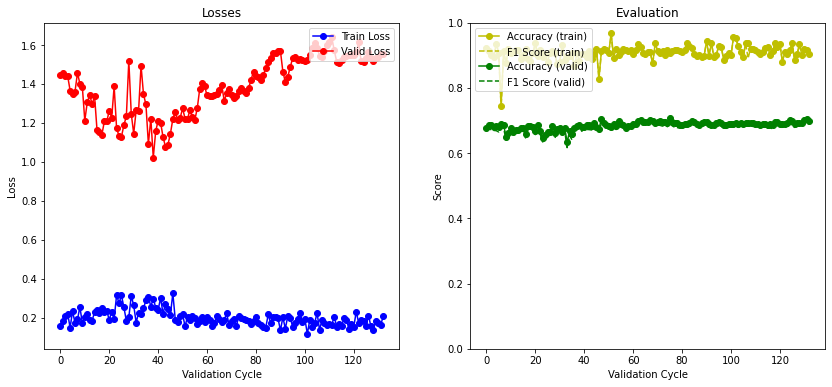

Epoch:  37%|███▋      | 26/70 [03:51<06:42,  9.16s/it]

[2022-08-25 15:48:37,277][INFO] ## ================     epoch 27     ===============


INFO:sa_tweet_inperf:================     epoch 27     ===============
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:48:38,595][DEBUG] ## Epoch: 27/70, Step: 1463, Loss: 37.9112, Acc: 0.6914, F1: 0.6805


DEBUG:sa_tweet_inperf:Epoch: 27/70, Step: 1463, Loss: 37.9112, Acc: 0.6914, F1: 0.6805
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:48:40,277][DEBUG] ## Epoch: 27/70, Step: 1474, Loss: 38.2644, Acc: 0.6940, F1: 0.6835


DEBUG:sa_tweet_inperf:Epoch: 27/70, Step: 1474, Loss: 38.2644, Acc: 0.6940, F1: 0.6835
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:48:41,971][DEBUG] ## Epoch: 27/70, Step: 1485, Loss: 38.3605, Acc: 0.6953, F1: 0.6845


DEBUG:sa_tweet_inperf:Epoch: 27/70, Step: 1485, Loss: 38.3605, Acc: 0.6953, F1: 0.6845
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:48:43,654][DEBUG] ## Epoch: 27/70, Step: 1496, Loss: 38.1783, Acc: 0.6914, F1: 0.6807


DEBUG:sa_tweet_inperf:Epoch: 27/70, Step: 1496, Loss: 38.1783, Acc: 0.6914, F1: 0.6807
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:48:45,344][DEBUG] ## Epoch: 27/70, Step: 1507, Loss: 38.1309, Acc: 0.6914, F1: 0.6807


DEBUG:sa_tweet_inperf:Epoch: 27/70, Step: 1507, Loss: 38.1309, Acc: 0.6914, F1: 0.6807
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:48:45,791][INFO] ## Epoch: 27, Loss: 1.5888, Acc: 0.6914, F1: 0.6807, LR: 2.07e-04


INFO:sa_tweet_inperf:Epoch: 27, Loss: 1.5888, Acc: 0.6914, F1: 0.6807, LR: 2.07e-04


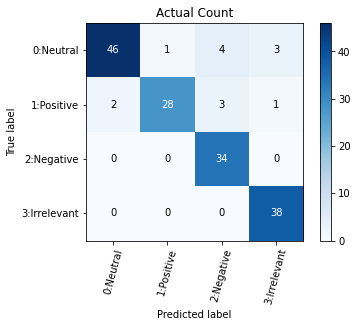

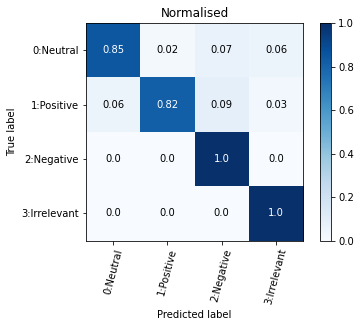

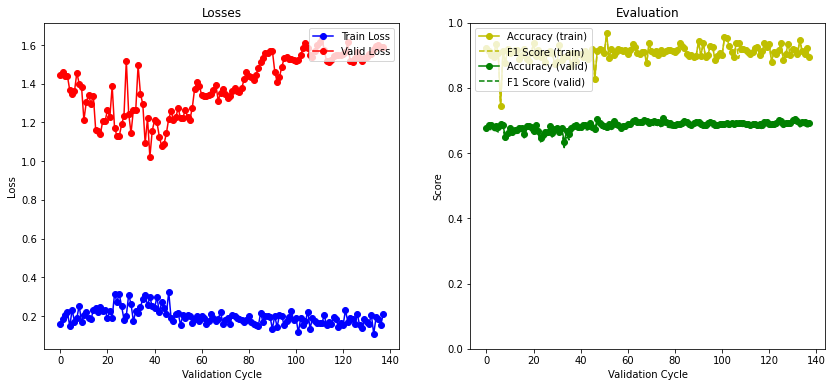

Epoch:  39%|███▊      | 27/70 [04:00<06:33,  9.16s/it]

[2022-08-25 15:48:46,443][INFO] ## ================     epoch 28     ===============


INFO:sa_tweet_inperf:================     epoch 28     ===============
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:48:47,680][DEBUG] ## Epoch: 28/70, Step: 1518, Loss: 38.2016, Acc: 0.6914, F1: 0.6819


DEBUG:sa_tweet_inperf:Epoch: 28/70, Step: 1518, Loss: 38.2016, Acc: 0.6914, F1: 0.6819
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:48:49,360][DEBUG] ## Epoch: 28/70, Step: 1529, Loss: 38.1606, Acc: 0.6888, F1: 0.6779


DEBUG:sa_tweet_inperf:Epoch: 28/70, Step: 1529, Loss: 38.1606, Acc: 0.6888, F1: 0.6779
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:48:51,052][DEBUG] ## Epoch: 28/70, Step: 1540, Loss: 38.7132, Acc: 0.6888, F1: 0.6783


DEBUG:sa_tweet_inperf:Epoch: 28/70, Step: 1540, Loss: 38.7132, Acc: 0.6888, F1: 0.6783
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:48:52,737][DEBUG] ## Epoch: 28/70, Step: 1551, Loss: 38.9782, Acc: 0.6940, F1: 0.6827


DEBUG:sa_tweet_inperf:Epoch: 28/70, Step: 1551, Loss: 38.9782, Acc: 0.6940, F1: 0.6827
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:48:54,430][DEBUG] ## Epoch: 28/70, Step: 1562, Loss: 38.8512, Acc: 0.6940, F1: 0.6851


DEBUG:sa_tweet_inperf:Epoch: 28/70, Step: 1562, Loss: 38.8512, Acc: 0.6940, F1: 0.6851
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:48:54,963][INFO] ## Epoch: 28, Loss: 1.6188, Acc: 0.6940, F1: 0.6851, LR: 2.02e-04


INFO:sa_tweet_inperf:Epoch: 28, Loss: 1.6188, Acc: 0.6940, F1: 0.6851, LR: 2.02e-04


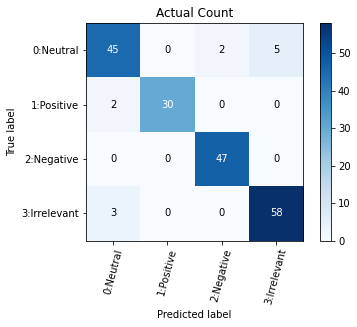

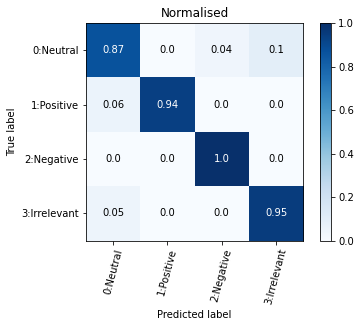

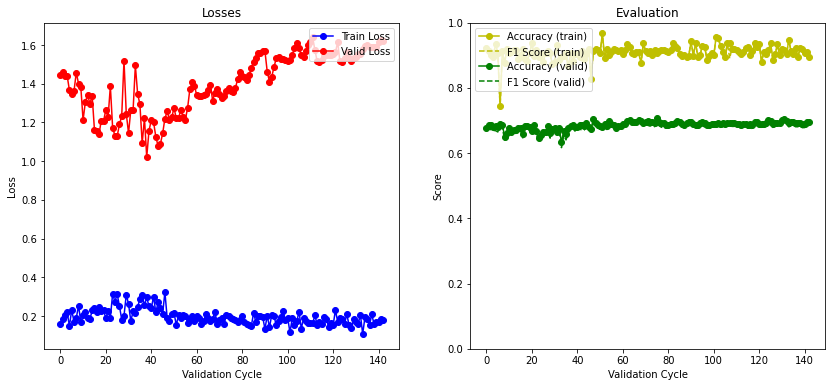

Epoch:  40%|████      | 28/70 [04:09<06:25,  9.17s/it]

[2022-08-25 15:48:55,628][INFO] ## ================     epoch 29     ===============


INFO:sa_tweet_inperf:================     epoch 29     ===============
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:48:56,749][DEBUG] ## Epoch: 29/70, Step: 1573, Loss: 39.0949, Acc: 0.6966, F1: 0.6885


DEBUG:sa_tweet_inperf:Epoch: 29/70, Step: 1573, Loss: 39.0949, Acc: 0.6966, F1: 0.6885
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:48:58,440][DEBUG] ## Epoch: 29/70, Step: 1584, Loss: 38.9643, Acc: 0.6940, F1: 0.6864


DEBUG:sa_tweet_inperf:Epoch: 29/70, Step: 1584, Loss: 38.9643, Acc: 0.6940, F1: 0.6864
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:49:00,138][DEBUG] ## Epoch: 29/70, Step: 1595, Loss: 39.3419, Acc: 0.6940, F1: 0.6854


DEBUG:sa_tweet_inperf:Epoch: 29/70, Step: 1595, Loss: 39.3419, Acc: 0.6940, F1: 0.6854
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:49:01,828][DEBUG] ## Epoch: 29/70, Step: 1606, Loss: 38.9257, Acc: 0.6979, F1: 0.6890


DEBUG:sa_tweet_inperf:Epoch: 29/70, Step: 1606, Loss: 38.9257, Acc: 0.6979, F1: 0.6890
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:49:03,506][DEBUG] ## Epoch: 29/70, Step: 1617, Loss: 38.5351, Acc: 0.6966, F1: 0.6860


DEBUG:sa_tweet_inperf:Epoch: 29/70, Step: 1617, Loss: 38.5351, Acc: 0.6966, F1: 0.6860
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:49:04,133][INFO] ## Epoch: 29, Loss: 1.6056, Acc: 0.6966, F1: 0.6860, LR: 1.98e-04


INFO:sa_tweet_inperf:Epoch: 29, Loss: 1.6056, Acc: 0.6966, F1: 0.6860, LR: 1.98e-04


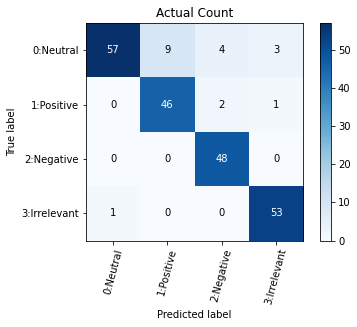

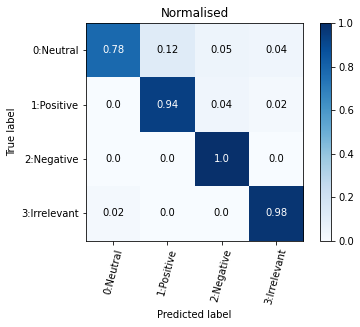

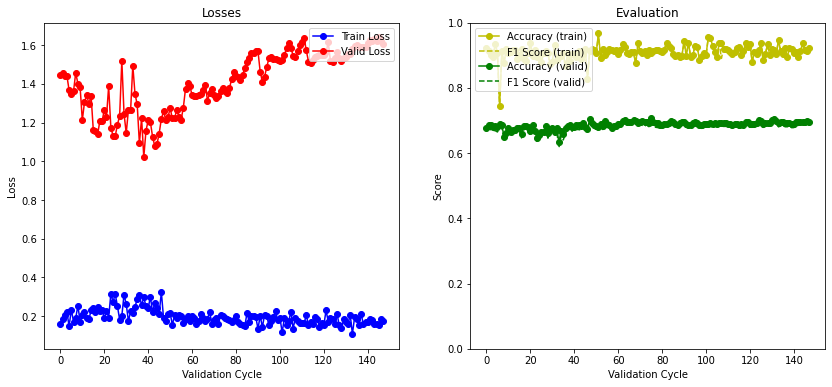

Epoch:  41%|████▏     | 29/70 [04:19<06:16,  9.17s/it]

[2022-08-25 15:49:04,815][INFO] ## ================     epoch 30     ===============


INFO:sa_tweet_inperf:================     epoch 30     ===============
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:49:05,861][DEBUG] ## Epoch: 30/70, Step: 1628, Loss: 38.3877, Acc: 0.6914, F1: 0.6829


DEBUG:sa_tweet_inperf:Epoch: 30/70, Step: 1628, Loss: 38.3877, Acc: 0.6914, F1: 0.6829
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:49:07,548][DEBUG] ## Epoch: 30/70, Step: 1639, Loss: 38.4947, Acc: 0.6940, F1: 0.6857


DEBUG:sa_tweet_inperf:Epoch: 30/70, Step: 1639, Loss: 38.4947, Acc: 0.6940, F1: 0.6857
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:49:09,241][DEBUG] ## Epoch: 30/70, Step: 1650, Loss: 38.6189, Acc: 0.6979, F1: 0.6893


DEBUG:sa_tweet_inperf:Epoch: 30/70, Step: 1650, Loss: 38.6189, Acc: 0.6979, F1: 0.6893
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:49:10,935][DEBUG] ## Epoch: 30/70, Step: 1661, Loss: 38.7390, Acc: 0.6953, F1: 0.6870


DEBUG:sa_tweet_inperf:Epoch: 30/70, Step: 1661, Loss: 38.7390, Acc: 0.6953, F1: 0.6870
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:49:12,639][DEBUG] ## Epoch: 30/70, Step: 1672, Loss: 38.8166, Acc: 0.6979, F1: 0.6894


DEBUG:sa_tweet_inperf:Epoch: 30/70, Step: 1672, Loss: 38.8166, Acc: 0.6979, F1: 0.6894
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:49:13,358][INFO] ## Epoch: 30, Loss: 1.6174, Acc: 0.6979, F1: 0.6894, LR: 1.93e-04


INFO:sa_tweet_inperf:Epoch: 30, Loss: 1.6174, Acc: 0.6979, F1: 0.6894, LR: 1.93e-04


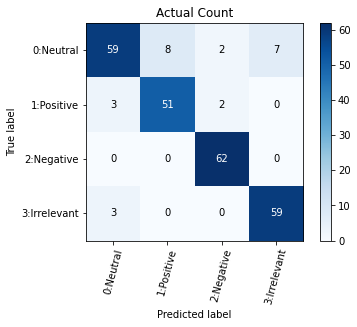

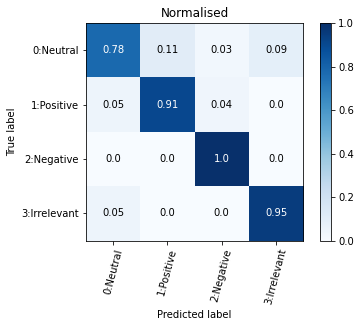

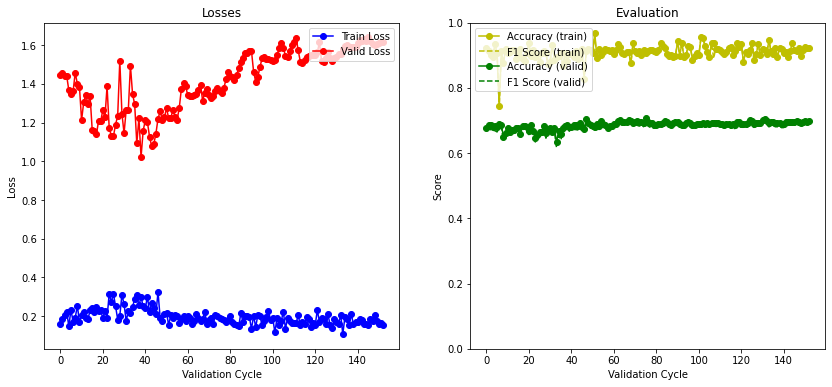

Epoch:  43%|████▎     | 30/70 [04:28<06:10,  9.25s/it]

[2022-08-25 15:49:14,252][INFO] ## ================     epoch 31     ===============


INFO:sa_tweet_inperf:================     epoch 31     ===============
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:49:15,222][DEBUG] ## Epoch: 31/70, Step: 1683, Loss: 38.8451, Acc: 0.6979, F1: 0.6895


DEBUG:sa_tweet_inperf:Epoch: 31/70, Step: 1683, Loss: 38.8451, Acc: 0.6979, F1: 0.6895
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:49:16,900][DEBUG] ## Epoch: 31/70, Step: 1694, Loss: 38.6315, Acc: 0.6953, F1: 0.6870


DEBUG:sa_tweet_inperf:Epoch: 31/70, Step: 1694, Loss: 38.6315, Acc: 0.6953, F1: 0.6870
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:49:18,594][DEBUG] ## Epoch: 31/70, Step: 1705, Loss: 38.0929, Acc: 0.6966, F1: 0.6866


DEBUG:sa_tweet_inperf:Epoch: 31/70, Step: 1705, Loss: 38.0929, Acc: 0.6966, F1: 0.6866
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:49:20,292][DEBUG] ## Epoch: 31/70, Step: 1716, Loss: 38.6834, Acc: 0.6953, F1: 0.6850


DEBUG:sa_tweet_inperf:Epoch: 31/70, Step: 1716, Loss: 38.6834, Acc: 0.6953, F1: 0.6850
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:49:21,994][DEBUG] ## Epoch: 31/70, Step: 1727, Loss: 39.0793, Acc: 0.6966, F1: 0.6854


DEBUG:sa_tweet_inperf:Epoch: 31/70, Step: 1727, Loss: 39.0793, Acc: 0.6966, F1: 0.6854
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:49:22,810][INFO] ## Epoch: 31, Loss: 1.6283, Acc: 0.6966, F1: 0.6854, LR: 1.88e-04


INFO:sa_tweet_inperf:Epoch: 31, Loss: 1.6283, Acc: 0.6966, F1: 0.6854, LR: 1.88e-04


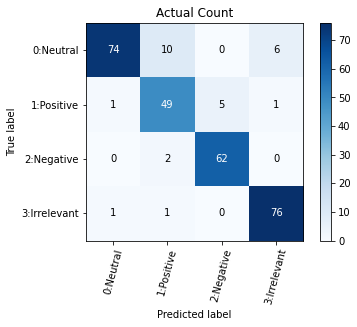

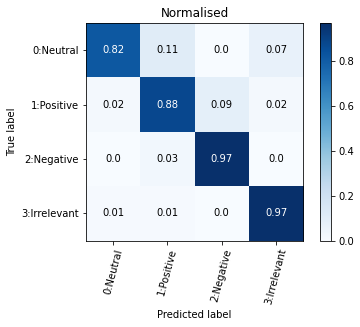

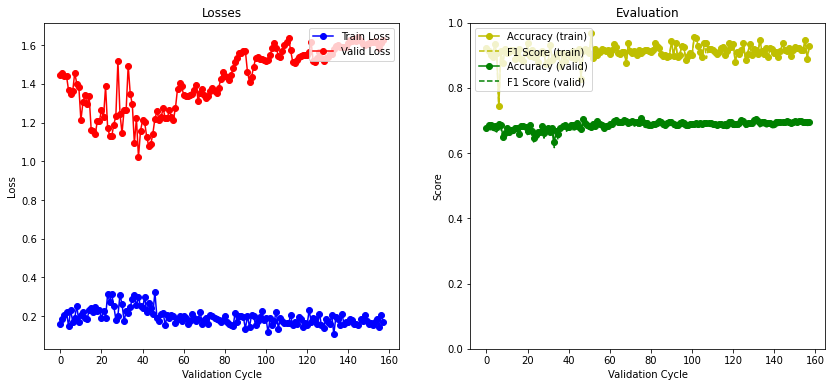

Epoch:  44%|████▍     | 31/70 [04:37<06:00,  9.25s/it]

[2022-08-25 15:49:23,483][INFO] ## ================     epoch 32     ===============


INFO:sa_tweet_inperf:================     epoch 32     ===============
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:49:24,338][DEBUG] ## Epoch: 32/70, Step: 1738, Loss: 38.9031, Acc: 0.6966, F1: 0.6854


DEBUG:sa_tweet_inperf:Epoch: 32/70, Step: 1738, Loss: 38.9031, Acc: 0.6966, F1: 0.6854
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:49:26,054][DEBUG] ## Epoch: 32/70, Step: 1749, Loss: 38.7401, Acc: 0.6927, F1: 0.6825


DEBUG:sa_tweet_inperf:Epoch: 32/70, Step: 1749, Loss: 38.7401, Acc: 0.6927, F1: 0.6825
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:49:27,738][DEBUG] ## Epoch: 32/70, Step: 1760, Loss: 39.1085, Acc: 0.6953, F1: 0.6842


DEBUG:sa_tweet_inperf:Epoch: 32/70, Step: 1760, Loss: 39.1085, Acc: 0.6953, F1: 0.6842
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:49:29,418][DEBUG] ## Epoch: 32/70, Step: 1771, Loss: 39.4531, Acc: 0.6927, F1: 0.6830


DEBUG:sa_tweet_inperf:Epoch: 32/70, Step: 1771, Loss: 39.4531, Acc: 0.6927, F1: 0.6830
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:49:31,094][DEBUG] ## Epoch: 32/70, Step: 1782, Loss: 39.6789, Acc: 0.6979, F1: 0.6874


DEBUG:sa_tweet_inperf:Epoch: 32/70, Step: 1782, Loss: 39.6789, Acc: 0.6979, F1: 0.6874
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:49:32,003][INFO] ## Epoch: 32, Loss: 1.6533, Acc: 0.6979, F1: 0.6874, LR: 1.84e-04


INFO:sa_tweet_inperf:Epoch: 32, Loss: 1.6533, Acc: 0.6979, F1: 0.6874, LR: 1.84e-04


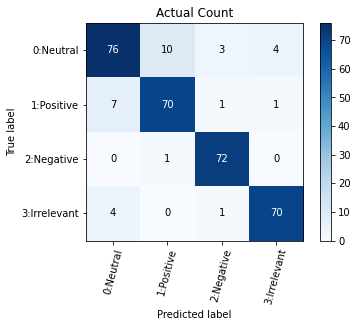

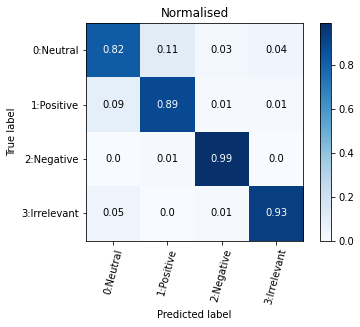

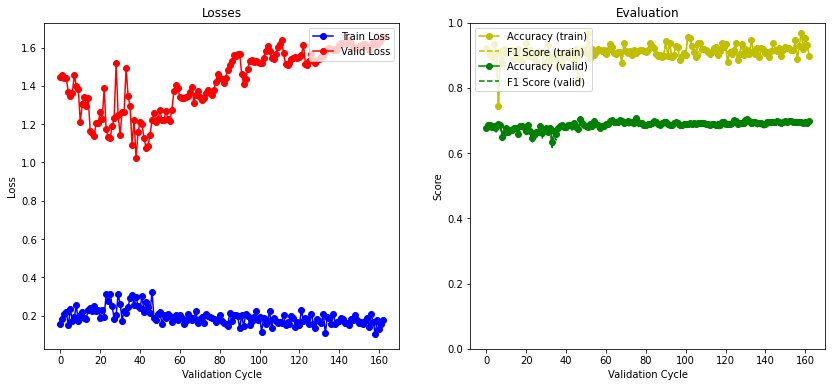

Epoch:  46%|████▌     | 32/70 [04:46<05:50,  9.23s/it]

[2022-08-25 15:49:32,688][INFO] ## ================     epoch 33     ===============


INFO:sa_tweet_inperf:================     epoch 33     ===============
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:49:33,443][DEBUG] ## Epoch: 33/70, Step: 1793, Loss: 39.8972, Acc: 0.6953, F1: 0.6873


DEBUG:sa_tweet_inperf:Epoch: 33/70, Step: 1793, Loss: 39.8972, Acc: 0.6953, F1: 0.6873
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:49:35,131][DEBUG] ## Epoch: 33/70, Step: 1804, Loss: 39.9164, Acc: 0.6940, F1: 0.6888


DEBUG:sa_tweet_inperf:Epoch: 33/70, Step: 1804, Loss: 39.9164, Acc: 0.6940, F1: 0.6888
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:49:36,799][DEBUG] ## Epoch: 33/70, Step: 1815, Loss: 40.0767, Acc: 0.6927, F1: 0.6852


DEBUG:sa_tweet_inperf:Epoch: 33/70, Step: 1815, Loss: 40.0767, Acc: 0.6927, F1: 0.6852
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:49:38,478][DEBUG] ## Epoch: 33/70, Step: 1826, Loss: 40.4398, Acc: 0.6979, F1: 0.6889


DEBUG:sa_tweet_inperf:Epoch: 33/70, Step: 1826, Loss: 40.4398, Acc: 0.6979, F1: 0.6889
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:49:40,157][DEBUG] ## Epoch: 33/70, Step: 1837, Loss: 40.4641, Acc: 0.7005, F1: 0.6901


DEBUG:sa_tweet_inperf:Epoch: 33/70, Step: 1837, Loss: 40.4641, Acc: 0.7005, F1: 0.6901
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:49:41,839][DEBUG] ## Epoch: 33/70, Step: 1848, Loss: 40.6230, Acc: 0.7018, F1: 0.6913


DEBUG:sa_tweet_inperf:Epoch: 33/70, Step: 1848, Loss: 40.6230, Acc: 0.7018, F1: 0.6913


[2022-08-25 15:49:41,845][INFO] ## Epoch: 33, Loss: 1.6926, Acc: 0.7018, F1: 0.6913, LR: 1.79e-04


INFO:sa_tweet_inperf:Epoch: 33, Loss: 1.6926, Acc: 0.7018, F1: 0.6913, LR: 1.79e-04


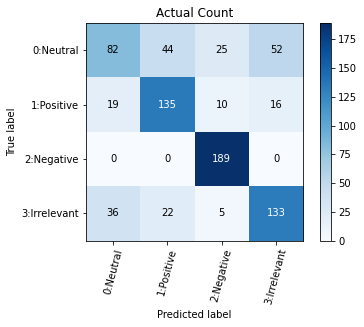

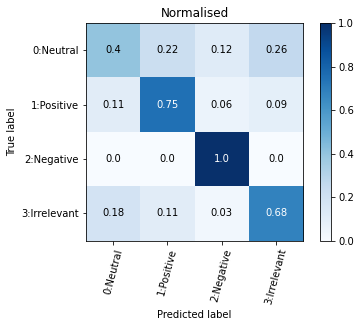

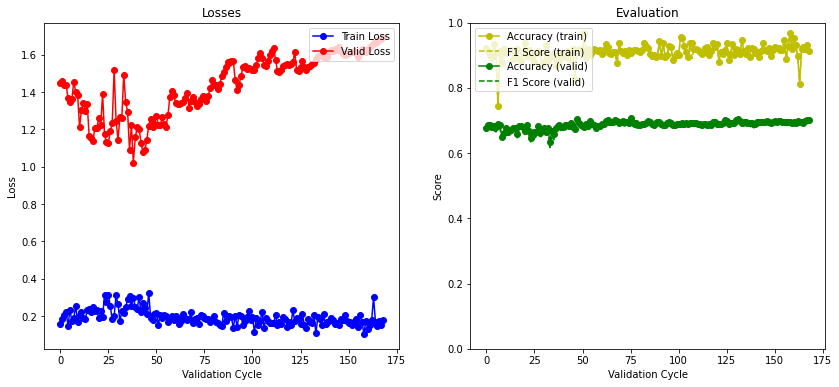

Epoch:  47%|████▋     | 33/70 [04:56<05:48,  9.42s/it]

[2022-08-25 15:49:42,550][INFO] ## ================     epoch 34     ===============


INFO:sa_tweet_inperf:================     epoch 34     ===============
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:49:44,211][DEBUG] ## Epoch: 34/70, Step: 1859, Loss: 40.7606, Acc: 0.7018, F1: 0.6910


DEBUG:sa_tweet_inperf:Epoch: 34/70, Step: 1859, Loss: 40.7606, Acc: 0.7018, F1: 0.6910
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:49:45,880][DEBUG] ## Epoch: 34/70, Step: 1870, Loss: 40.9568, Acc: 0.6992, F1: 0.6882


DEBUG:sa_tweet_inperf:Epoch: 34/70, Step: 1870, Loss: 40.9568, Acc: 0.6992, F1: 0.6882
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:49:47,550][DEBUG] ## Epoch: 34/70, Step: 1881, Loss: 40.5920, Acc: 0.6914, F1: 0.6792


DEBUG:sa_tweet_inperf:Epoch: 34/70, Step: 1881, Loss: 40.5920, Acc: 0.6914, F1: 0.6792
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:49:49,231][DEBUG] ## Epoch: 34/70, Step: 1892, Loss: 40.7070, Acc: 0.6940, F1: 0.6828


DEBUG:sa_tweet_inperf:Epoch: 34/70, Step: 1892, Loss: 40.7070, Acc: 0.6940, F1: 0.6828
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:49:50,909][DEBUG] ## Epoch: 34/70, Step: 1903, Loss: 40.0748, Acc: 0.6979, F1: 0.6888


DEBUG:sa_tweet_inperf:Epoch: 34/70, Step: 1903, Loss: 40.0748, Acc: 0.6979, F1: 0.6888


[2022-08-25 15:49:50,994][INFO] ## Epoch: 34, Loss: 1.6698, Acc: 0.6979, F1: 0.6888, LR: 1.74e-04


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
INFO:sa_tweet_inperf:Epoch: 34, Loss: 1.6698, Acc: 0.6979, F1: 0.6888, LR: 1.74e-04


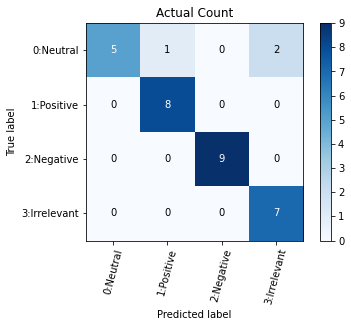

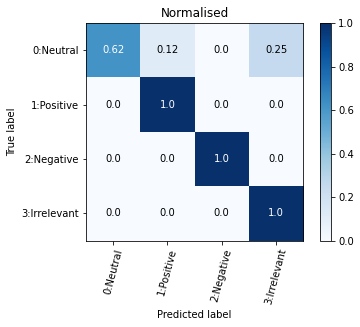

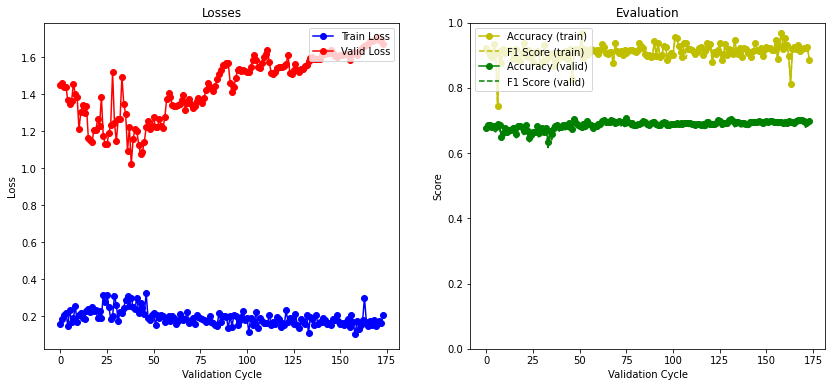

Epoch:  49%|████▊     | 34/70 [05:05<05:36,  9.34s/it]

[2022-08-25 15:49:51,698][INFO] ## ================     epoch 35     ===============


INFO:sa_tweet_inperf:================     epoch 35     ===============
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:49:53,286][DEBUG] ## Epoch: 35/70, Step: 1914, Loss: 39.7035, Acc: 0.6927, F1: 0.6849


DEBUG:sa_tweet_inperf:Epoch: 35/70, Step: 1914, Loss: 39.7035, Acc: 0.6927, F1: 0.6849
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:49:54,967][DEBUG] ## Epoch: 35/70, Step: 1925, Loss: 39.5707, Acc: 0.6927, F1: 0.6848


DEBUG:sa_tweet_inperf:Epoch: 35/70, Step: 1925, Loss: 39.5707, Acc: 0.6927, F1: 0.6848
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:49:56,639][DEBUG] ## Epoch: 35/70, Step: 1936, Loss: 39.4888, Acc: 0.6992, F1: 0.6896


DEBUG:sa_tweet_inperf:Epoch: 35/70, Step: 1936, Loss: 39.4888, Acc: 0.6992, F1: 0.6896
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:49:58,328][DEBUG] ## Epoch: 35/70, Step: 1947, Loss: 39.7540, Acc: 0.7018, F1: 0.6903


DEBUG:sa_tweet_inperf:Epoch: 35/70, Step: 1947, Loss: 39.7540, Acc: 0.7018, F1: 0.6903
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:50:00,015][DEBUG] ## Epoch: 35/70, Step: 1958, Loss: 40.3315, Acc: 0.6992, F1: 0.6875


DEBUG:sa_tweet_inperf:Epoch: 35/70, Step: 1958, Loss: 40.3315, Acc: 0.6992, F1: 0.6875


[2022-08-25 15:50:00,189][INFO] ## Epoch: 35, Loss: 1.6805, Acc: 0.6992, F1: 0.6875, LR: 1.70e-04


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
INFO:sa_tweet_inperf:Epoch: 35, Loss: 1.6805, Acc: 0.6992, F1: 0.6875, LR: 1.70e-04


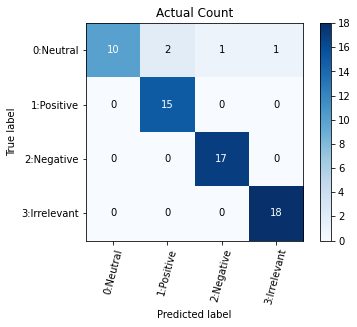

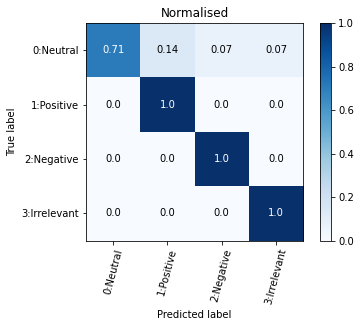

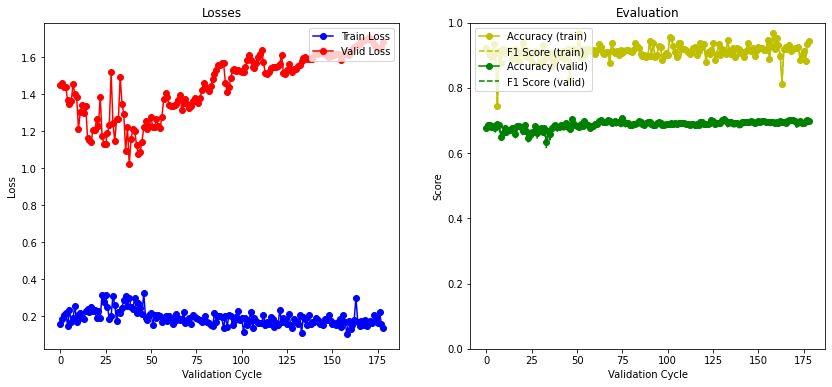

Epoch:  50%|█████     | 35/70 [05:15<05:25,  9.29s/it]

[2022-08-25 15:50:00,898][INFO] ## ================     epoch 36     ===============


INFO:sa_tweet_inperf:================     epoch 36     ===============
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:50:02,399][DEBUG] ## Epoch: 36/70, Step: 1969, Loss: 41.0117, Acc: 0.6966, F1: 0.6856


DEBUG:sa_tweet_inperf:Epoch: 36/70, Step: 1969, Loss: 41.0117, Acc: 0.6966, F1: 0.6856
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:50:04,077][DEBUG] ## Epoch: 36/70, Step: 1980, Loss: 41.1144, Acc: 0.6979, F1: 0.6872


DEBUG:sa_tweet_inperf:Epoch: 36/70, Step: 1980, Loss: 41.1144, Acc: 0.6979, F1: 0.6872
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:50:05,757][DEBUG] ## Epoch: 36/70, Step: 1991, Loss: 40.9924, Acc: 0.6966, F1: 0.6872


DEBUG:sa_tweet_inperf:Epoch: 36/70, Step: 1991, Loss: 40.9924, Acc: 0.6966, F1: 0.6872
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:50:07,434][DEBUG] ## Epoch: 36/70, Step: 2002, Loss: 40.8082, Acc: 0.6953, F1: 0.6848


DEBUG:sa_tweet_inperf:Epoch: 36/70, Step: 2002, Loss: 40.8082, Acc: 0.6953, F1: 0.6848
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:50:09,109][DEBUG] ## Epoch: 36/70, Step: 2013, Loss: 40.8439, Acc: 0.6992, F1: 0.6878


DEBUG:sa_tweet_inperf:Epoch: 36/70, Step: 2013, Loss: 40.8439, Acc: 0.6992, F1: 0.6878
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:50:09,378][INFO] ## Epoch: 36, Loss: 1.7018, Acc: 0.6992, F1: 0.6878, LR: 1.65e-04


INFO:sa_tweet_inperf:Epoch: 36, Loss: 1.7018, Acc: 0.6992, F1: 0.6878, LR: 1.65e-04


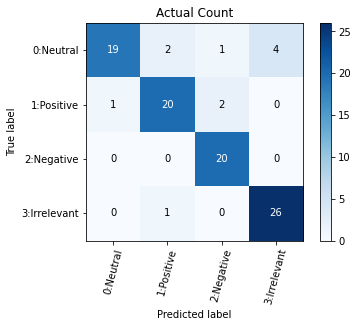

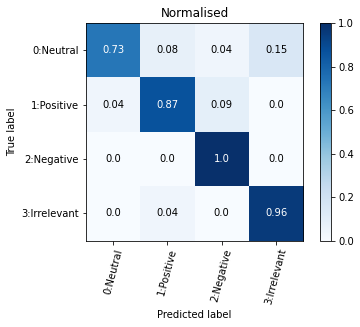

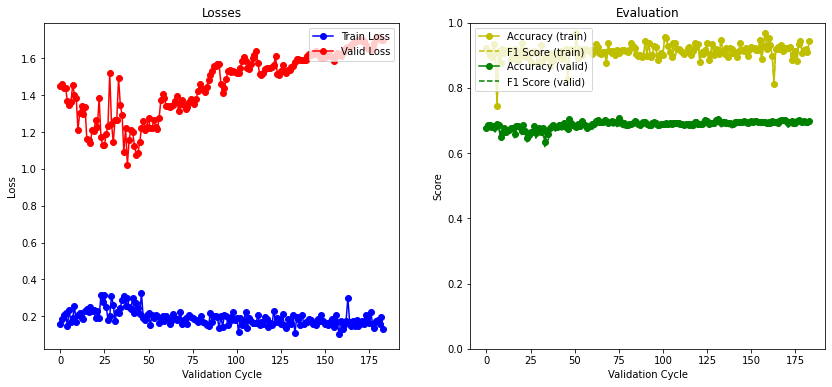

Epoch:  51%|█████▏    | 36/70 [05:24<05:17,  9.33s/it]

[2022-08-25 15:50:10,303][INFO] ## ================     epoch 37     ===============


INFO:sa_tweet_inperf:================     epoch 37     ===============
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:50:11,701][DEBUG] ## Epoch: 37/70, Step: 2024, Loss: 41.1597, Acc: 0.6979, F1: 0.6865


DEBUG:sa_tweet_inperf:Epoch: 37/70, Step: 2024, Loss: 41.1597, Acc: 0.6979, F1: 0.6865
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:50:13,381][DEBUG] ## Epoch: 37/70, Step: 2035, Loss: 41.4589, Acc: 0.6992, F1: 0.6891


DEBUG:sa_tweet_inperf:Epoch: 37/70, Step: 2035, Loss: 41.4589, Acc: 0.6992, F1: 0.6891
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:50:15,068][DEBUG] ## Epoch: 37/70, Step: 2046, Loss: 41.3957, Acc: 0.6979, F1: 0.6872


DEBUG:sa_tweet_inperf:Epoch: 37/70, Step: 2046, Loss: 41.3957, Acc: 0.6979, F1: 0.6872
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:50:16,746][DEBUG] ## Epoch: 37/70, Step: 2057, Loss: 41.1825, Acc: 0.6940, F1: 0.6834


DEBUG:sa_tweet_inperf:Epoch: 37/70, Step: 2057, Loss: 41.1825, Acc: 0.6940, F1: 0.6834
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:50:18,423][DEBUG] ## Epoch: 37/70, Step: 2068, Loss: 41.0898, Acc: 0.7005, F1: 0.6902


DEBUG:sa_tweet_inperf:Epoch: 37/70, Step: 2068, Loss: 41.0898, Acc: 0.7005, F1: 0.6902
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:50:18,778][INFO] ## Epoch: 37, Loss: 1.7121, Acc: 0.7005, F1: 0.6902, LR: 1.60e-04


INFO:sa_tweet_inperf:Epoch: 37, Loss: 1.7121, Acc: 0.7005, F1: 0.6902, LR: 1.60e-04


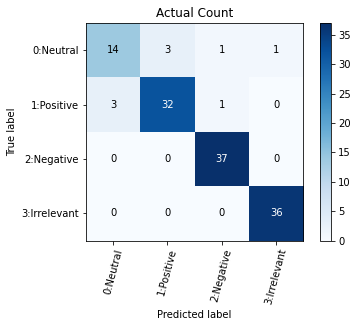

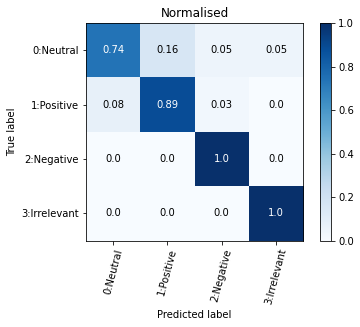

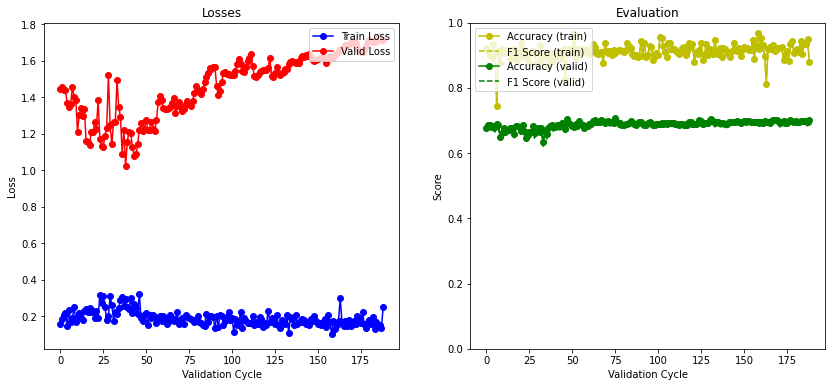

Epoch:  53%|█████▎    | 37/70 [05:33<05:06,  9.28s/it]

[2022-08-25 15:50:19,458][INFO] ## ================     epoch 38     ===============


INFO:sa_tweet_inperf:================     epoch 38     ===============
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:50:20,779][DEBUG] ## Epoch: 38/70, Step: 2079, Loss: 41.1291, Acc: 0.7031, F1: 0.6919


DEBUG:sa_tweet_inperf:Epoch: 38/70, Step: 2079, Loss: 41.1291, Acc: 0.7031, F1: 0.6919
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:50:22,456][DEBUG] ## Epoch: 38/70, Step: 2090, Loss: 41.3076, Acc: 0.7005, F1: 0.6891


DEBUG:sa_tweet_inperf:Epoch: 38/70, Step: 2090, Loss: 41.3076, Acc: 0.7005, F1: 0.6891
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:50:24,139][DEBUG] ## Epoch: 38/70, Step: 2101, Loss: 40.9116, Acc: 0.7031, F1: 0.6919


DEBUG:sa_tweet_inperf:Epoch: 38/70, Step: 2101, Loss: 40.9116, Acc: 0.7031, F1: 0.6919
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:50:25,823][DEBUG] ## Epoch: 38/70, Step: 2112, Loss: 41.1712, Acc: 0.7018, F1: 0.6904


DEBUG:sa_tweet_inperf:Epoch: 38/70, Step: 2112, Loss: 41.1712, Acc: 0.7018, F1: 0.6904
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:50:27,499][DEBUG] ## Epoch: 38/70, Step: 2123, Loss: 41.3873, Acc: 0.7005, F1: 0.6896


DEBUG:sa_tweet_inperf:Epoch: 38/70, Step: 2123, Loss: 41.3873, Acc: 0.7005, F1: 0.6896
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:50:27,943][INFO] ## Epoch: 38, Loss: 1.7245, Acc: 0.7005, F1: 0.6896, LR: 1.56e-04


INFO:sa_tweet_inperf:Epoch: 38, Loss: 1.7245, Acc: 0.7005, F1: 0.6896, LR: 1.56e-04


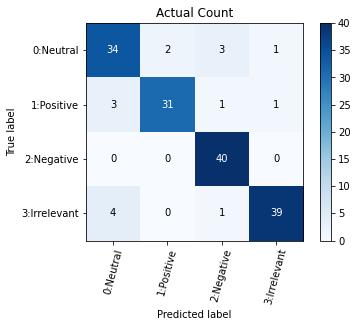

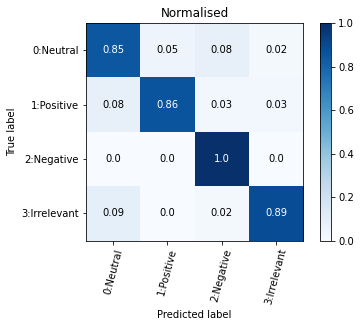

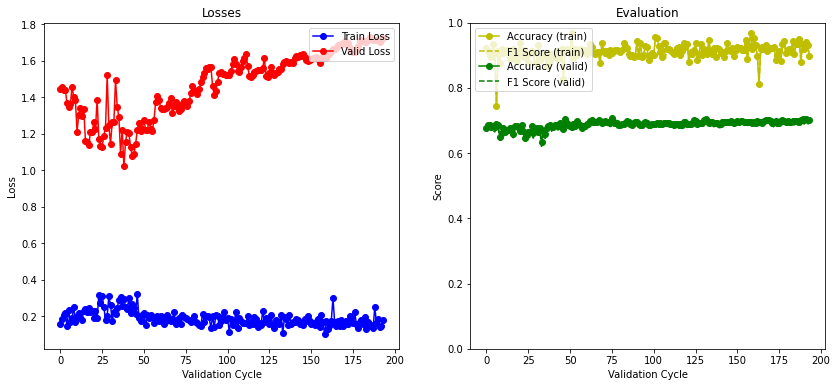

Epoch:  54%|█████▍    | 38/70 [05:42<04:55,  9.25s/it]

[2022-08-25 15:50:28,628][INFO] ## ================     epoch 39     ===============


INFO:sa_tweet_inperf:================     epoch 39     ===============
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:50:29,853][DEBUG] ## Epoch: 39/70, Step: 2134, Loss: 41.6605, Acc: 0.6953, F1: 0.6861


DEBUG:sa_tweet_inperf:Epoch: 39/70, Step: 2134, Loss: 41.6605, Acc: 0.6953, F1: 0.6861
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:50:31,533][DEBUG] ## Epoch: 39/70, Step: 2145, Loss: 42.0497, Acc: 0.6953, F1: 0.6868


DEBUG:sa_tweet_inperf:Epoch: 39/70, Step: 2145, Loss: 42.0497, Acc: 0.6953, F1: 0.6868
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:50:33,208][DEBUG] ## Epoch: 39/70, Step: 2156, Loss: 41.9886, Acc: 0.6940, F1: 0.6852


DEBUG:sa_tweet_inperf:Epoch: 39/70, Step: 2156, Loss: 41.9886, Acc: 0.6940, F1: 0.6852
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:50:34,897][DEBUG] ## Epoch: 39/70, Step: 2167, Loss: 41.1798, Acc: 0.7005, F1: 0.6900


DEBUG:sa_tweet_inperf:Epoch: 39/70, Step: 2167, Loss: 41.1798, Acc: 0.7005, F1: 0.6900
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:50:36,581][DEBUG] ## Epoch: 39/70, Step: 2178, Loss: 40.8305, Acc: 0.7018, F1: 0.6910


DEBUG:sa_tweet_inperf:Epoch: 39/70, Step: 2178, Loss: 40.8305, Acc: 0.7018, F1: 0.6910
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:50:37,112][INFO] ## Epoch: 39, Loss: 1.7013, Acc: 0.7018, F1: 0.6910, LR: 1.51e-04


INFO:sa_tweet_inperf:Epoch: 39, Loss: 1.7013, Acc: 0.7018, F1: 0.6910, LR: 1.51e-04


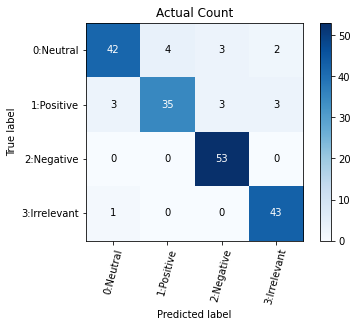

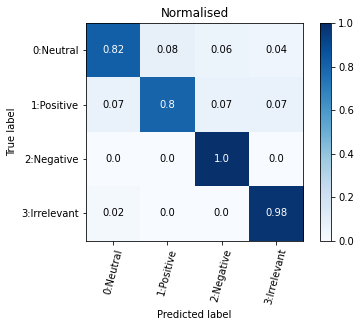

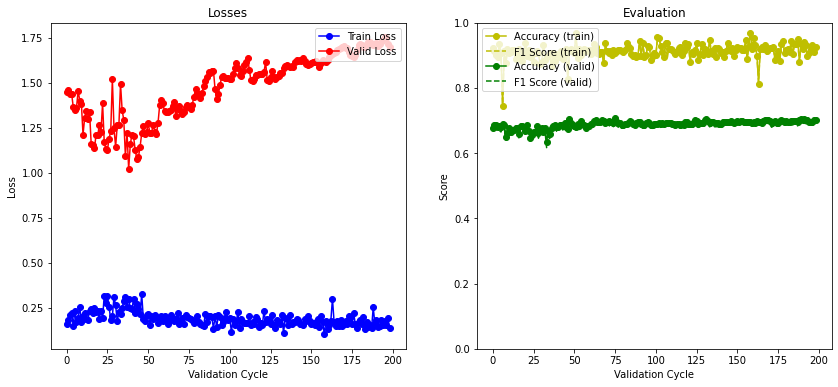

Epoch:  56%|█████▌    | 39/70 [05:52<04:45,  9.23s/it]

[2022-08-25 15:50:37,812][INFO] ## ================     epoch 40     ===============


INFO:sa_tweet_inperf:================     epoch 40     ===============
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:50:38,958][DEBUG] ## Epoch: 40/70, Step: 2189, Loss: 41.0509, Acc: 0.6992, F1: 0.6885


DEBUG:sa_tweet_inperf:Epoch: 40/70, Step: 2189, Loss: 41.0509, Acc: 0.6992, F1: 0.6885
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:50:40,642][DEBUG] ## Epoch: 40/70, Step: 2200, Loss: 41.4879, Acc: 0.6966, F1: 0.6858


DEBUG:sa_tweet_inperf:Epoch: 40/70, Step: 2200, Loss: 41.4879, Acc: 0.6966, F1: 0.6858
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:50:42,318][DEBUG] ## Epoch: 40/70, Step: 2211, Loss: 41.7551, Acc: 0.6979, F1: 0.6873


DEBUG:sa_tweet_inperf:Epoch: 40/70, Step: 2211, Loss: 41.7551, Acc: 0.6979, F1: 0.6873
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:50:44,009][DEBUG] ## Epoch: 40/70, Step: 2222, Loss: 42.0014, Acc: 0.6992, F1: 0.6888


DEBUG:sa_tweet_inperf:Epoch: 40/70, Step: 2222, Loss: 42.0014, Acc: 0.6992, F1: 0.6888
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:50:45,695][DEBUG] ## Epoch: 40/70, Step: 2233, Loss: 42.1261, Acc: 0.6992, F1: 0.6886


DEBUG:sa_tweet_inperf:Epoch: 40/70, Step: 2233, Loss: 42.1261, Acc: 0.6992, F1: 0.6886
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:50:46,320][INFO] ## Epoch: 40, Loss: 1.7553, Acc: 0.6992, F1: 0.6886, LR: 1.46e-04


INFO:sa_tweet_inperf:Epoch: 40, Loss: 1.7553, Acc: 0.6992, F1: 0.6886, LR: 1.46e-04


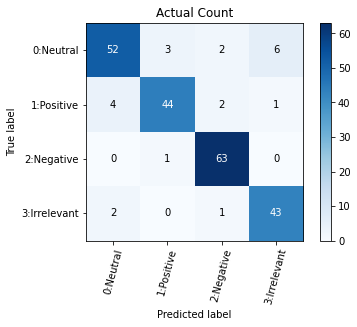

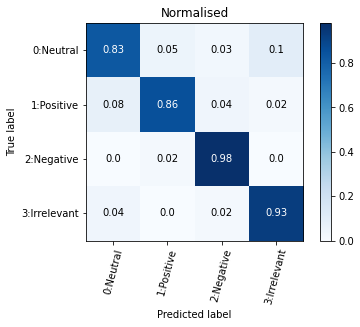

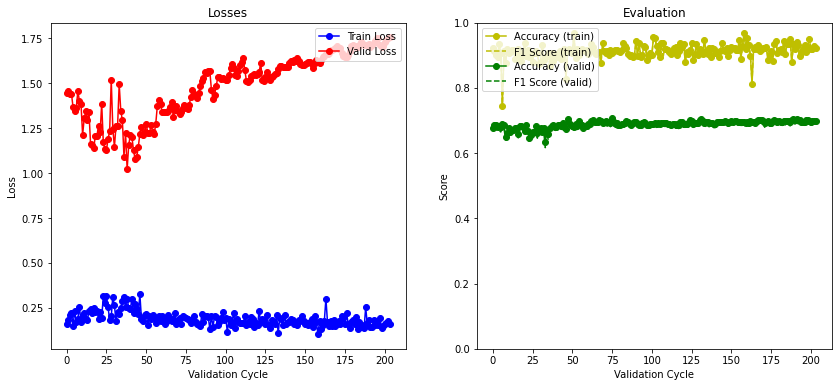

Epoch:  57%|█████▋    | 40/70 [06:01<04:36,  9.22s/it]

[2022-08-25 15:50:47,002][INFO] ## ================     epoch 41     ===============


INFO:sa_tweet_inperf:================     epoch 41     ===============
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:50:48,064][DEBUG] ## Epoch: 41/70, Step: 2244, Loss: 42.0085, Acc: 0.6979, F1: 0.6870


DEBUG:sa_tweet_inperf:Epoch: 41/70, Step: 2244, Loss: 42.0085, Acc: 0.6979, F1: 0.6870
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:50:49,753][DEBUG] ## Epoch: 41/70, Step: 2255, Loss: 42.0835, Acc: 0.6953, F1: 0.6844


DEBUG:sa_tweet_inperf:Epoch: 41/70, Step: 2255, Loss: 42.0835, Acc: 0.6953, F1: 0.6844
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:50:51,442][DEBUG] ## Epoch: 41/70, Step: 2266, Loss: 42.2809, Acc: 0.6966, F1: 0.6875


DEBUG:sa_tweet_inperf:Epoch: 41/70, Step: 2266, Loss: 42.2809, Acc: 0.6966, F1: 0.6875
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:50:53,132][DEBUG] ## Epoch: 41/70, Step: 2277, Loss: 42.2812, Acc: 0.6940, F1: 0.6848


DEBUG:sa_tweet_inperf:Epoch: 41/70, Step: 2277, Loss: 42.2812, Acc: 0.6940, F1: 0.6848
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:50:54,824][DEBUG] ## Epoch: 41/70, Step: 2288, Loss: 42.4317, Acc: 0.6966, F1: 0.6872


DEBUG:sa_tweet_inperf:Epoch: 41/70, Step: 2288, Loss: 42.4317, Acc: 0.6966, F1: 0.6872
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:50:55,550][INFO] ## Epoch: 41, Loss: 1.7680, Acc: 0.6966, F1: 0.6872, LR: 1.42e-04


INFO:sa_tweet_inperf:Epoch: 41, Loss: 1.7680, Acc: 0.6966, F1: 0.6872, LR: 1.42e-04


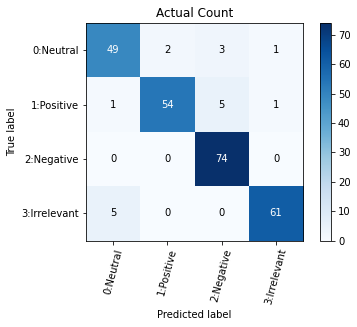

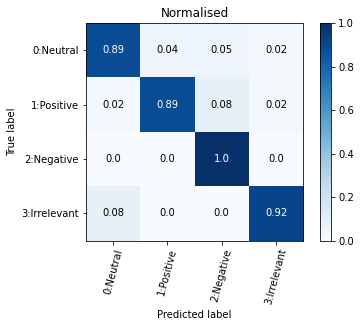

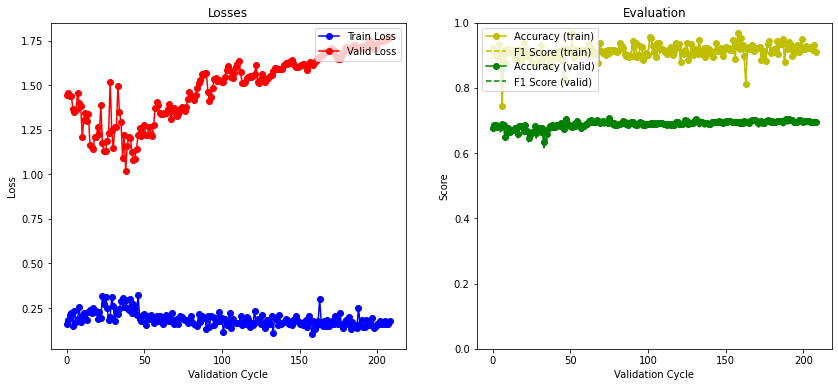

Epoch:  59%|█████▊    | 41/70 [06:10<04:27,  9.24s/it]

[2022-08-25 15:50:56,288][INFO] ## ================     epoch 42     ===============


INFO:sa_tweet_inperf:================     epoch 42     ===============
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:50:57,250][DEBUG] ## Epoch: 42/70, Step: 2299, Loss: 42.0947, Acc: 0.6979, F1: 0.6876


DEBUG:sa_tweet_inperf:Epoch: 42/70, Step: 2299, Loss: 42.0947, Acc: 0.6979, F1: 0.6876
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:50:58,938][DEBUG] ## Epoch: 42/70, Step: 2310, Loss: 42.0236, Acc: 0.6979, F1: 0.6873


DEBUG:sa_tweet_inperf:Epoch: 42/70, Step: 2310, Loss: 42.0236, Acc: 0.6979, F1: 0.6873
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:51:00,627][DEBUG] ## Epoch: 42/70, Step: 2321, Loss: 42.3196, Acc: 0.6992, F1: 0.6887


DEBUG:sa_tweet_inperf:Epoch: 42/70, Step: 2321, Loss: 42.3196, Acc: 0.6992, F1: 0.6887
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:51:02,314][DEBUG] ## Epoch: 42/70, Step: 2332, Loss: 42.2229, Acc: 0.7018, F1: 0.6912


DEBUG:sa_tweet_inperf:Epoch: 42/70, Step: 2332, Loss: 42.2229, Acc: 0.7018, F1: 0.6912
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:51:04,002][DEBUG] ## Epoch: 42/70, Step: 2343, Loss: 41.0481, Acc: 0.6914, F1: 0.6824


DEBUG:sa_tweet_inperf:Epoch: 42/70, Step: 2343, Loss: 41.0481, Acc: 0.6914, F1: 0.6824
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:51:04,813][INFO] ## Epoch: 42, Loss: 1.7103, Acc: 0.6914, F1: 0.6824, LR: 1.37e-04


INFO:sa_tweet_inperf:Epoch: 42, Loss: 1.7103, Acc: 0.6914, F1: 0.6824, LR: 1.37e-04


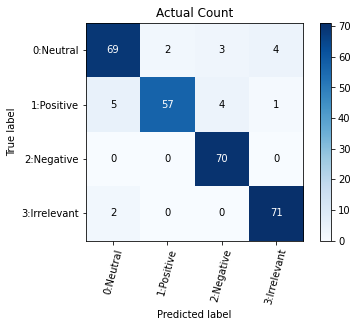

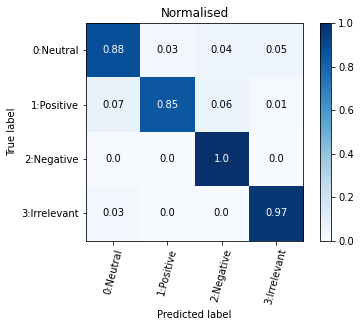

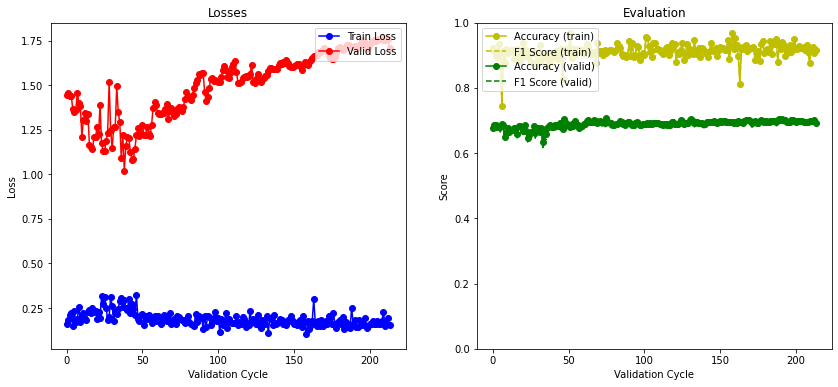

Epoch:  60%|██████    | 42/70 [06:19<04:18,  9.22s/it]

[2022-08-25 15:51:05,480][INFO] ## ================     epoch 43     ===============


INFO:sa_tweet_inperf:================     epoch 43     ===============
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:51:06,325][DEBUG] ## Epoch: 43/70, Step: 2354, Loss: 41.1005, Acc: 0.6940, F1: 0.6846


DEBUG:sa_tweet_inperf:Epoch: 43/70, Step: 2354, Loss: 41.1005, Acc: 0.6940, F1: 0.6846
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:51:08,023][DEBUG] ## Epoch: 43/70, Step: 2365, Loss: 41.2730, Acc: 0.6966, F1: 0.6875


DEBUG:sa_tweet_inperf:Epoch: 43/70, Step: 2365, Loss: 41.2730, Acc: 0.6966, F1: 0.6875
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:51:09,723][DEBUG] ## Epoch: 43/70, Step: 2376, Loss: 41.3244, Acc: 0.6953, F1: 0.6864


DEBUG:sa_tweet_inperf:Epoch: 43/70, Step: 2376, Loss: 41.3244, Acc: 0.6953, F1: 0.6864
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:51:11,408][DEBUG] ## Epoch: 43/70, Step: 2387, Loss: 41.7970, Acc: 0.6901, F1: 0.6821


DEBUG:sa_tweet_inperf:Epoch: 43/70, Step: 2387, Loss: 41.7970, Acc: 0.6901, F1: 0.6821
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:51:13,097][DEBUG] ## Epoch: 43/70, Step: 2398, Loss: 41.8875, Acc: 0.6914, F1: 0.6833


DEBUG:sa_tweet_inperf:Epoch: 43/70, Step: 2398, Loss: 41.8875, Acc: 0.6914, F1: 0.6833
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:51:13,999][INFO] ## Epoch: 43, Loss: 1.7453, Acc: 0.6914, F1: 0.6833, LR: 1.32e-04


INFO:sa_tweet_inperf:Epoch: 43, Loss: 1.7453, Acc: 0.6914, F1: 0.6833, LR: 1.32e-04


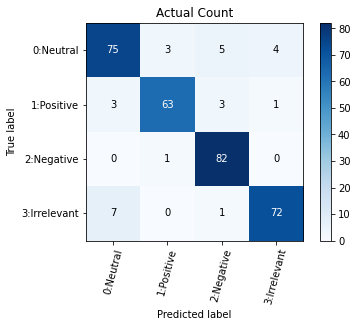

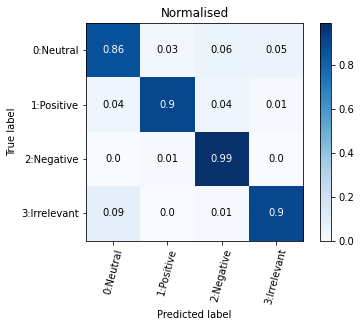

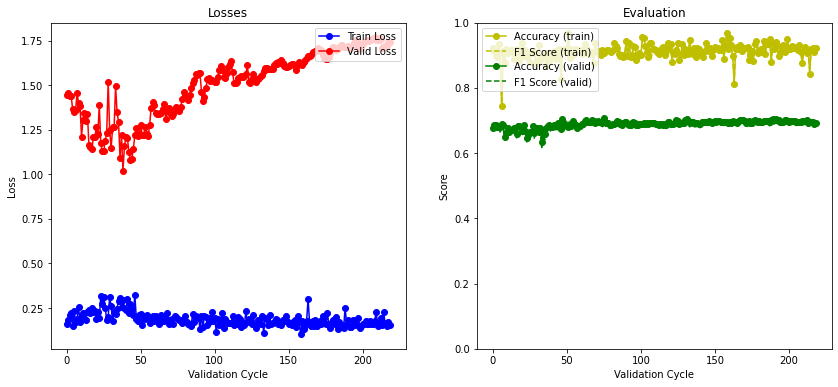

Epoch:  61%|██████▏   | 43/70 [06:29<04:10,  9.29s/it]

[2022-08-25 15:51:14,914][INFO] ## ================     epoch 44     ===============


INFO:sa_tweet_inperf:================     epoch 44     ===============
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:51:15,677][DEBUG] ## Epoch: 44/70, Step: 2409, Loss: 41.4502, Acc: 0.6992, F1: 0.6889


DEBUG:sa_tweet_inperf:Epoch: 44/70, Step: 2409, Loss: 41.4502, Acc: 0.6992, F1: 0.6889
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:51:17,367][DEBUG] ## Epoch: 44/70, Step: 2420, Loss: 41.5925, Acc: 0.7031, F1: 0.6922


DEBUG:sa_tweet_inperf:Epoch: 44/70, Step: 2420, Loss: 41.5925, Acc: 0.7031, F1: 0.6922
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:51:19,048][DEBUG] ## Epoch: 44/70, Step: 2431, Loss: 41.9661, Acc: 0.6992, F1: 0.6890


DEBUG:sa_tweet_inperf:Epoch: 44/70, Step: 2431, Loss: 41.9661, Acc: 0.6992, F1: 0.6890
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:51:20,736][DEBUG] ## Epoch: 44/70, Step: 2442, Loss: 41.7419, Acc: 0.7005, F1: 0.6897


DEBUG:sa_tweet_inperf:Epoch: 44/70, Step: 2442, Loss: 41.7419, Acc: 0.7005, F1: 0.6897
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:51:22,431][DEBUG] ## Epoch: 44/70, Step: 2453, Loss: 41.4608, Acc: 0.7018, F1: 0.6906


DEBUG:sa_tweet_inperf:Epoch: 44/70, Step: 2453, Loss: 41.4608, Acc: 0.7018, F1: 0.6906
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:51:24,122][DEBUG] ## Epoch: 44/70, Step: 2464, Loss: 41.6657, Acc: 0.7018, F1: 0.6907


DEBUG:sa_tweet_inperf:Epoch: 44/70, Step: 2464, Loss: 41.6657, Acc: 0.7018, F1: 0.6907


[2022-08-25 15:51:24,127][INFO] ## Epoch: 44, Loss: 1.7361, Acc: 0.7018, F1: 0.6907, LR: 1.27e-04


INFO:sa_tweet_inperf:Epoch: 44, Loss: 1.7361, Acc: 0.7018, F1: 0.6907, LR: 1.27e-04


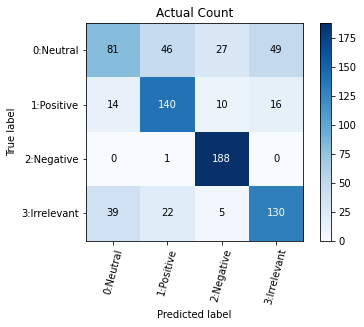

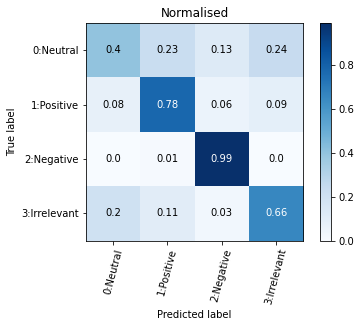

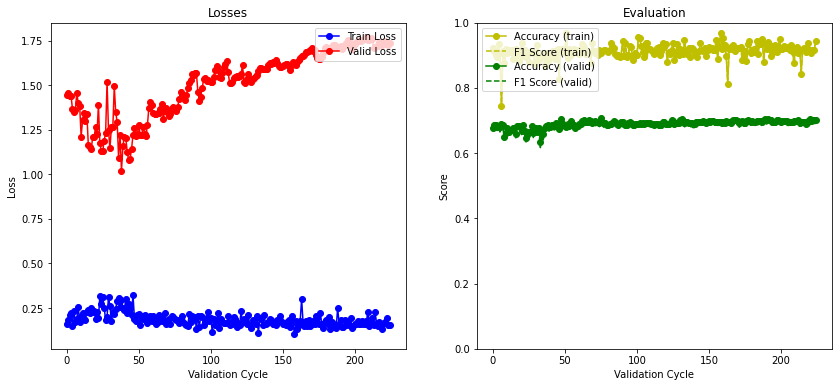

Epoch:  63%|██████▎   | 44/70 [06:39<04:06,  9.48s/it]

[2022-08-25 15:51:24,832][INFO] ## ================     epoch 45     ===============


INFO:sa_tweet_inperf:================     epoch 45     ===============
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:51:26,527][DEBUG] ## Epoch: 45/70, Step: 2475, Loss: 41.7359, Acc: 0.7005, F1: 0.6893


DEBUG:sa_tweet_inperf:Epoch: 45/70, Step: 2475, Loss: 41.7359, Acc: 0.7005, F1: 0.6893
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:51:28,216][DEBUG] ## Epoch: 45/70, Step: 2486, Loss: 41.8508, Acc: 0.6966, F1: 0.6865


DEBUG:sa_tweet_inperf:Epoch: 45/70, Step: 2486, Loss: 41.8508, Acc: 0.6966, F1: 0.6865
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:51:29,906][DEBUG] ## Epoch: 45/70, Step: 2497, Loss: 42.0567, Acc: 0.6966, F1: 0.6870


DEBUG:sa_tweet_inperf:Epoch: 45/70, Step: 2497, Loss: 42.0567, Acc: 0.6966, F1: 0.6870
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:51:31,598][DEBUG] ## Epoch: 45/70, Step: 2508, Loss: 41.9242, Acc: 0.7005, F1: 0.6901


DEBUG:sa_tweet_inperf:Epoch: 45/70, Step: 2508, Loss: 41.9242, Acc: 0.7005, F1: 0.6901
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:51:33,289][DEBUG] ## Epoch: 45/70, Step: 2519, Loss: 41.7901, Acc: 0.7005, F1: 0.6902


DEBUG:sa_tweet_inperf:Epoch: 45/70, Step: 2519, Loss: 41.7901, Acc: 0.7005, F1: 0.6902


[2022-08-25 15:51:33,370][INFO] ## Epoch: 45, Loss: 1.7413, Acc: 0.7005, F1: 0.6902, LR: 1.23e-04


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
INFO:sa_tweet_inperf:Epoch: 45, Loss: 1.7413, Acc: 0.7005, F1: 0.6902, LR: 1.23e-04


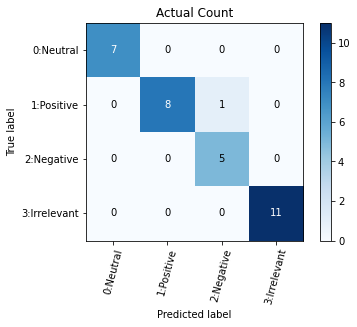

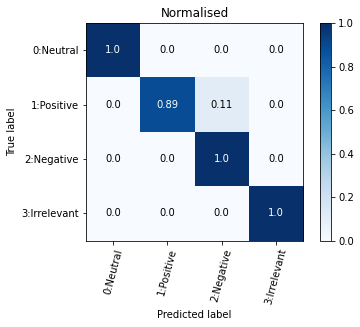

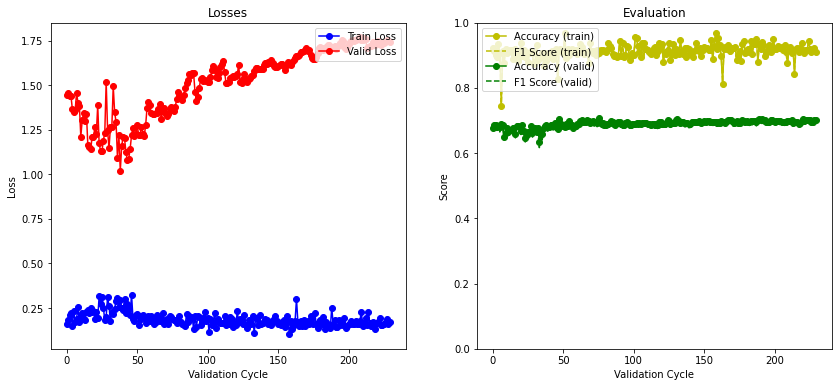

Epoch:  64%|██████▍   | 45/70 [06:48<03:55,  9.40s/it]

[2022-08-25 15:51:34,058][INFO] ## ================     epoch 46     ===============


INFO:sa_tweet_inperf:================     epoch 46     ===============
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:51:35,642][DEBUG] ## Epoch: 46/70, Step: 2530, Loss: 41.7206, Acc: 0.7005, F1: 0.6899


DEBUG:sa_tweet_inperf:Epoch: 46/70, Step: 2530, Loss: 41.7206, Acc: 0.7005, F1: 0.6899
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:51:37,332][DEBUG] ## Epoch: 46/70, Step: 2541, Loss: 41.7220, Acc: 0.6992, F1: 0.6878


DEBUG:sa_tweet_inperf:Epoch: 46/70, Step: 2541, Loss: 41.7220, Acc: 0.6992, F1: 0.6878
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:51:39,025][DEBUG] ## Epoch: 46/70, Step: 2552, Loss: 41.6101, Acc: 0.7018, F1: 0.6898


DEBUG:sa_tweet_inperf:Epoch: 46/70, Step: 2552, Loss: 41.6101, Acc: 0.7018, F1: 0.6898
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:51:40,728][DEBUG] ## Epoch: 46/70, Step: 2563, Loss: 41.7103, Acc: 0.7031, F1: 0.6914


DEBUG:sa_tweet_inperf:Epoch: 46/70, Step: 2563, Loss: 41.7103, Acc: 0.7031, F1: 0.6914
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:51:42,421][DEBUG] ## Epoch: 46/70, Step: 2574, Loss: 41.8755, Acc: 0.7018, F1: 0.6918


DEBUG:sa_tweet_inperf:Epoch: 46/70, Step: 2574, Loss: 41.8755, Acc: 0.7018, F1: 0.6918


[2022-08-25 15:51:42,594][INFO] ## Epoch: 46, Loss: 1.7448, Acc: 0.7018, F1: 0.6918, LR: 1.18e-04


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
INFO:sa_tweet_inperf:Epoch: 46, Loss: 1.7448, Acc: 0.7018, F1: 0.6918, LR: 1.18e-04


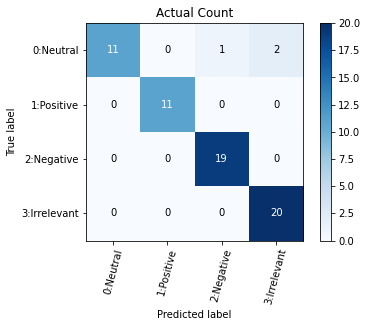

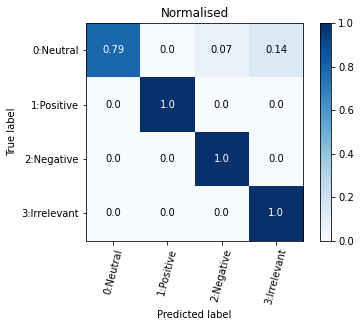

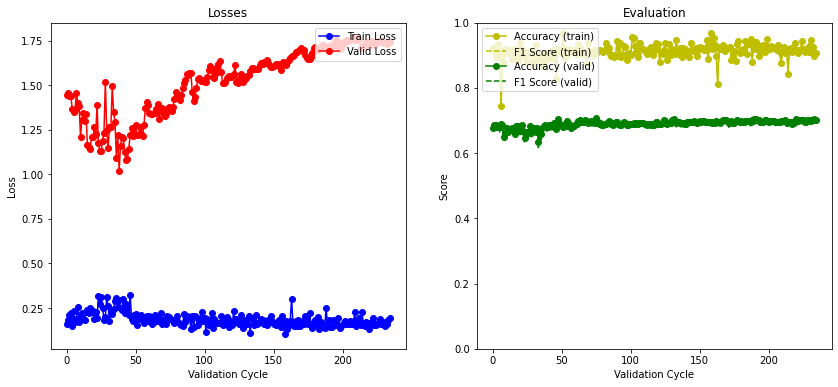

Epoch:  66%|██████▌   | 46/70 [06:57<03:44,  9.35s/it]

[2022-08-25 15:51:43,279][INFO] ## ================     epoch 47     ===============


INFO:sa_tweet_inperf:================     epoch 47     ===============
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:51:44,792][DEBUG] ## Epoch: 47/70, Step: 2585, Loss: 42.0650, Acc: 0.7018, F1: 0.6910


DEBUG:sa_tweet_inperf:Epoch: 47/70, Step: 2585, Loss: 42.0650, Acc: 0.7018, F1: 0.6910
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:51:46,490][DEBUG] ## Epoch: 47/70, Step: 2596, Loss: 42.3922, Acc: 0.7018, F1: 0.6929


DEBUG:sa_tweet_inperf:Epoch: 47/70, Step: 2596, Loss: 42.3922, Acc: 0.7018, F1: 0.6929
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:51:48,181][DEBUG] ## Epoch: 47/70, Step: 2607, Loss: 42.4373, Acc: 0.7005, F1: 0.6915


DEBUG:sa_tweet_inperf:Epoch: 47/70, Step: 2607, Loss: 42.4373, Acc: 0.7005, F1: 0.6915
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:51:49,871][DEBUG] ## Epoch: 47/70, Step: 2618, Loss: 42.1205, Acc: 0.7018, F1: 0.6918


DEBUG:sa_tweet_inperf:Epoch: 47/70, Step: 2618, Loss: 42.1205, Acc: 0.7018, F1: 0.6918
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:51:51,570][DEBUG] ## Epoch: 47/70, Step: 2629, Loss: 42.1170, Acc: 0.7018, F1: 0.6901


DEBUG:sa_tweet_inperf:Epoch: 47/70, Step: 2629, Loss: 42.1170, Acc: 0.7018, F1: 0.6901
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:51:51,837][INFO] ## Epoch: 47, Loss: 1.7549, Acc: 0.7018, F1: 0.6901, LR: 1.13e-04


INFO:sa_tweet_inperf:Epoch: 47, Loss: 1.7549, Acc: 0.7018, F1: 0.6901, LR: 1.13e-04


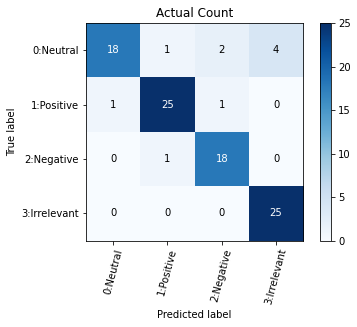

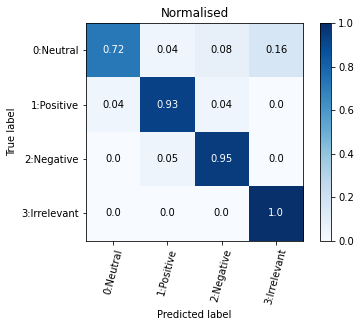

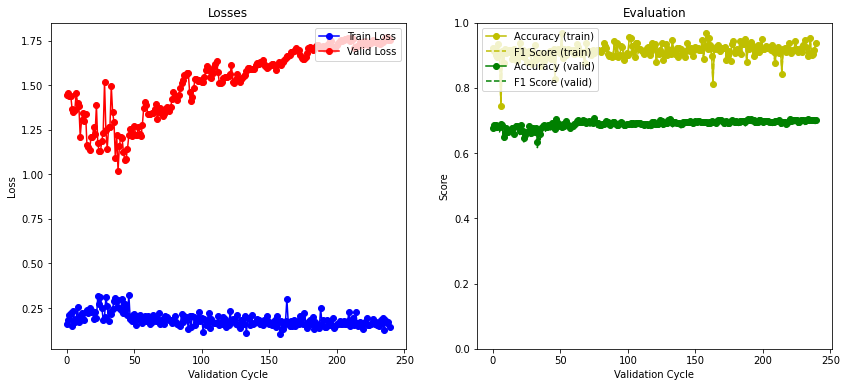

Epoch:  67%|██████▋   | 47/70 [07:06<03:34,  9.31s/it]

[2022-08-25 15:51:52,526][INFO] ## ================     epoch 48     ===============


INFO:sa_tweet_inperf:================     epoch 48     ===============
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:51:53,959][DEBUG] ## Epoch: 48/70, Step: 2640, Loss: 42.3227, Acc: 0.7018, F1: 0.6903


DEBUG:sa_tweet_inperf:Epoch: 48/70, Step: 2640, Loss: 42.3227, Acc: 0.7018, F1: 0.6903
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:51:55,658][DEBUG] ## Epoch: 48/70, Step: 2651, Loss: 42.5588, Acc: 0.6992, F1: 0.6877


DEBUG:sa_tweet_inperf:Epoch: 48/70, Step: 2651, Loss: 42.5588, Acc: 0.6992, F1: 0.6877
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:51:57,353][DEBUG] ## Epoch: 48/70, Step: 2662, Loss: 42.7807, Acc: 0.6979, F1: 0.6860


DEBUG:sa_tweet_inperf:Epoch: 48/70, Step: 2662, Loss: 42.7807, Acc: 0.6979, F1: 0.6860
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:51:59,043][DEBUG] ## Epoch: 48/70, Step: 2673, Loss: 42.5133, Acc: 0.7031, F1: 0.6935


DEBUG:sa_tweet_inperf:Epoch: 48/70, Step: 2673, Loss: 42.5133, Acc: 0.7031, F1: 0.6935
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:52:00,742][DEBUG] ## Epoch: 48/70, Step: 2684, Loss: 42.4790, Acc: 0.7057, F1: 0.6957


DEBUG:sa_tweet_inperf:Epoch: 48/70, Step: 2684, Loss: 42.4790, Acc: 0.7057, F1: 0.6957
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:52:01,098][INFO] ## Epoch: 48, Loss: 1.7700, Acc: 0.7057, F1: 0.6957, LR: 1.09e-04


INFO:sa_tweet_inperf:Epoch: 48, Loss: 1.7700, Acc: 0.7057, F1: 0.6957, LR: 1.09e-04


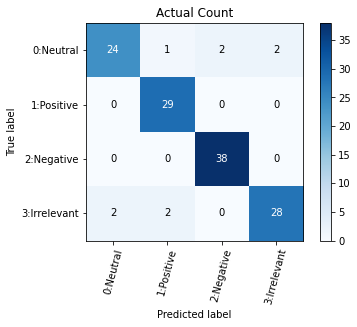

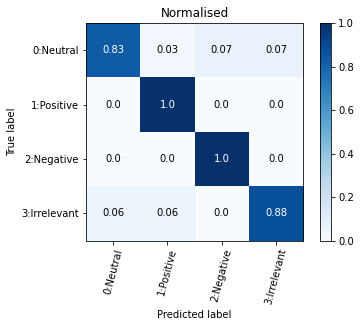

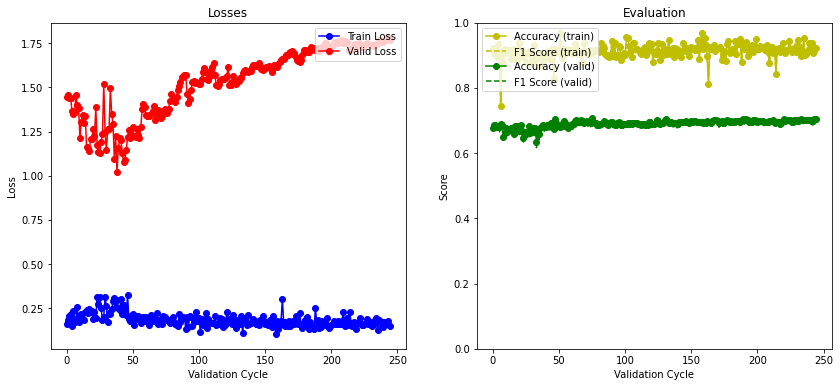

Epoch:  69%|██████▊   | 48/70 [07:16<03:24,  9.31s/it]

[2022-08-25 15:52:01,817][INFO] ## ================     epoch 49     ===============


INFO:sa_tweet_inperf:================     epoch 49     ===============
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:52:03,140][DEBUG] ## Epoch: 49/70, Step: 2695, Loss: 42.4270, Acc: 0.7044, F1: 0.6936


DEBUG:sa_tweet_inperf:Epoch: 49/70, Step: 2695, Loss: 42.4270, Acc: 0.7044, F1: 0.6936
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:52:04,827][DEBUG] ## Epoch: 49/70, Step: 2706, Loss: 42.6777, Acc: 0.7005, F1: 0.6897


DEBUG:sa_tweet_inperf:Epoch: 49/70, Step: 2706, Loss: 42.6777, Acc: 0.7005, F1: 0.6897
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:52:06,526][DEBUG] ## Epoch: 49/70, Step: 2717, Loss: 42.8075, Acc: 0.6992, F1: 0.6885


DEBUG:sa_tweet_inperf:Epoch: 49/70, Step: 2717, Loss: 42.8075, Acc: 0.6992, F1: 0.6885
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:52:08,222][DEBUG] ## Epoch: 49/70, Step: 2728, Loss: 42.9046, Acc: 0.6979, F1: 0.6873


DEBUG:sa_tweet_inperf:Epoch: 49/70, Step: 2728, Loss: 42.9046, Acc: 0.6979, F1: 0.6873
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:52:09,918][DEBUG] ## Epoch: 49/70, Step: 2739, Loss: 42.9671, Acc: 0.6992, F1: 0.6891


DEBUG:sa_tweet_inperf:Epoch: 49/70, Step: 2739, Loss: 42.9671, Acc: 0.6992, F1: 0.6891
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:52:10,373][INFO] ## Epoch: 49, Loss: 1.7903, Acc: 0.6992, F1: 0.6891, LR: 1.04e-04


INFO:sa_tweet_inperf:Epoch: 49, Loss: 1.7903, Acc: 0.6992, F1: 0.6891, LR: 1.04e-04


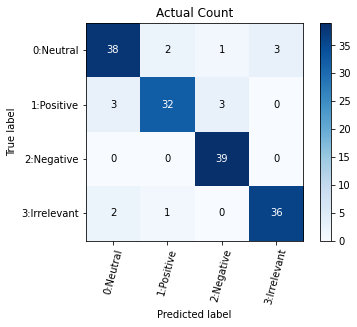

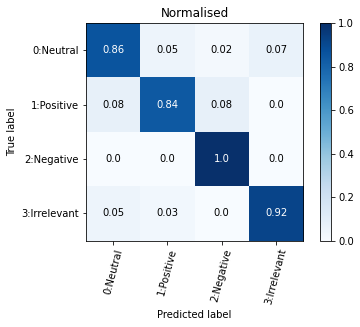

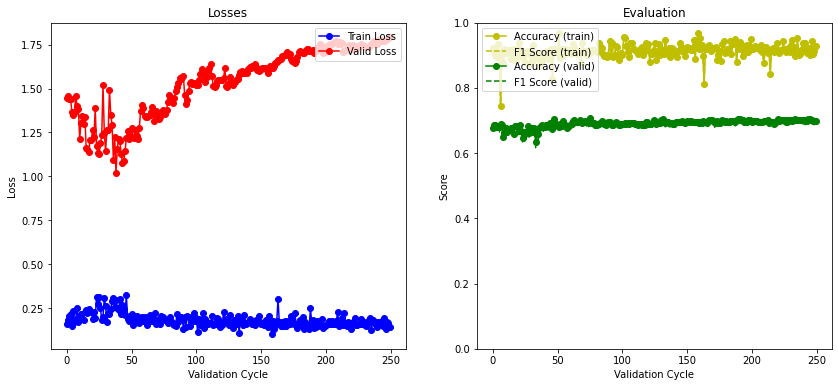

Epoch:  70%|███████   | 49/70 [07:25<03:15,  9.30s/it]

[2022-08-25 15:52:11,086][INFO] ## ================     epoch 50     ===============


INFO:sa_tweet_inperf:================     epoch 50     ===============
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:52:12,326][DEBUG] ## Epoch: 50/70, Step: 2750, Loss: 42.7969, Acc: 0.7005, F1: 0.6903


DEBUG:sa_tweet_inperf:Epoch: 50/70, Step: 2750, Loss: 42.7969, Acc: 0.7005, F1: 0.6903
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:52:14,010][DEBUG] ## Epoch: 50/70, Step: 2761, Loss: 42.7132, Acc: 0.7018, F1: 0.6911


DEBUG:sa_tweet_inperf:Epoch: 50/70, Step: 2761, Loss: 42.7132, Acc: 0.7018, F1: 0.6911
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:52:15,703][DEBUG] ## Epoch: 50/70, Step: 2772, Loss: 42.6778, Acc: 0.7018, F1: 0.6913


DEBUG:sa_tweet_inperf:Epoch: 50/70, Step: 2772, Loss: 42.6778, Acc: 0.7018, F1: 0.6913
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:52:17,391][DEBUG] ## Epoch: 50/70, Step: 2783, Loss: 42.7449, Acc: 0.7005, F1: 0.6901


DEBUG:sa_tweet_inperf:Epoch: 50/70, Step: 2783, Loss: 42.7449, Acc: 0.7005, F1: 0.6901
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:52:19,085][DEBUG] ## Epoch: 50/70, Step: 2794, Loss: 42.9500, Acc: 0.6979, F1: 0.6876


DEBUG:sa_tweet_inperf:Epoch: 50/70, Step: 2794, Loss: 42.9500, Acc: 0.6979, F1: 0.6876
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:52:19,623][INFO] ## Epoch: 50, Loss: 1.7896, Acc: 0.6979, F1: 0.6876, LR: 9.94e-05


INFO:sa_tweet_inperf:Epoch: 50, Loss: 1.7896, Acc: 0.6979, F1: 0.6876, LR: 9.94e-05


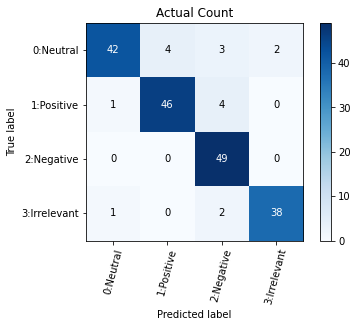

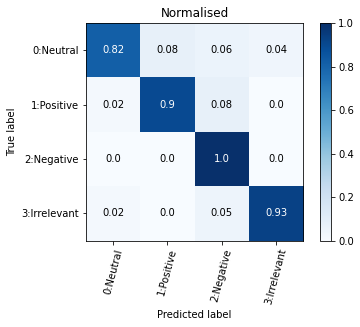

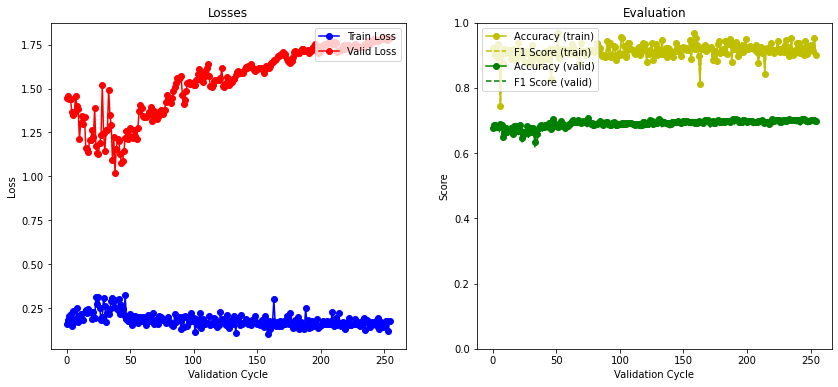

Epoch:  71%|███████▏  | 50/70 [07:34<03:07,  9.35s/it]

[2022-08-25 15:52:20,559][INFO] ## ================     epoch 51     ===============


INFO:sa_tweet_inperf:================     epoch 51     ===============
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:52:21,697][DEBUG] ## Epoch: 51/70, Step: 2805, Loss: 42.9734, Acc: 0.6992, F1: 0.6897


DEBUG:sa_tweet_inperf:Epoch: 51/70, Step: 2805, Loss: 42.9734, Acc: 0.6992, F1: 0.6897
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:52:23,386][DEBUG] ## Epoch: 51/70, Step: 2816, Loss: 43.0577, Acc: 0.6992, F1: 0.6894


DEBUG:sa_tweet_inperf:Epoch: 51/70, Step: 2816, Loss: 43.0577, Acc: 0.6992, F1: 0.6894
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:52:25,073][DEBUG] ## Epoch: 51/70, Step: 2827, Loss: 43.2024, Acc: 0.7005, F1: 0.6893


DEBUG:sa_tweet_inperf:Epoch: 51/70, Step: 2827, Loss: 43.2024, Acc: 0.7005, F1: 0.6893
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:52:26,748][DEBUG] ## Epoch: 51/70, Step: 2838, Loss: 43.2916, Acc: 0.6966, F1: 0.6867


DEBUG:sa_tweet_inperf:Epoch: 51/70, Step: 2838, Loss: 43.2916, Acc: 0.6966, F1: 0.6867
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:52:28,451][DEBUG] ## Epoch: 51/70, Step: 2849, Loss: 43.3481, Acc: 0.6966, F1: 0.6866


DEBUG:sa_tweet_inperf:Epoch: 51/70, Step: 2849, Loss: 43.3481, Acc: 0.6966, F1: 0.6866
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:52:29,082][INFO] ## Epoch: 51, Loss: 1.8062, Acc: 0.6966, F1: 0.6866, LR: 9.47e-05


INFO:sa_tweet_inperf:Epoch: 51, Loss: 1.8062, Acc: 0.6966, F1: 0.6866, LR: 9.47e-05


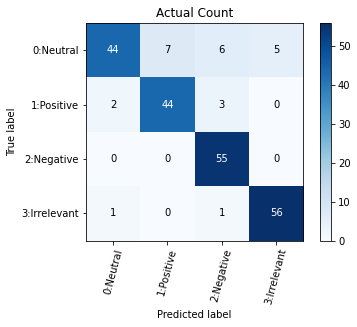

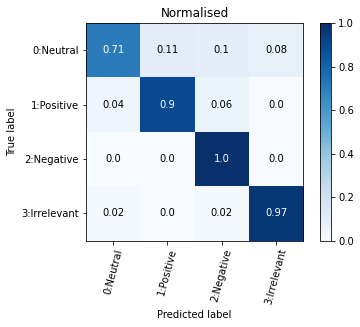

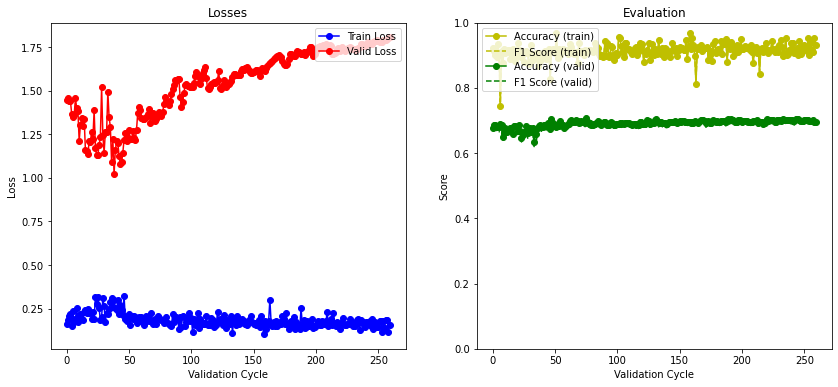

Epoch:  73%|███████▎  | 51/70 [07:44<02:57,  9.32s/it]

[2022-08-25 15:52:29,802][INFO] ## ================     epoch 52     ===============


INFO:sa_tweet_inperf:================     epoch 52     ===============
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:52:30,870][DEBUG] ## Epoch: 52/70, Step: 2860, Loss: 43.2952, Acc: 0.6940, F1: 0.6848


DEBUG:sa_tweet_inperf:Epoch: 52/70, Step: 2860, Loss: 43.2952, Acc: 0.6940, F1: 0.6848
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:52:32,549][DEBUG] ## Epoch: 52/70, Step: 2871, Loss: 43.3121, Acc: 0.6953, F1: 0.6858


DEBUG:sa_tweet_inperf:Epoch: 52/70, Step: 2871, Loss: 43.3121, Acc: 0.6953, F1: 0.6858
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:52:34,246][DEBUG] ## Epoch: 52/70, Step: 2882, Loss: 43.1855, Acc: 0.6992, F1: 0.6884


DEBUG:sa_tweet_inperf:Epoch: 52/70, Step: 2882, Loss: 43.1855, Acc: 0.6992, F1: 0.6884
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:52:35,930][DEBUG] ## Epoch: 52/70, Step: 2893, Loss: 43.2899, Acc: 0.6966, F1: 0.6860


DEBUG:sa_tweet_inperf:Epoch: 52/70, Step: 2893, Loss: 43.2899, Acc: 0.6966, F1: 0.6860
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:52:37,622][DEBUG] ## Epoch: 52/70, Step: 2904, Loss: 43.3915, Acc: 0.6940, F1: 0.6845


DEBUG:sa_tweet_inperf:Epoch: 52/70, Step: 2904, Loss: 43.3915, Acc: 0.6940, F1: 0.6845
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:52:38,342][INFO] ## Epoch: 52, Loss: 1.8080, Acc: 0.6940, F1: 0.6845, LR: 9.01e-05


INFO:sa_tweet_inperf:Epoch: 52, Loss: 1.8080, Acc: 0.6940, F1: 0.6845, LR: 9.01e-05


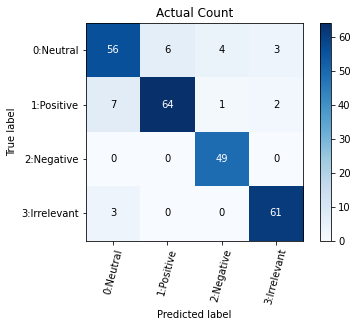

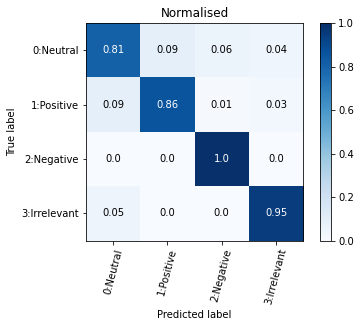

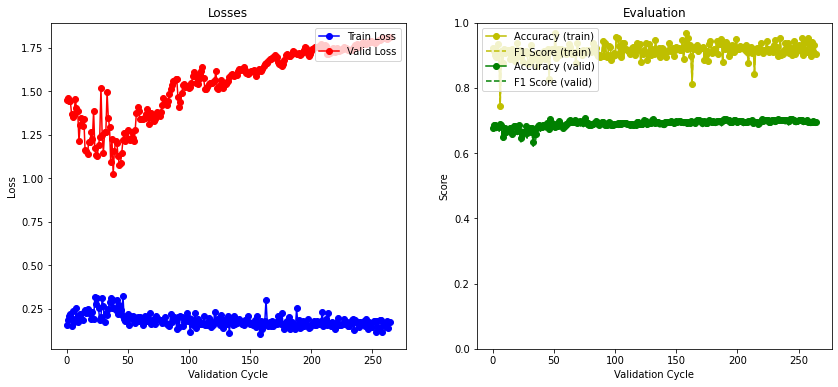

Epoch:  74%|███████▍  | 52/70 [07:53<02:47,  9.30s/it]

[2022-08-25 15:52:39,063][INFO] ## ================     epoch 53     ===============


INFO:sa_tweet_inperf:================     epoch 53     ===============
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:52:40,024][DEBUG] ## Epoch: 53/70, Step: 2915, Loss: 43.5064, Acc: 0.6940, F1: 0.6851


DEBUG:sa_tweet_inperf:Epoch: 53/70, Step: 2915, Loss: 43.5064, Acc: 0.6940, F1: 0.6851
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:52:41,707][DEBUG] ## Epoch: 53/70, Step: 2926, Loss: 43.7007, Acc: 0.6940, F1: 0.6849


DEBUG:sa_tweet_inperf:Epoch: 53/70, Step: 2926, Loss: 43.7007, Acc: 0.6940, F1: 0.6849
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:52:43,409][DEBUG] ## Epoch: 53/70, Step: 2937, Loss: 43.7238, Acc: 0.6966, F1: 0.6874


DEBUG:sa_tweet_inperf:Epoch: 53/70, Step: 2937, Loss: 43.7238, Acc: 0.6966, F1: 0.6874
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:52:45,092][DEBUG] ## Epoch: 53/70, Step: 2948, Loss: 43.5597, Acc: 0.6940, F1: 0.6843


DEBUG:sa_tweet_inperf:Epoch: 53/70, Step: 2948, Loss: 43.5597, Acc: 0.6940, F1: 0.6843
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:52:46,779][DEBUG] ## Epoch: 53/70, Step: 2959, Loss: 43.4734, Acc: 0.6953, F1: 0.6859


DEBUG:sa_tweet_inperf:Epoch: 53/70, Step: 2959, Loss: 43.4734, Acc: 0.6953, F1: 0.6859
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:52:47,591][INFO] ## Epoch: 53, Loss: 1.8114, Acc: 0.6953, F1: 0.6859, LR: 8.54e-05


INFO:sa_tweet_inperf:Epoch: 53, Loss: 1.8114, Acc: 0.6953, F1: 0.6859, LR: 8.54e-05


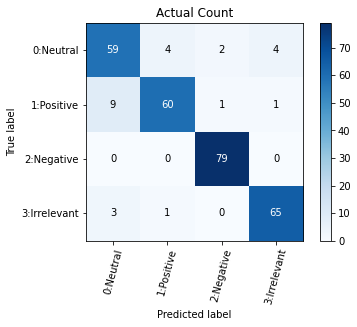

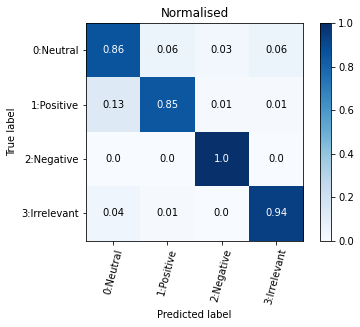

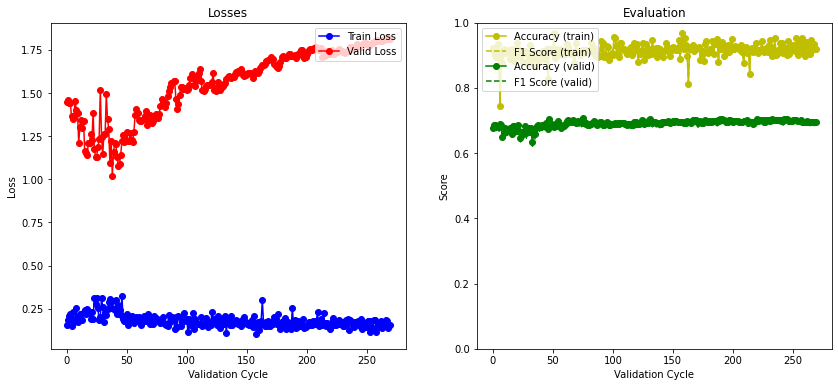

Epoch:  76%|███████▌  | 53/70 [08:02<02:37,  9.28s/it]

[2022-08-25 15:52:48,276][INFO] ## ================     epoch 54     ===============


INFO:sa_tweet_inperf:================     epoch 54     ===============
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:52:49,133][DEBUG] ## Epoch: 54/70, Step: 2970, Loss: 43.4845, Acc: 0.6953, F1: 0.6862


DEBUG:sa_tweet_inperf:Epoch: 54/70, Step: 2970, Loss: 43.4845, Acc: 0.6953, F1: 0.6862
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:52:50,832][DEBUG] ## Epoch: 54/70, Step: 2981, Loss: 43.7561, Acc: 0.6979, F1: 0.6885


DEBUG:sa_tweet_inperf:Epoch: 54/70, Step: 2981, Loss: 43.7561, Acc: 0.6979, F1: 0.6885
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:52:52,526][DEBUG] ## Epoch: 54/70, Step: 2992, Loss: 43.8258, Acc: 0.6979, F1: 0.6884


DEBUG:sa_tweet_inperf:Epoch: 54/70, Step: 2992, Loss: 43.8258, Acc: 0.6979, F1: 0.6884
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:52:54,215][DEBUG] ## Epoch: 54/70, Step: 3003, Loss: 43.7185, Acc: 0.6966, F1: 0.6874


DEBUG:sa_tweet_inperf:Epoch: 54/70, Step: 3003, Loss: 43.7185, Acc: 0.6966, F1: 0.6874
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:52:55,906][DEBUG] ## Epoch: 54/70, Step: 3014, Loss: 43.7517, Acc: 0.6940, F1: 0.6846


DEBUG:sa_tweet_inperf:Epoch: 54/70, Step: 3014, Loss: 43.7517, Acc: 0.6940, F1: 0.6846
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:52:56,806][INFO] ## Epoch: 54, Loss: 1.8230, Acc: 0.6940, F1: 0.6846, LR: 8.07e-05


INFO:sa_tweet_inperf:Epoch: 54, Loss: 1.8230, Acc: 0.6940, F1: 0.6846, LR: 8.07e-05


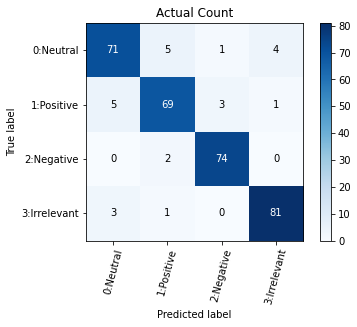

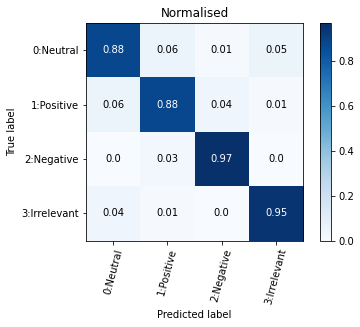

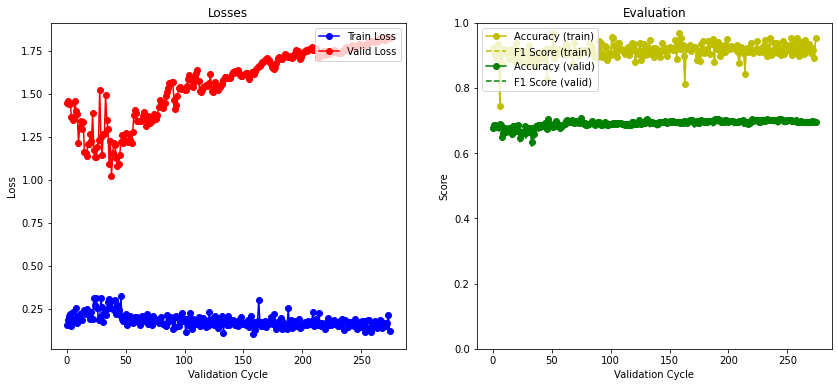

Epoch:  77%|███████▋  | 54/70 [08:11<02:28,  9.26s/it]

[2022-08-25 15:52:57,486][INFO] ## ================     epoch 55     ===============


INFO:sa_tweet_inperf:================     epoch 55     ===============
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:52:58,249][DEBUG] ## Epoch: 55/70, Step: 3025, Loss: 43.5704, Acc: 0.6927, F1: 0.6831


DEBUG:sa_tweet_inperf:Epoch: 55/70, Step: 3025, Loss: 43.5704, Acc: 0.6927, F1: 0.6831
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:52:59,955][DEBUG] ## Epoch: 55/70, Step: 3036, Loss: 43.5269, Acc: 0.6992, F1: 0.6887


DEBUG:sa_tweet_inperf:Epoch: 55/70, Step: 3036, Loss: 43.5269, Acc: 0.6992, F1: 0.6887
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:53:01,656][DEBUG] ## Epoch: 55/70, Step: 3047, Loss: 43.6031, Acc: 0.6979, F1: 0.6868


DEBUG:sa_tweet_inperf:Epoch: 55/70, Step: 3047, Loss: 43.6031, Acc: 0.6979, F1: 0.6868
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:53:03,356][DEBUG] ## Epoch: 55/70, Step: 3058, Loss: 43.7534, Acc: 0.6979, F1: 0.6874


DEBUG:sa_tweet_inperf:Epoch: 55/70, Step: 3058, Loss: 43.7534, Acc: 0.6979, F1: 0.6874
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:53:05,051][DEBUG] ## Epoch: 55/70, Step: 3069, Loss: 43.9312, Acc: 0.6992, F1: 0.6886


DEBUG:sa_tweet_inperf:Epoch: 55/70, Step: 3069, Loss: 43.9312, Acc: 0.6992, F1: 0.6886
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:53:06,740][DEBUG] ## Epoch: 55/70, Step: 3080, Loss: 43.8203, Acc: 0.6979, F1: 0.6871


DEBUG:sa_tweet_inperf:Epoch: 55/70, Step: 3080, Loss: 43.8203, Acc: 0.6979, F1: 0.6871


[2022-08-25 15:53:06,744][INFO] ## Epoch: 55, Loss: 1.8258, Acc: 0.6979, F1: 0.6871, LR: 7.60e-05


INFO:sa_tweet_inperf:Epoch: 55, Loss: 1.8258, Acc: 0.6979, F1: 0.6871, LR: 7.60e-05


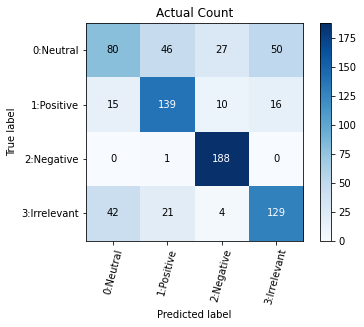

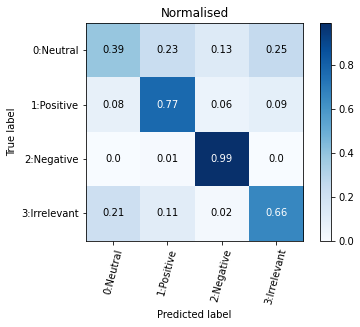

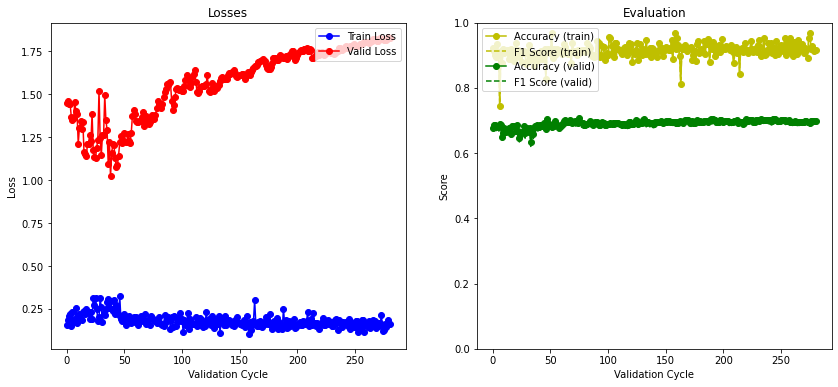

Epoch:  79%|███████▊  | 55/70 [08:21<02:22,  9.48s/it]

[2022-08-25 15:53:07,503][INFO] ## ================     epoch 56     ===============


INFO:sa_tweet_inperf:================     epoch 56     ===============
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:53:09,190][DEBUG] ## Epoch: 56/70, Step: 3091, Loss: 43.6996, Acc: 0.6992, F1: 0.6892


DEBUG:sa_tweet_inperf:Epoch: 56/70, Step: 3091, Loss: 43.6996, Acc: 0.6992, F1: 0.6892
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:53:10,888][DEBUG] ## Epoch: 56/70, Step: 3102, Loss: 43.7251, Acc: 0.6966, F1: 0.6870


DEBUG:sa_tweet_inperf:Epoch: 56/70, Step: 3102, Loss: 43.7251, Acc: 0.6966, F1: 0.6870
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:53:12,580][DEBUG] ## Epoch: 56/70, Step: 3113, Loss: 43.8079, Acc: 0.6979, F1: 0.6883


DEBUG:sa_tweet_inperf:Epoch: 56/70, Step: 3113, Loss: 43.8079, Acc: 0.6979, F1: 0.6883
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:53:14,282][DEBUG] ## Epoch: 56/70, Step: 3124, Loss: 43.8222, Acc: 0.6979, F1: 0.6883


DEBUG:sa_tweet_inperf:Epoch: 56/70, Step: 3124, Loss: 43.8222, Acc: 0.6979, F1: 0.6883
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:53:15,982][DEBUG] ## Epoch: 56/70, Step: 3135, Loss: 43.8636, Acc: 0.7005, F1: 0.6900


DEBUG:sa_tweet_inperf:Epoch: 56/70, Step: 3135, Loss: 43.8636, Acc: 0.7005, F1: 0.6900


[2022-08-25 15:53:16,065][INFO] ## Epoch: 56, Loss: 1.8276, Acc: 0.7005, F1: 0.6900, LR: 7.13e-05


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
INFO:sa_tweet_inperf:Epoch: 56, Loss: 1.8276, Acc: 0.7005, F1: 0.6900, LR: 7.13e-05


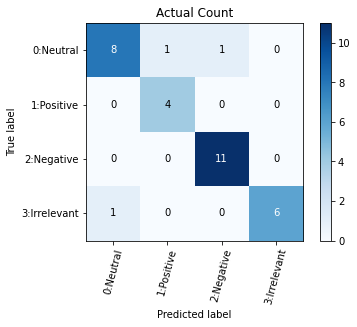

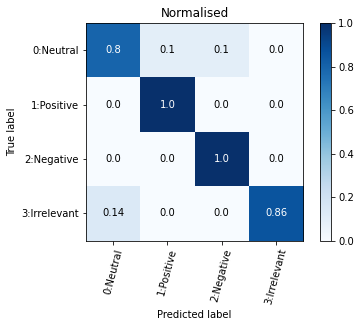

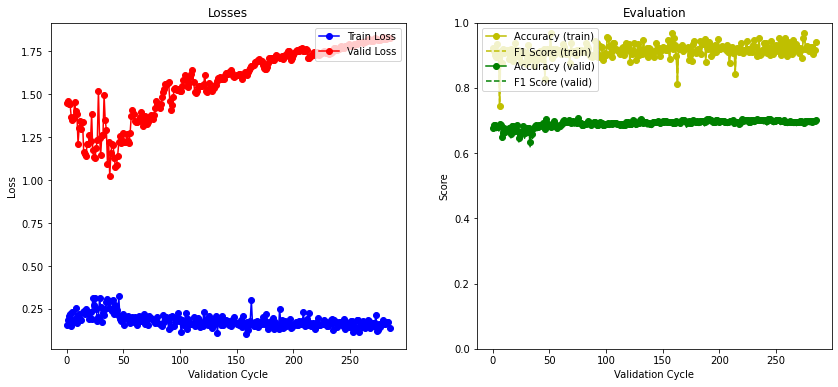

Epoch:  80%|████████  | 56/70 [08:31<02:11,  9.43s/it]

[2022-08-25 15:53:16,796][INFO] ## ================     epoch 57     ===============


INFO:sa_tweet_inperf:================     epoch 57     ===============
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:53:18,389][DEBUG] ## Epoch: 57/70, Step: 3146, Loss: 43.8160, Acc: 0.6953, F1: 0.6851


DEBUG:sa_tweet_inperf:Epoch: 57/70, Step: 3146, Loss: 43.8160, Acc: 0.6953, F1: 0.6851
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:53:20,094][DEBUG] ## Epoch: 57/70, Step: 3157, Loss: 43.8569, Acc: 0.6979, F1: 0.6874


DEBUG:sa_tweet_inperf:Epoch: 57/70, Step: 3157, Loss: 43.8569, Acc: 0.6979, F1: 0.6874
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:53:21,785][DEBUG] ## Epoch: 57/70, Step: 3168, Loss: 43.8848, Acc: 0.6940, F1: 0.6834


DEBUG:sa_tweet_inperf:Epoch: 57/70, Step: 3168, Loss: 43.8848, Acc: 0.6940, F1: 0.6834
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:53:23,485][DEBUG] ## Epoch: 57/70, Step: 3179, Loss: 43.9671, Acc: 0.6979, F1: 0.6882


DEBUG:sa_tweet_inperf:Epoch: 57/70, Step: 3179, Loss: 43.9671, Acc: 0.6979, F1: 0.6882
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:53:25,192][DEBUG] ## Epoch: 57/70, Step: 3190, Loss: 44.0794, Acc: 0.7005, F1: 0.6894


DEBUG:sa_tweet_inperf:Epoch: 57/70, Step: 3190, Loss: 44.0794, Acc: 0.7005, F1: 0.6894


[2022-08-25 15:53:25,365][INFO] ## Epoch: 57, Loss: 1.8366, Acc: 0.7005, F1: 0.6894, LR: 6.67e-05


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
INFO:sa_tweet_inperf:Epoch: 57, Loss: 1.8366, Acc: 0.7005, F1: 0.6894, LR: 6.67e-05


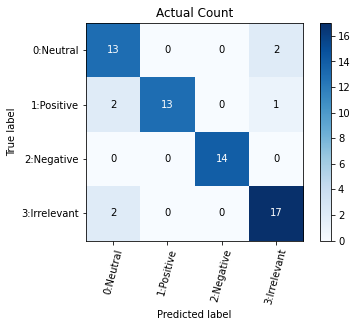

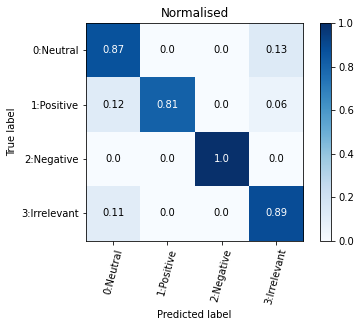

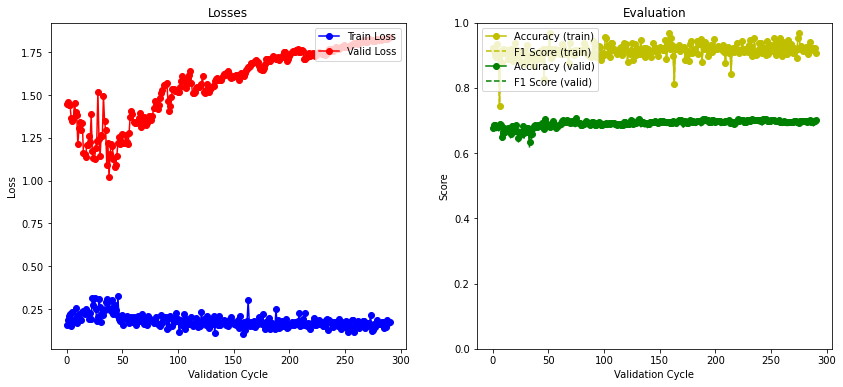

Epoch:  81%|████████▏ | 57/70 [08:40<02:02,  9.45s/it]

[2022-08-25 15:53:26,304][INFO] ## ================     epoch 58     ===============


INFO:sa_tweet_inperf:================     epoch 58     ===============
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:53:27,823][DEBUG] ## Epoch: 58/70, Step: 3201, Loss: 44.2205, Acc: 0.6927, F1: 0.6818


DEBUG:sa_tweet_inperf:Epoch: 58/70, Step: 3201, Loss: 44.2205, Acc: 0.6927, F1: 0.6818
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:53:29,516][DEBUG] ## Epoch: 58/70, Step: 3212, Loss: 44.3881, Acc: 0.6940, F1: 0.6834


DEBUG:sa_tweet_inperf:Epoch: 58/70, Step: 3212, Loss: 44.3881, Acc: 0.6940, F1: 0.6834
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:53:31,219][DEBUG] ## Epoch: 58/70, Step: 3223, Loss: 44.5053, Acc: 0.6927, F1: 0.6818


DEBUG:sa_tweet_inperf:Epoch: 58/70, Step: 3223, Loss: 44.5053, Acc: 0.6927, F1: 0.6818
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:53:32,910][DEBUG] ## Epoch: 58/70, Step: 3234, Loss: 44.4620, Acc: 0.6953, F1: 0.6849


DEBUG:sa_tweet_inperf:Epoch: 58/70, Step: 3234, Loss: 44.4620, Acc: 0.6953, F1: 0.6849
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:53:34,614][DEBUG] ## Epoch: 58/70, Step: 3245, Loss: 44.5788, Acc: 0.6914, F1: 0.6806


DEBUG:sa_tweet_inperf:Epoch: 58/70, Step: 3245, Loss: 44.5788, Acc: 0.6914, F1: 0.6806
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:53:34,882][INFO] ## Epoch: 58, Loss: 1.8575, Acc: 0.6914, F1: 0.6806, LR: 6.20e-05


INFO:sa_tweet_inperf:Epoch: 58, Loss: 1.8575, Acc: 0.6914, F1: 0.6806, LR: 6.20e-05


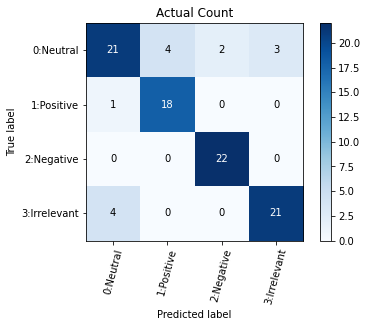

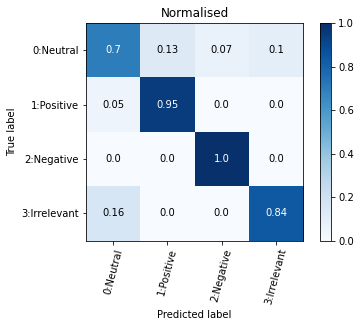

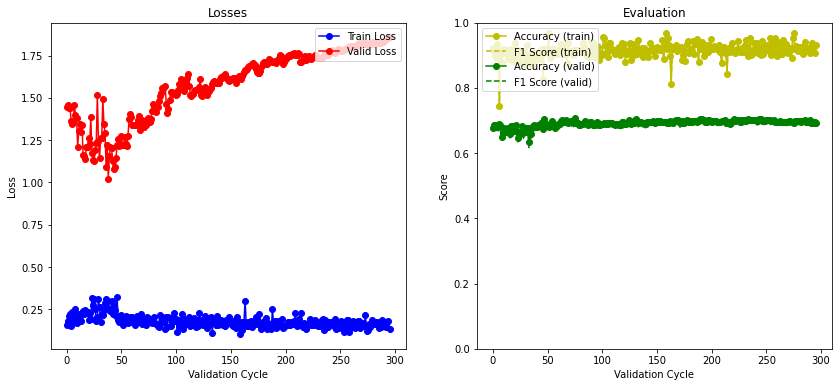

Epoch:  83%|████████▎ | 58/70 [08:49<01:52,  9.40s/it]

[2022-08-25 15:53:35,589][INFO] ## ================     epoch 59     ===============


INFO:sa_tweet_inperf:================     epoch 59     ===============
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:53:37,022][DEBUG] ## Epoch: 59/70, Step: 3256, Loss: 44.4090, Acc: 0.6953, F1: 0.6842


DEBUG:sa_tweet_inperf:Epoch: 59/70, Step: 3256, Loss: 44.4090, Acc: 0.6953, F1: 0.6842
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:53:38,727][DEBUG] ## Epoch: 59/70, Step: 3267, Loss: 44.4200, Acc: 0.6953, F1: 0.6842


DEBUG:sa_tweet_inperf:Epoch: 59/70, Step: 3267, Loss: 44.4200, Acc: 0.6953, F1: 0.6842
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:53:40,420][DEBUG] ## Epoch: 59/70, Step: 3278, Loss: 44.4539, Acc: 0.6940, F1: 0.6831


DEBUG:sa_tweet_inperf:Epoch: 59/70, Step: 3278, Loss: 44.4539, Acc: 0.6940, F1: 0.6831
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:53:42,126][DEBUG] ## Epoch: 59/70, Step: 3289, Loss: 44.4188, Acc: 0.6966, F1: 0.6857


DEBUG:sa_tweet_inperf:Epoch: 59/70, Step: 3289, Loss: 44.4188, Acc: 0.6966, F1: 0.6857
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:53:43,853][DEBUG] ## Epoch: 59/70, Step: 3300, Loss: 44.5017, Acc: 0.6966, F1: 0.6863


DEBUG:sa_tweet_inperf:Epoch: 59/70, Step: 3300, Loss: 44.5017, Acc: 0.6966, F1: 0.6863
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:53:44,218][INFO] ## Epoch: 59, Loss: 1.8542, Acc: 0.6966, F1: 0.6863, LR: 5.73e-05


INFO:sa_tweet_inperf:Epoch: 59, Loss: 1.8542, Acc: 0.6966, F1: 0.6863, LR: 5.73e-05


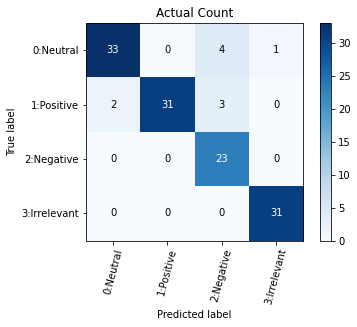

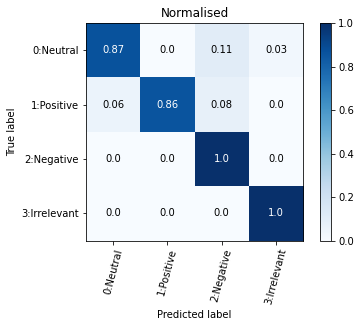

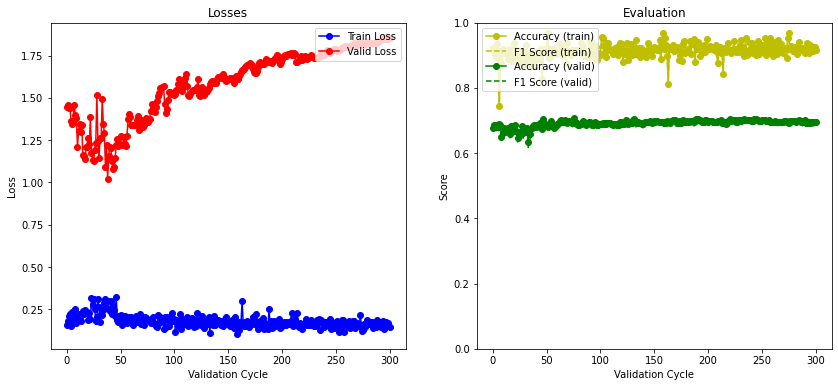

Epoch:  84%|████████▍ | 59/70 [08:59<01:43,  9.39s/it]

[2022-08-25 15:53:44,942][INFO] ## ================     epoch 60     ===============


INFO:sa_tweet_inperf:================     epoch 60     ===============
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:53:46,266][DEBUG] ## Epoch: 60/70, Step: 3311, Loss: 44.5207, Acc: 0.6966, F1: 0.6863


DEBUG:sa_tweet_inperf:Epoch: 60/70, Step: 3311, Loss: 44.5207, Acc: 0.6966, F1: 0.6863
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:53:47,966][DEBUG] ## Epoch: 60/70, Step: 3322, Loss: 44.5126, Acc: 0.6966, F1: 0.6858


DEBUG:sa_tweet_inperf:Epoch: 60/70, Step: 3322, Loss: 44.5126, Acc: 0.6966, F1: 0.6858
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:53:49,667][DEBUG] ## Epoch: 60/70, Step: 3333, Loss: 44.5818, Acc: 0.6927, F1: 0.6828


DEBUG:sa_tweet_inperf:Epoch: 60/70, Step: 3333, Loss: 44.5818, Acc: 0.6927, F1: 0.6828
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:53:51,365][DEBUG] ## Epoch: 60/70, Step: 3344, Loss: 44.6020, Acc: 0.6927, F1: 0.6826


DEBUG:sa_tweet_inperf:Epoch: 60/70, Step: 3344, Loss: 44.6020, Acc: 0.6927, F1: 0.6826
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:53:53,070][DEBUG] ## Epoch: 60/70, Step: 3355, Loss: 44.5739, Acc: 0.6953, F1: 0.6850


DEBUG:sa_tweet_inperf:Epoch: 60/70, Step: 3355, Loss: 44.5739, Acc: 0.6953, F1: 0.6850
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:53:53,515][INFO] ## Epoch: 60, Loss: 1.8572, Acc: 0.6953, F1: 0.6850, LR: 5.26e-05


INFO:sa_tweet_inperf:Epoch: 60, Loss: 1.8572, Acc: 0.6953, F1: 0.6850, LR: 5.26e-05


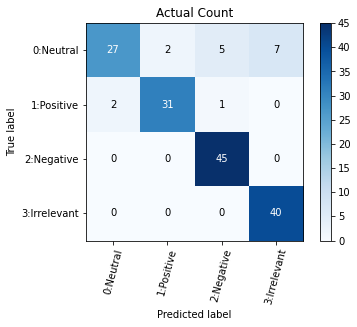

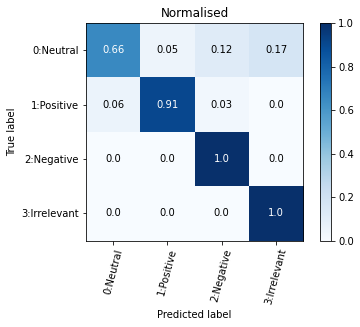

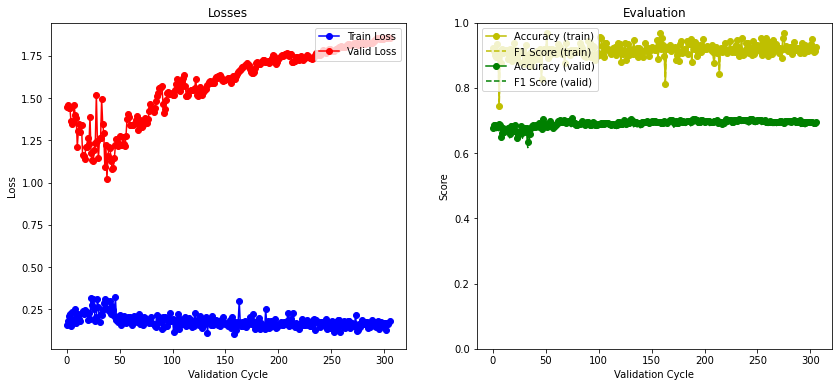

Epoch:  86%|████████▌ | 60/70 [09:08<01:33,  9.36s/it]

[2022-08-25 15:53:54,234][INFO] ## ================     epoch 61     ===============


INFO:sa_tweet_inperf:================     epoch 61     ===============
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:53:55,474][DEBUG] ## Epoch: 61/70, Step: 3366, Loss: 44.5142, Acc: 0.6966, F1: 0.6864


DEBUG:sa_tweet_inperf:Epoch: 61/70, Step: 3366, Loss: 44.5142, Acc: 0.6966, F1: 0.6864
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:53:57,165][DEBUG] ## Epoch: 61/70, Step: 3377, Loss: 44.4354, Acc: 0.6914, F1: 0.6815


DEBUG:sa_tweet_inperf:Epoch: 61/70, Step: 3377, Loss: 44.4354, Acc: 0.6914, F1: 0.6815
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:53:58,861][DEBUG] ## Epoch: 61/70, Step: 3388, Loss: 44.3949, Acc: 0.6940, F1: 0.6839


DEBUG:sa_tweet_inperf:Epoch: 61/70, Step: 3388, Loss: 44.3949, Acc: 0.6940, F1: 0.6839
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:54:00,567][DEBUG] ## Epoch: 61/70, Step: 3399, Loss: 44.2943, Acc: 0.6979, F1: 0.6881


DEBUG:sa_tweet_inperf:Epoch: 61/70, Step: 3399, Loss: 44.2943, Acc: 0.6979, F1: 0.6881
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:54:02,267][DEBUG] ## Epoch: 61/70, Step: 3410, Loss: 44.4311, Acc: 0.6953, F1: 0.6844


DEBUG:sa_tweet_inperf:Epoch: 61/70, Step: 3410, Loss: 44.4311, Acc: 0.6953, F1: 0.6844
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:54:02,804][INFO] ## Epoch: 61, Loss: 1.8513, Acc: 0.6953, F1: 0.6844, LR: 4.80e-05


INFO:sa_tweet_inperf:Epoch: 61, Loss: 1.8513, Acc: 0.6953, F1: 0.6844, LR: 4.80e-05


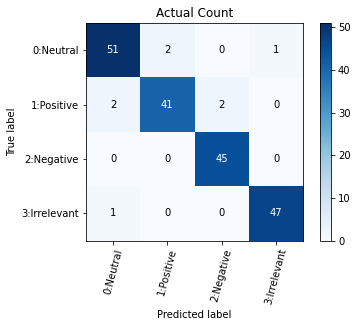

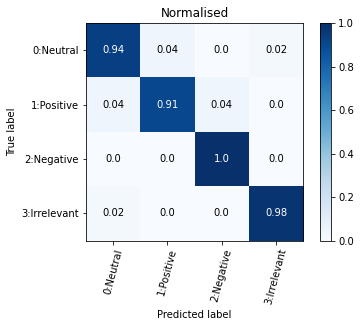

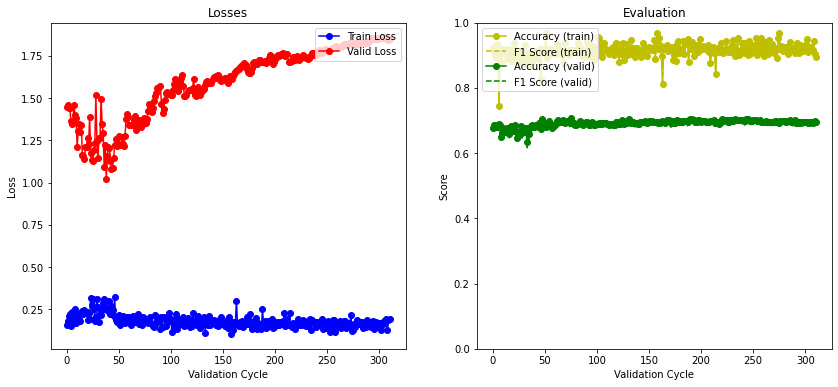

Epoch:  87%|████████▋ | 61/70 [09:17<01:24,  9.33s/it]

[2022-08-25 15:54:03,513][INFO] ## ================     epoch 62     ===============


INFO:sa_tweet_inperf:================     epoch 62     ===============
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:54:04,659][DEBUG] ## Epoch: 62/70, Step: 3421, Loss: 44.5257, Acc: 0.6966, F1: 0.6855


DEBUG:sa_tweet_inperf:Epoch: 62/70, Step: 3421, Loss: 44.5257, Acc: 0.6966, F1: 0.6855
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:54:06,351][DEBUG] ## Epoch: 62/70, Step: 3432, Loss: 44.5249, Acc: 0.6927, F1: 0.6818


DEBUG:sa_tweet_inperf:Epoch: 62/70, Step: 3432, Loss: 44.5249, Acc: 0.6927, F1: 0.6818
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:54:08,050][DEBUG] ## Epoch: 62/70, Step: 3443, Loss: 44.6354, Acc: 0.6927, F1: 0.6816


DEBUG:sa_tweet_inperf:Epoch: 62/70, Step: 3443, Loss: 44.6354, Acc: 0.6927, F1: 0.6816
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:54:09,738][DEBUG] ## Epoch: 62/70, Step: 3454, Loss: 44.7135, Acc: 0.6914, F1: 0.6804


DEBUG:sa_tweet_inperf:Epoch: 62/70, Step: 3454, Loss: 44.7135, Acc: 0.6914, F1: 0.6804
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:54:11,437][DEBUG] ## Epoch: 62/70, Step: 3465, Loss: 44.7343, Acc: 0.6953, F1: 0.6841


DEBUG:sa_tweet_inperf:Epoch: 62/70, Step: 3465, Loss: 44.7343, Acc: 0.6953, F1: 0.6841
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:54:12,077][INFO] ## Epoch: 62, Loss: 1.8639, Acc: 0.6953, F1: 0.6841, LR: 4.33e-05


INFO:sa_tweet_inperf:Epoch: 62, Loss: 1.8639, Acc: 0.6953, F1: 0.6841, LR: 4.33e-05


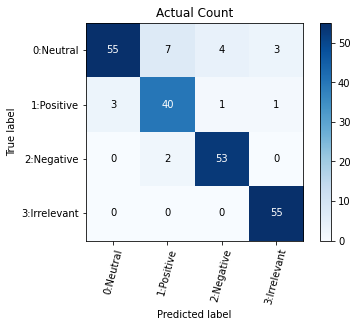

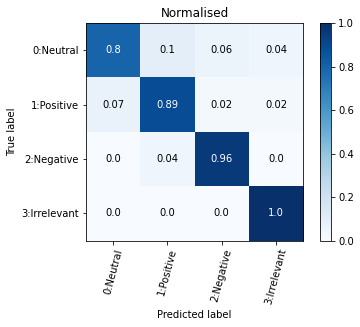

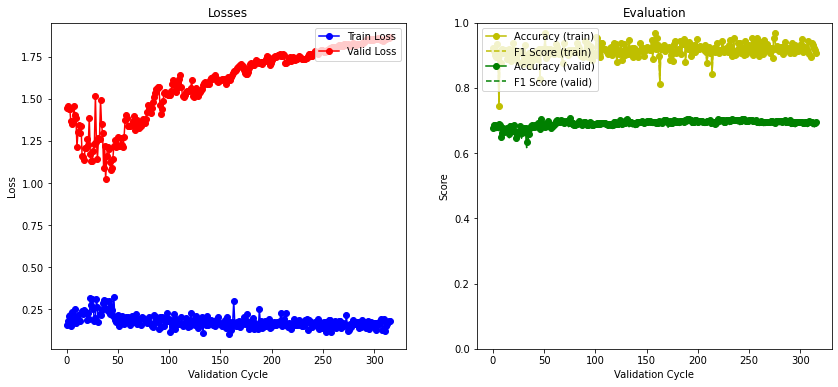

Epoch:  89%|████████▊ | 62/70 [09:27<01:14,  9.32s/it]

[2022-08-25 15:54:12,793][INFO] ## ================     epoch 63     ===============


INFO:sa_tweet_inperf:================     epoch 63     ===============
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:54:13,847][DEBUG] ## Epoch: 63/70, Step: 3476, Loss: 44.7203, Acc: 0.6953, F1: 0.6842


DEBUG:sa_tweet_inperf:Epoch: 63/70, Step: 3476, Loss: 44.7203, Acc: 0.6953, F1: 0.6842
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:54:15,545][DEBUG] ## Epoch: 63/70, Step: 3487, Loss: 44.5652, Acc: 0.6953, F1: 0.6850


DEBUG:sa_tweet_inperf:Epoch: 63/70, Step: 3487, Loss: 44.5652, Acc: 0.6953, F1: 0.6850
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:54:17,249][DEBUG] ## Epoch: 63/70, Step: 3498, Loss: 44.4442, Acc: 0.6992, F1: 0.6877


DEBUG:sa_tweet_inperf:Epoch: 63/70, Step: 3498, Loss: 44.4442, Acc: 0.6992, F1: 0.6877
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:54:18,947][DEBUG] ## Epoch: 63/70, Step: 3509, Loss: 44.4727, Acc: 0.6979, F1: 0.6865


DEBUG:sa_tweet_inperf:Epoch: 63/70, Step: 3509, Loss: 44.4727, Acc: 0.6979, F1: 0.6865
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:54:20,635][DEBUG] ## Epoch: 63/70, Step: 3520, Loss: 44.5832, Acc: 0.6979, F1: 0.6864


DEBUG:sa_tweet_inperf:Epoch: 63/70, Step: 3520, Loss: 44.5832, Acc: 0.6979, F1: 0.6864
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:54:21,361][INFO] ## Epoch: 63, Loss: 1.8576, Acc: 0.6979, F1: 0.6864, LR: 3.86e-05


INFO:sa_tweet_inperf:Epoch: 63, Loss: 1.8576, Acc: 0.6979, F1: 0.6864, LR: 3.86e-05


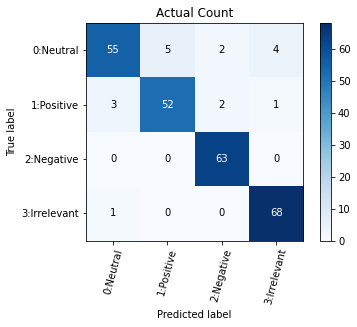

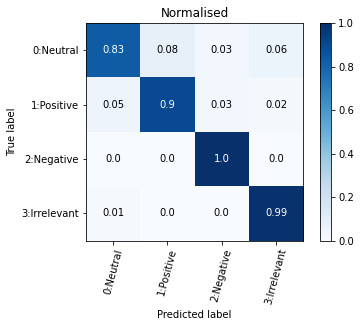

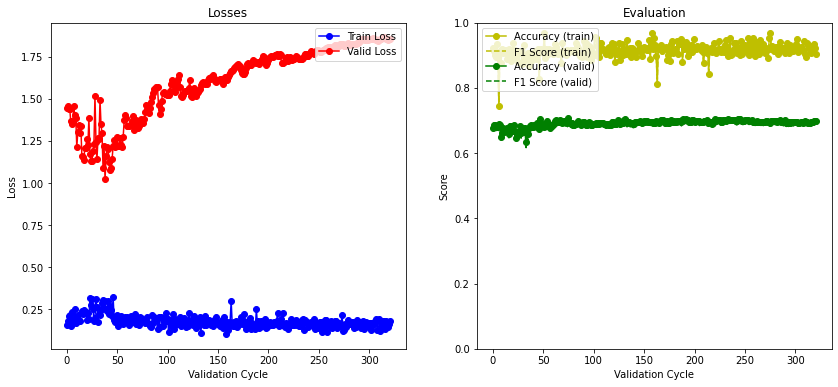

Epoch:  90%|█████████ | 63/70 [09:36<01:05,  9.31s/it]

[2022-08-25 15:54:22,080][INFO] ## ================     epoch 64     ===============


INFO:sa_tweet_inperf:================     epoch 64     ===============
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:54:23,043][DEBUG] ## Epoch: 64/70, Step: 3531, Loss: 44.6390, Acc: 0.6966, F1: 0.6853


DEBUG:sa_tweet_inperf:Epoch: 64/70, Step: 3531, Loss: 44.6390, Acc: 0.6966, F1: 0.6853
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:54:24,733][DEBUG] ## Epoch: 64/70, Step: 3542, Loss: 44.7120, Acc: 0.6966, F1: 0.6860


DEBUG:sa_tweet_inperf:Epoch: 64/70, Step: 3542, Loss: 44.7120, Acc: 0.6966, F1: 0.6860
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:54:26,415][DEBUG] ## Epoch: 64/70, Step: 3553, Loss: 44.8487, Acc: 0.6966, F1: 0.6862


DEBUG:sa_tweet_inperf:Epoch: 64/70, Step: 3553, Loss: 44.8487, Acc: 0.6966, F1: 0.6862
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:54:28,113][DEBUG] ## Epoch: 64/70, Step: 3564, Loss: 44.9699, Acc: 0.6953, F1: 0.6851


DEBUG:sa_tweet_inperf:Epoch: 64/70, Step: 3564, Loss: 44.9699, Acc: 0.6953, F1: 0.6851
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:54:29,801][DEBUG] ## Epoch: 64/70, Step: 3575, Loss: 44.9551, Acc: 0.6953, F1: 0.6856


DEBUG:sa_tweet_inperf:Epoch: 64/70, Step: 3575, Loss: 44.9551, Acc: 0.6953, F1: 0.6856
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:54:30,612][INFO] ## Epoch: 64, Loss: 1.8731, Acc: 0.6953, F1: 0.6856, LR: 3.39e-05


INFO:sa_tweet_inperf:Epoch: 64, Loss: 1.8731, Acc: 0.6953, F1: 0.6856, LR: 3.39e-05


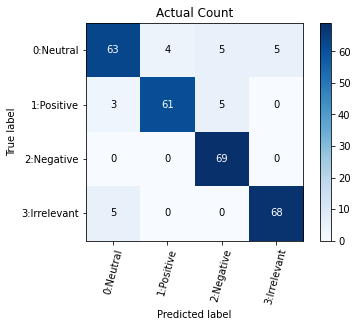

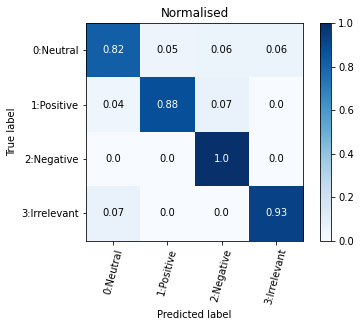

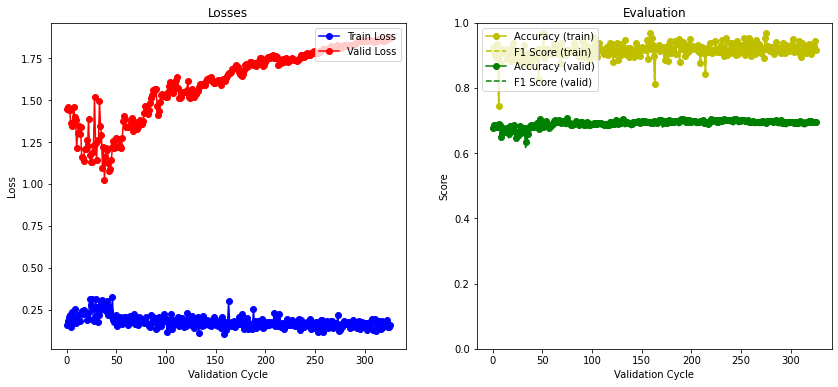

Epoch:  91%|█████████▏| 64/70 [09:45<00:56,  9.36s/it]

[2022-08-25 15:54:31,576][INFO] ## ================     epoch 65     ===============


INFO:sa_tweet_inperf:================     epoch 65     ===============
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:54:32,442][DEBUG] ## Epoch: 65/70, Step: 3586, Loss: 44.9189, Acc: 0.6953, F1: 0.6850


DEBUG:sa_tweet_inperf:Epoch: 65/70, Step: 3586, Loss: 44.9189, Acc: 0.6953, F1: 0.6850
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:54:34,146][DEBUG] ## Epoch: 65/70, Step: 3597, Loss: 44.9097, Acc: 0.6914, F1: 0.6806


DEBUG:sa_tweet_inperf:Epoch: 65/70, Step: 3597, Loss: 44.9097, Acc: 0.6914, F1: 0.6806
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:54:35,839][DEBUG] ## Epoch: 65/70, Step: 3608, Loss: 44.8391, Acc: 0.6940, F1: 0.6830


DEBUG:sa_tweet_inperf:Epoch: 65/70, Step: 3608, Loss: 44.8391, Acc: 0.6940, F1: 0.6830
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:54:37,530][DEBUG] ## Epoch: 65/70, Step: 3619, Loss: 44.7747, Acc: 0.6953, F1: 0.6841


DEBUG:sa_tweet_inperf:Epoch: 65/70, Step: 3619, Loss: 44.7747, Acc: 0.6953, F1: 0.6841
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:54:39,229][DEBUG] ## Epoch: 65/70, Step: 3630, Loss: 44.7734, Acc: 0.6953, F1: 0.6840


DEBUG:sa_tweet_inperf:Epoch: 65/70, Step: 3630, Loss: 44.7734, Acc: 0.6953, F1: 0.6840
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:54:40,141][INFO] ## Epoch: 65, Loss: 1.8656, Acc: 0.6953, F1: 0.6840, LR: 2.92e-05


INFO:sa_tweet_inperf:Epoch: 65, Loss: 1.8656, Acc: 0.6953, F1: 0.6840, LR: 2.92e-05


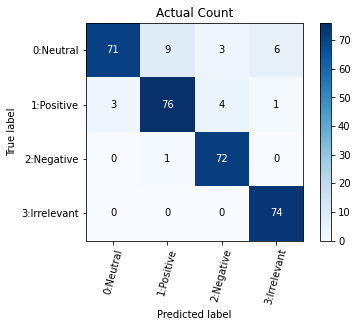

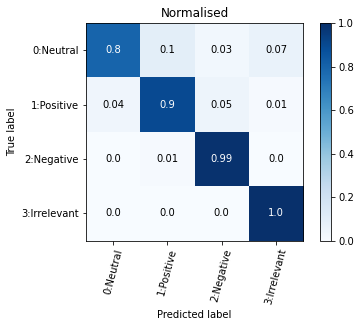

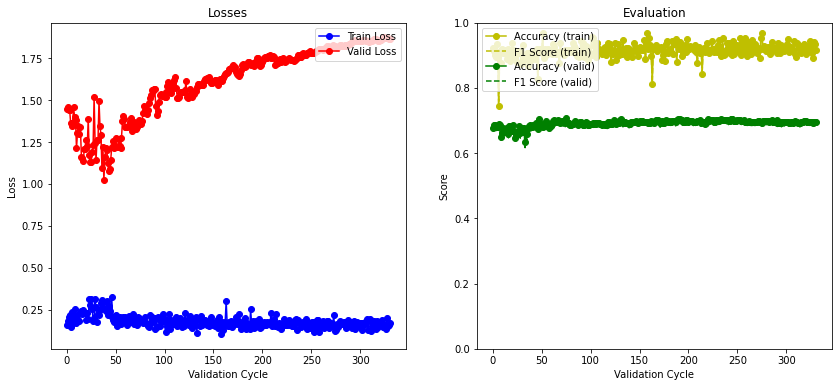

Epoch:  93%|█████████▎| 65/70 [09:55<00:46,  9.35s/it]

[2022-08-25 15:54:40,882][INFO] ## ================     epoch 66     ===============


INFO:sa_tweet_inperf:================     epoch 66     ===============
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:54:41,646][DEBUG] ## Epoch: 66/70, Step: 3641, Loss: 44.8390, Acc: 0.6966, F1: 0.6853


DEBUG:sa_tweet_inperf:Epoch: 66/70, Step: 3641, Loss: 44.8390, Acc: 0.6966, F1: 0.6853
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:54:43,339][DEBUG] ## Epoch: 66/70, Step: 3652, Loss: 44.8634, Acc: 0.6966, F1: 0.6862


DEBUG:sa_tweet_inperf:Epoch: 66/70, Step: 3652, Loss: 44.8634, Acc: 0.6966, F1: 0.6862
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:54:45,033][DEBUG] ## Epoch: 66/70, Step: 3663, Loss: 44.9895, Acc: 0.6940, F1: 0.6841


DEBUG:sa_tweet_inperf:Epoch: 66/70, Step: 3663, Loss: 44.9895, Acc: 0.6940, F1: 0.6841
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:54:46,728][DEBUG] ## Epoch: 66/70, Step: 3674, Loss: 45.0856, Acc: 0.6979, F1: 0.6886


DEBUG:sa_tweet_inperf:Epoch: 66/70, Step: 3674, Loss: 45.0856, Acc: 0.6979, F1: 0.6886
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:54:48,429][DEBUG] ## Epoch: 66/70, Step: 3685, Loss: 45.1012, Acc: 0.6979, F1: 0.6876


DEBUG:sa_tweet_inperf:Epoch: 66/70, Step: 3685, Loss: 45.1012, Acc: 0.6979, F1: 0.6876
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:54:50,127][DEBUG] ## Epoch: 66/70, Step: 3696, Loss: 45.0364, Acc: 0.6940, F1: 0.6833


DEBUG:sa_tweet_inperf:Epoch: 66/70, Step: 3696, Loss: 45.0364, Acc: 0.6940, F1: 0.6833


[2022-08-25 15:54:50,130][INFO] ## Epoch: 66, Loss: 1.8765, Acc: 0.6940, F1: 0.6833, LR: 2.46e-05


INFO:sa_tweet_inperf:Epoch: 66, Loss: 1.8765, Acc: 0.6940, F1: 0.6833, LR: 2.46e-05


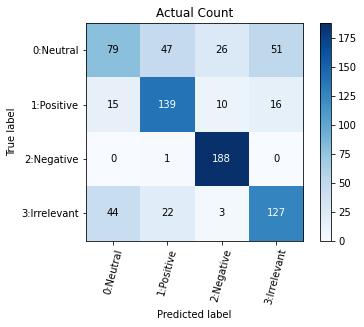

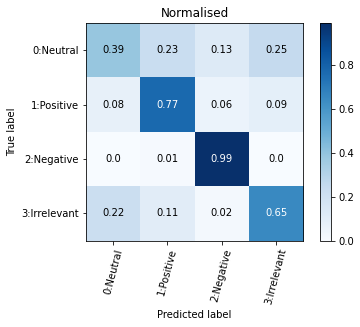

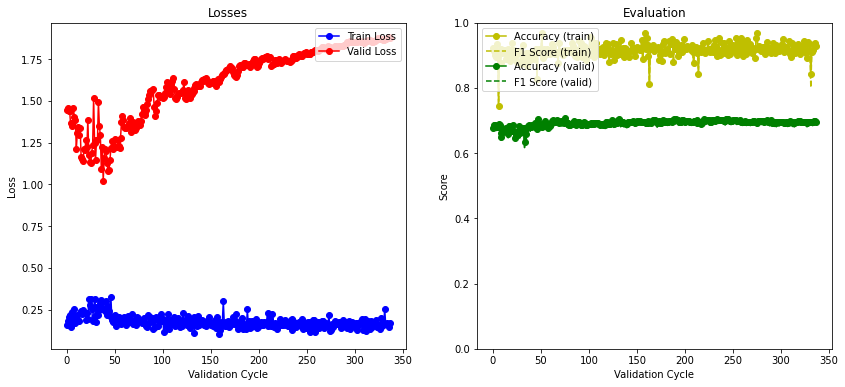

Epoch:  94%|█████████▍| 66/70 [10:05<00:38,  9.56s/it]

[2022-08-25 15:54:50,921][INFO] ## ================     epoch 67     ===============


INFO:sa_tweet_inperf:================     epoch 67     ===============
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:54:52,614][DEBUG] ## Epoch: 67/70, Step: 3707, Loss: 44.9125, Acc: 0.6966, F1: 0.6854


DEBUG:sa_tweet_inperf:Epoch: 67/70, Step: 3707, Loss: 44.9125, Acc: 0.6966, F1: 0.6854
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:54:54,307][DEBUG] ## Epoch: 67/70, Step: 3718, Loss: 44.9605, Acc: 0.6966, F1: 0.6854


DEBUG:sa_tweet_inperf:Epoch: 67/70, Step: 3718, Loss: 44.9605, Acc: 0.6966, F1: 0.6854
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:54:56,006][DEBUG] ## Epoch: 67/70, Step: 3729, Loss: 44.9094, Acc: 0.6940, F1: 0.6829


DEBUG:sa_tweet_inperf:Epoch: 67/70, Step: 3729, Loss: 44.9094, Acc: 0.6940, F1: 0.6829
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:54:57,705][DEBUG] ## Epoch: 67/70, Step: 3740, Loss: 44.9332, Acc: 0.6940, F1: 0.6829


DEBUG:sa_tweet_inperf:Epoch: 67/70, Step: 3740, Loss: 44.9332, Acc: 0.6940, F1: 0.6829
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:54:59,396][DEBUG] ## Epoch: 67/70, Step: 3751, Loss: 44.9587, Acc: 0.6953, F1: 0.6842


DEBUG:sa_tweet_inperf:Epoch: 67/70, Step: 3751, Loss: 44.9587, Acc: 0.6953, F1: 0.6842


[2022-08-25 15:54:59,477][INFO] ## Epoch: 67, Loss: 1.8733, Acc: 0.6953, F1: 0.6842, LR: 1.99e-05


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
INFO:sa_tweet_inperf:Epoch: 67, Loss: 1.8733, Acc: 0.6953, F1: 0.6842, LR: 1.99e-05


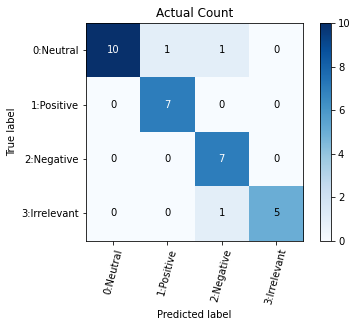

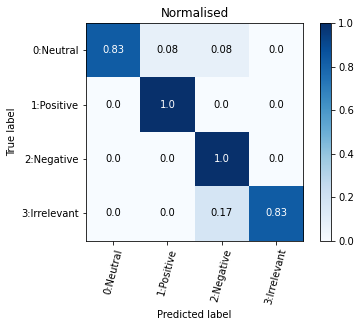

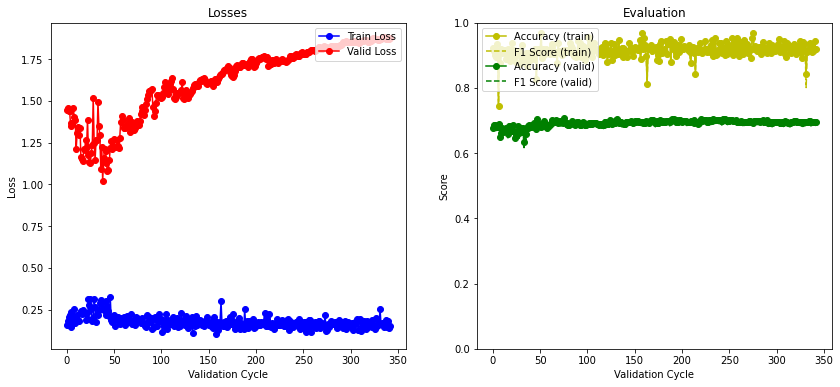

Epoch:  96%|█████████▌| 67/70 [10:14<00:28,  9.48s/it]

[2022-08-25 15:55:00,223][INFO] ## ================     epoch 68     ===============


INFO:sa_tweet_inperf:================     epoch 68     ===============
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:55:01,820][DEBUG] ## Epoch: 68/70, Step: 3762, Loss: 45.0104, Acc: 0.6979, F1: 0.6876


DEBUG:sa_tweet_inperf:Epoch: 68/70, Step: 3762, Loss: 45.0104, Acc: 0.6979, F1: 0.6876
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:55:03,515][DEBUG] ## Epoch: 68/70, Step: 3773, Loss: 45.0701, Acc: 0.6992, F1: 0.6888


DEBUG:sa_tweet_inperf:Epoch: 68/70, Step: 3773, Loss: 45.0701, Acc: 0.6992, F1: 0.6888
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:55:05,205][DEBUG] ## Epoch: 68/70, Step: 3784, Loss: 45.1397, Acc: 0.6992, F1: 0.6888


DEBUG:sa_tweet_inperf:Epoch: 68/70, Step: 3784, Loss: 45.1397, Acc: 0.6992, F1: 0.6888
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:55:06,892][DEBUG] ## Epoch: 68/70, Step: 3795, Loss: 45.1696, Acc: 0.6966, F1: 0.6863


DEBUG:sa_tweet_inperf:Epoch: 68/70, Step: 3795, Loss: 45.1696, Acc: 0.6966, F1: 0.6863
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:55:08,595][DEBUG] ## Epoch: 68/70, Step: 3806, Loss: 45.1366, Acc: 0.6953, F1: 0.6843


DEBUG:sa_tweet_inperf:Epoch: 68/70, Step: 3806, Loss: 45.1366, Acc: 0.6953, F1: 0.6843


[2022-08-25 15:55:08,767][INFO] ## Epoch: 68, Loss: 1.8807, Acc: 0.6953, F1: 0.6843, LR: 1.52e-05


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
INFO:sa_tweet_inperf:Epoch: 68, Loss: 1.8807, Acc: 0.6953, F1: 0.6843, LR: 1.52e-05


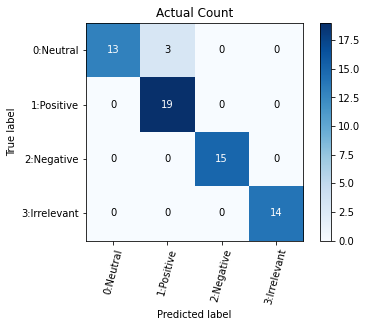

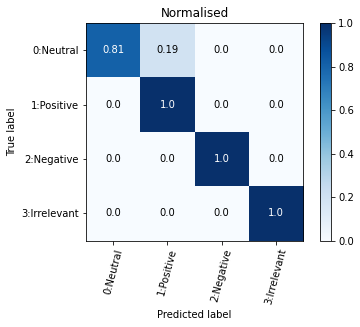

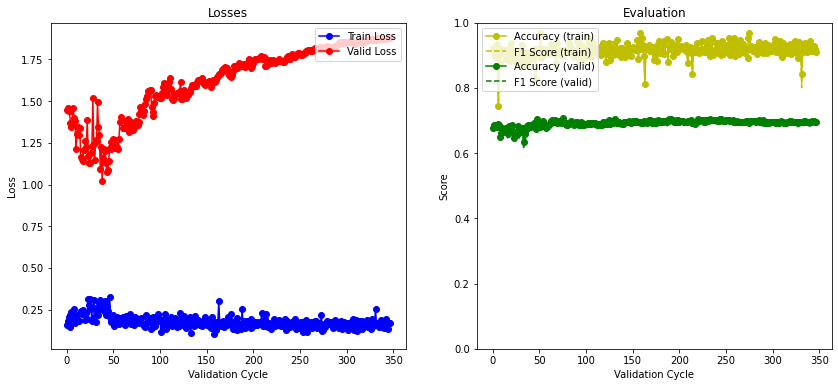

Epoch:  97%|█████████▋| 68/70 [10:23<00:18,  9.41s/it]

[2022-08-25 15:55:09,482][INFO] ## ================     epoch 69     ===============


INFO:sa_tweet_inperf:================     epoch 69     ===============
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:55:11,000][DEBUG] ## Epoch: 69/70, Step: 3817, Loss: 45.1532, Acc: 0.6979, F1: 0.6876


DEBUG:sa_tweet_inperf:Epoch: 69/70, Step: 3817, Loss: 45.1532, Acc: 0.6979, F1: 0.6876
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:55:12,699][DEBUG] ## Epoch: 69/70, Step: 3828, Loss: 45.1625, Acc: 0.6966, F1: 0.6864


DEBUG:sa_tweet_inperf:Epoch: 69/70, Step: 3828, Loss: 45.1625, Acc: 0.6966, F1: 0.6864
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:55:14,399][DEBUG] ## Epoch: 69/70, Step: 3839, Loss: 45.2009, Acc: 0.6966, F1: 0.6864


DEBUG:sa_tweet_inperf:Epoch: 69/70, Step: 3839, Loss: 45.2009, Acc: 0.6966, F1: 0.6864
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:55:16,107][DEBUG] ## Epoch: 69/70, Step: 3850, Loss: 45.2699, Acc: 0.6979, F1: 0.6880


DEBUG:sa_tweet_inperf:Epoch: 69/70, Step: 3850, Loss: 45.2699, Acc: 0.6979, F1: 0.6880
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:55:17,808][DEBUG] ## Epoch: 69/70, Step: 3861, Loss: 45.2787, Acc: 0.6953, F1: 0.6852


DEBUG:sa_tweet_inperf:Epoch: 69/70, Step: 3861, Loss: 45.2787, Acc: 0.6953, F1: 0.6852
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:55:18,074][INFO] ## Epoch: 69, Loss: 1.8866, Acc: 0.6953, F1: 0.6852, LR: 1.05e-05


INFO:sa_tweet_inperf:Epoch: 69, Loss: 1.8866, Acc: 0.6953, F1: 0.6852, LR: 1.05e-05


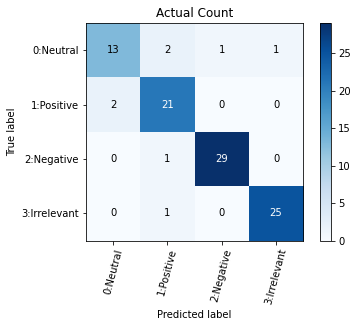

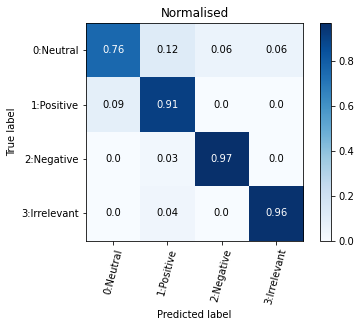

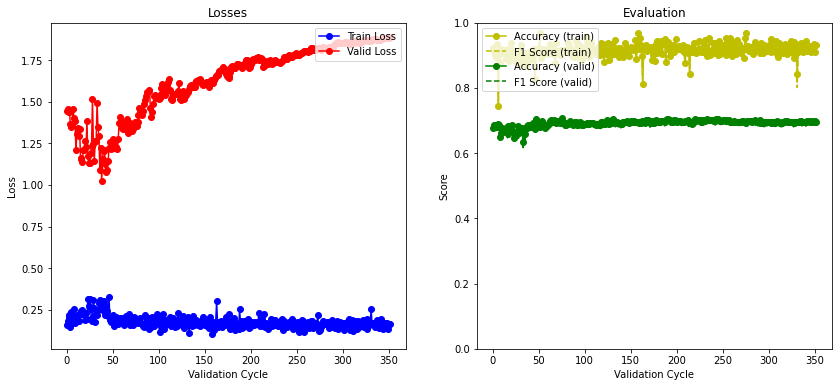

Epoch:  99%|█████████▊| 69/70 [10:33<00:09,  9.39s/it]

[2022-08-25 15:55:18,824][INFO] ## ================     epoch 70     ===============


INFO:sa_tweet_inperf:================     epoch 70     ===============
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:55:20,241][DEBUG] ## Epoch: 70/70, Step: 3872, Loss: 45.2717, Acc: 0.6966, F1: 0.6864


DEBUG:sa_tweet_inperf:Epoch: 70/70, Step: 3872, Loss: 45.2717, Acc: 0.6966, F1: 0.6864
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:55:21,943][DEBUG] ## Epoch: 70/70, Step: 3883, Loss: 45.2849, Acc: 0.6966, F1: 0.6864


DEBUG:sa_tweet_inperf:Epoch: 70/70, Step: 3883, Loss: 45.2849, Acc: 0.6966, F1: 0.6864
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:55:23,634][DEBUG] ## Epoch: 70/70, Step: 3894, Loss: 45.3104, Acc: 0.6940, F1: 0.6839


DEBUG:sa_tweet_inperf:Epoch: 70/70, Step: 3894, Loss: 45.3104, Acc: 0.6940, F1: 0.6839
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:55:25,334][DEBUG] ## Epoch: 70/70, Step: 3905, Loss: 45.3254, Acc: 0.6940, F1: 0.6839


DEBUG:sa_tweet_inperf:Epoch: 70/70, Step: 3905, Loss: 45.3254, Acc: 0.6940, F1: 0.6839
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:55:27,039][DEBUG] ## Epoch: 70/70, Step: 3916, Loss: 45.3298, Acc: 0.6966, F1: 0.6864


DEBUG:sa_tweet_inperf:Epoch: 70/70, Step: 3916, Loss: 45.3298, Acc: 0.6966, F1: 0.6864
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2022-08-25 15:55:27,397][INFO] ## Epoch: 70, Loss: 1.8887, Acc: 0.6966, F1: 0.6864, LR: 5.85e-06


INFO:sa_tweet_inperf:Epoch: 70, Loss: 1.8887, Acc: 0.6966, F1: 0.6864, LR: 5.85e-06


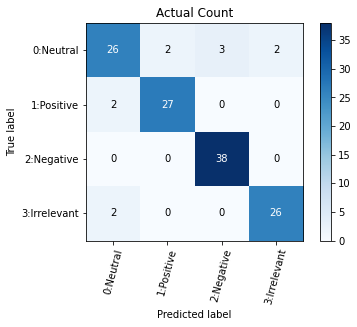

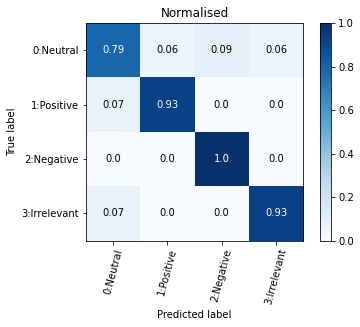

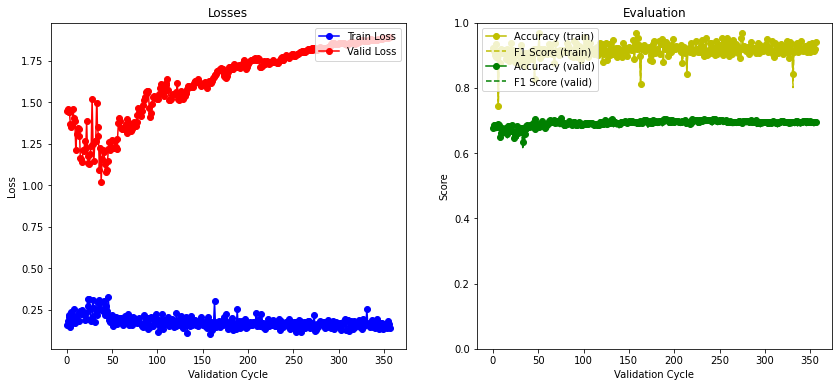

Epoch: 100%|██████████| 70/70 [10:42<00:00,  9.18s/it]

[2022-08-25 15:55:28,146][INFO] ## Process Time (sec): 642.4703536029992



INFO:sa_tweet_inperf:Process Time (sec): 642.4703536029992


Accuracy F1(macro)  Total_Time     ms/text
2600   0.6966    0.6864  642.470354  247.103982

In [50]:
# Define the training parameters
num_samples = [data.shape[0]]
epochs=70
patience=3
batch_size=32
seq_len = 30
lr=3e-4
clip=5
log_level=logging.DEBUG

# Run!
result_lstm, model_trained_lstm = train_cycles(np.array(data['Text']), np.array(data['Sentiment']), vocab, num_samples, 'LSTM', epochs, patience, batch_size, seq_len, lr, clip, log_level)

# Save the model and show the result
torch.save(model_trained_lstm.state_dict(),'/content/drive/MyDrive/dataset/eth_model2.dict')
result_lstm

In [43]:
test = data1[2500:2660]

In [17]:
eth['Text'][0:64]

0     the price is at right now compared to the last...
1     the price is at right now compared to the last...
2     sold cryptopunk was purchased for nft nfts dig...
3     wake me up when the next bull run starts crypt...
4     best tip to survive the crypto bear market tal...
                            ...                        
59              ethereum eth current price eth ethereum
60      vechain bitcoin ethereum bnb nfts cro metaverse
61    ethereum daily update hr change current price ...
62    ethereum mean block interval just reached mont...
63    ethereum number of active addresses ma just re...
Name: Text, Length: 64, dtype: object

Inference

In [18]:
model_trained_lstm = LstmTextClassifier(len(vocab), embed_size=512, lstm_size=1024, dense_size=0, output_size=4, lstm_layers=4, dropout=0.2)
model_trained_lstm.load_state_dict(torch.load('eth_model2.dict', map_location=torch.device('cpu')))
model_trained_lstm.eval()
batch_size = 64
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
hidden = model_trained_lstm.init_hidden(batch_size)
#indices = np.ones(test.shape[0], dtype = bool)
#loader = create_data_loader(test['Text'], test['Sentiment'],indices,  batch_size, False)
#for i, batch in enumerate(loader):
#text_batch, labels = batch
seq_len = 30
y_pred = []
for i in range(0,640,64):
    
    text_batch = tokenizer_lstm(eth['Text'][i:i+64], vocab, seq_len, padding='left').transpose(1,0).to(device)
    #labels = torch.tensor(labels, dtype=torch.int64).to(device)
    # Creating new variables for the hidden state to avoid backprop entire training history
#text_batch.to(device)
    logits, hidden = model_trained_lstm(text_batch, hidden)
    
    y_pred.extend(np.argmax(F.softmax(logits, dim=1).cpu().detach().numpy(), axis=1))

In [19]:
y_pred

[1,
 1,
 3,
 3,
 3,
 0,
 1,
 2,
 3,
 2,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 3,
 0,
 1,
 3,
 2,
 3,
 2,
 2,
 0,
 0,
 0,
 0,
 2,
 0,
 0,
 3,
 0,
 0,
 0,
 2,
 0,
 3,
 0,
 2,
 3,
 2,
 2,
 0,
 2,
 3,
 0,
 0,
 0,
 2,
 3,
 2,
 2,
 0,
 2,
 0,
 2,
 3,
 1,
 0,
 1,
 0,
 2,
 1,
 2,
 0,
 2,
 0,
 0,
 2,
 3,
 2,
 3,
 3,
 2,
 3,
 2,
 0,
 3,
 2,
 2,
 2,
 1,
 3,
 2,
 0,
 1,
 3,
 0,
 2,
 3,
 0,
 2,
 0,
 0,
 0,
 3,
 3,
 3,
 0,
 2,
 3,
 3,
 1,
 0,
 2,
 0,
 1,
 0,
 0,
 2,
 0,
 2,
 3,
 3,
 0,
 2,
 0,
 3,
 2,
 3,
 3,
 3,
 3,
 0,
 1,
 0,
 2,
 0,
 3,
 2,
 3,
 1,
 0,
 2,
 3,
 0,
 3,
 2,
 0,
 0,
 2,
 3,
 2,
 3,
 3,
 2,
 3,
 3,
 3,
 0,
 1,
 0,
 1,
 2,
 2,
 0,
 3,
 2,
 2,
 1,
 0,
 2,
 1,
 0,
 1,
 0,
 0,
 2,
 1,
 3,
 2,
 0,
 3,
 3,
 0,
 0,
 3,
 3,
 3,
 3,
 2,
 0,
 1,
 0,
 3,
 0,
 3,
 2,
 2,
 2,
 1,
 2,
 1,
 3,
 3,
 3,
 2,
 0,
 0,
 0,
 3,
 0,
 3,
 0,
 3,
 2,
 3,
 3,
 3,
 3,
 2,
 2,
 0,
 2,
 0,
 3,
 2,
 3,
 3,
 2,
 3,
 1,
 3,
 1,
 3,
 3,
 0,
 3,
 2,
 0,
 1,
 0,
 3,
 2,
 3,
 0,
 3,
 3,
 3,
 1,
 2,
 3,
 3,
 0,
 0,
 0,


In [215]:
torch.save(model_trained_lstm.state_dict(), '/content/drive/MyDrive/dataset/eth_model.dict')

In [52]:
y_pred = []
y_pred.extend(np.argmax(F.softmax(logits, dim=1).cpu().detach().numpy(), axis=1))

In [53]:
y_truth = list(test['Sentiment'])

In [54]:
acc, f1 = metric(y_truth, y_pred)

In [55]:
acc, f1

(0.7375, 0.7383143256882114)

In [200]:
text_batch

tensor([[   0,    0,    0,  ...,   42,    0,    0],
        [   0,    0,    0,  ..., 4800,    0,    0],
        [   0,    0,    0,  ...,   38,    0,    0],
        ...,
        [ 211,  144,  308,  ..., 2723, 4823,  186],
        [  17,  102,   13,  ..., 4502, 4824, 1637],
        [   1,   42,    1,  ..., 4809, 4825,    1]], device='cuda:0')

In [201]:
np.vstack([y_truth, y_pred])

array([[1., 0., 2., 2., 2., 0., 3., 3., 1., 2., 0., 3., 1., 3., 2., 2.,
        2., 0., 2., 0., 0., 2., 2., 2., 1., 1., 3., 3., 1., 1., 3., 0.,
        3., 1., 1., 1., 1., 2., 2., 1., 1., 2., 2., 0., 0., 0., 1., 3.,
        0., 0., 2., 1., 1., 1., 3., 0., 1., 3., 0., 1., 2., 0., 0., 0.,
        2., 3., 0., 1., 3., 0., 1., 0., 3., 2., 3., 0., 2., 2., 2., 2.,
        0., 2., 1., 3., 3., 0., 1., 2., 1., 0., 3., 2., 0., 1., 3., 3.,
        0., 0., 0., 1., 0., 3., 3., 2., 0., 3., 3., 3., 2., 3., 2., 0.,
        2., 2., 1., 3., 2., 0., 2., 2., 2., 2., 1., 0., 2., 1., 2., 3.,
        2., 2., 3., 1., 1., 1., 0., 1., 2., 1., 1., 0., 2., 2., 3., 0.,
        0., 1., 1., 3., 2., 0., 0., 1., 0., 0., 1., 1., 0., 3., 3., 2.],
       [2., 0., 2., 2., 2., 3., 3., 3., 1., 2., 0., 3., 1., 3., 2., 2.,
        2., 0., 2., 0., 2., 2., 2., 2., 1., 1., 3., 3., 1., 1., 3., 0.,
        0., 1., 3., 1., 1., 2., 2., 1., 0., 2., 2., 0., 0., 0., 3., 3.,
        0., 0., 2., 1., 1., 1., 3., 0., 1., 0., 0., 2., 2., 0.,

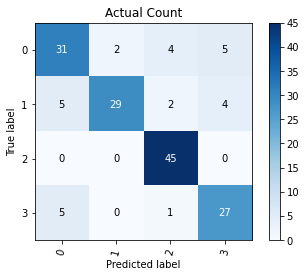

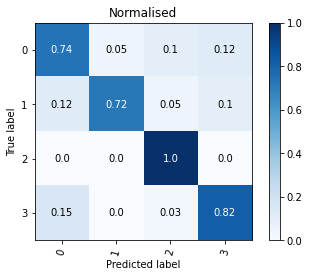

In [202]:
# Plot Confusion Matrix
class_names = [0,1,2,3]
y_truth_class = [class_names[int(idx)] for idx in y_truth]
y_predicted_class = [class_names[int(idx)] for idx in y_pred]
        
titles_options = [("Actual Count", None), ("Normalised", 'true')]
for title, normalize in titles_options:
   disp = skplt.metrics.plot_confusion_matrix(y_truth_class, y_predicted_class, normalize=normalize, title=title, x_tick_rotation=75)
plt.show()

In [5]:
eth['Text']

0         The $ETH price is at $1,979.03 right now.\n🟢 C...
1         The $ETH price is at $1,977.47 right now.\n🔴 C...
2         Sold! CryptoPunk #3042 was purchased for Ξ45.5...
3         WAKE ME UP WHEN THE NEXT BULL RUN STARTS #cryp...
4         Best tip to survive the crypto bear market? Ta...
                                ...                        
310640    $sxp Tp2 ✅ %20 kar ile ikinci hedefim de geldi...
310641    $ETH has out preformed $BTC by 53% in 2020.\n#...
310642    $ETH\n\n#Ethereum today will give us an idea i...
310643    $ETH Ranges for the next session: \nUpper: $74...
310644    Market Update: The price of #Ethereum is curre...
Name: Text, Length: 310645, dtype: object

In [6]:
eth = pd.read_csv(r"C:\Users\Ihtisham Ahmad\Desktop\ipython\Social Media\Ethereum.csv")
def preprocess(message):
    """
    This function takes a string as input, then performs these operations: 
        - lowercase
        - remove URLs
        - remove ticker symbols 
        - removes punctuation
        - removes any single character tokens
    Parameters
    ----------
        message : The text message to be preprocessed
    Returns
    -------
        text: The preprocessed text
    """ 
    # Lowercase the twit message
    text = message.lower()
    # Replace URLs with a space in the message
    text = re.sub('https?:\/\/[a-zA-Z0-9@:%._\/+~#=?&;-]*', ' ', text)
    # Replace ticker symbols with a space. The ticker symbols are any stock symbol that starts with $.
    text = re.sub('\$[a-zA-Z0-9]*', ' ', text)
    # Replace StockTwits usernames with a space. The usernames are any word that starts with @.
    text = re.sub('\@[a-zA-Z0-9]*', ' ', text)
    # Replace everything not a letter or apostrophe with a space
    text = re.sub('[^a-zA-Z\']', ' ', text)
    # Remove single letter words
    text = ' '.join( [w for w in text.split() if len(w)>1] )
    
    return text
        
# Process for all messages
eth['Text'] = [preprocess(message) for message in tqdm(list(eth['Text']))]

100%|███████████████████████████████████████████████████████████████████████| 310645/310645 [00:07<00:00, 40941.98it/s]


In [ ]:
torch.save()